In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_11848\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0005'][0]), len(Battery['B0005'][1])

(168, 168)

## 画出数据

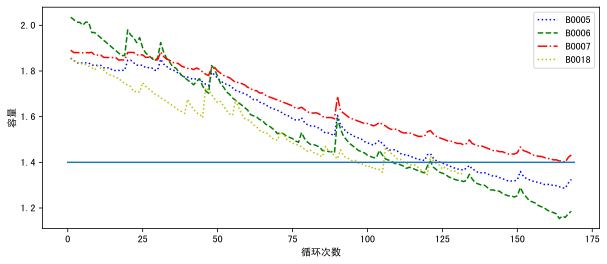

In [3]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建数据

In [3]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + window_size]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 评估函数

In [4]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 测试 train_iter 的数据是否正确

In [5]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, y in train_iter:
        print(X.shape)
        print(y.shape)
        print(X[1])
        print(y[1])
        break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

## 随机种子

In [6]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 模型

In [7]:
# 模型
class Net(nn.Module):
    def __init__(self, window_size, hidden_dim, num_layers, mode='LSTM', n_class=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.cell = nn.LSTM(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_dim, n_class)

    def forward(self, x):  # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x)
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)  # out shape: (batch_size, n_class=1)
        return out

## 测试模型的输出形状

In [10]:
# 测试模型的输出形状
def validate_model_output_shape(net, X):
    test_y_hat = net(X)
    print(test_y_hat.shape)
    print(test_y_hat[0, 0])

# test_x = torch.ones((1, 1, 16))
# validate_model_output_shape(net, test_x)

## 一个批次的训练函数

In [8]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, y in train_iter:
        # 计算梯度并更新参数
        X = torch.reshape(X / Rated_Capacity, (-1, 1, window_size)).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, 1)).type(torch.float32)
        X, y = X.to(device), y.to(device)
        
        y_hat = net(X)
        l = loss(y_hat, y)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [9]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
        
        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
        
        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)
            
        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [10]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = torch.from_numpy(x).to(device)  # shape: (batch_size, 1, input_size)
        pred = net(x).cpu()
        next_point = pred.data.numpy()[0, 0] * Rated_Capacity
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

## RNN 模型 开始训练

### 当 is_train=False 时 re的最好结果是0.26

In [22]:
# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'RNN'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s = [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.3397347629 , MAE:1.5291 , RMSE:1.5363 , RE:0.9908 , R2:-72.0629
seed: 0, 测试集: B0005, epoch:2    , loss:0.2080402374 , MAE:1.4038 , RMSE:1.4109 , RE:0.9908 , R2:-60.6174
seed: 0, 测试集: B0005, epoch:3    , loss:0.1097620502 , MAE:1.2284 , RMSE:1.2360 , RE:0.9908 , R2:-46.2944
seed: 0, 测试集: B0005, epoch:4    , loss:0.0448409133 , MAE:0.9764 , RMSE:0.9847 , RE:0.9908 , R2:-29.0133
seed: 0, 测试集: B0005, epoch:5    , loss:0.0110470317 , MAE:0.6262 , RMSE:0.6342 , RE:0.9358 , R2:-11.4501
seed: 0, 测试集: B0005, epoch:6    , loss:0.0005533327 , MAE:0.2260 , RMSE:0.2447 , RE:0.7064 , R2:-0.8534
seed: 0, 测试集: B0005, epoch:7    , loss:0.0008464091 , MAE:0.1307 , RMSE:0.1532 , RE:0.3945 , R2:0.2739
seed: 0, 测试集: B0005, epoch:10   , loss:0.0007954222 , MAE:0.1162 , RMSE:0.1325 , RE:0.3945 , R2:0.4564
seed: 0, 测

seed: 0, 测试集: B0005, epoch:85   , loss:0.0001582790 , MAE:0.0885 , RMSE:0.1008 , RE:0.3945 , R2:0.6853
seed: 0, 测试集: B0005, epoch:86   , loss:0.0001559903 , MAE:0.0881 , RMSE:0.1004 , RE:0.3945 , R2:0.6877
seed: 0, 测试集: B0005, epoch:87   , loss:0.0001537335 , MAE:0.0877 , RMSE:0.1001 , RE:0.3945 , R2:0.6900
seed: 0, 测试集: B0005, epoch:88   , loss:0.0001515078 , MAE:0.0873 , RMSE:0.0997 , RE:0.3945 , R2:0.6924
seed: 0, 测试集: B0005, epoch:89   , loss:0.0001493114 , MAE:0.0870 , RMSE:0.0993 , RE:0.3945 , R2:0.6947
seed: 0, 测试集: B0005, epoch:90   , loss:0.0001471484 , MAE:0.0866 , RMSE:0.0989 , RE:0.3945 , R2:0.6971
seed: 0, 测试集: B0005, epoch:91   , loss:0.0001450164 , MAE:0.0862 , RMSE:0.0985 , RE:0.3945 , R2:0.6994
seed: 0, 测试集: B0005, epoch:92   , loss:0.0001429172 , MAE:0.0858 , RMSE:0.0982 , RE:0.3945 , R2:0.7018
seed: 0, 测试集: B0005, epoch:93   , loss:0.0001408492 , MAE:0.0854 , RMSE:0.0978 , RE:0.3945 , R2:0.7041
seed: 0, 测试集: B0005, epoch:94   , loss:0.0001388133 , MAE:0.0851 , RMSE:0

seed: 0, 测试集: B0005, epoch:165  , loss:0.0000735809 , MAE:0.0570 , RMSE:0.0700 , RE:0.0459 , R2:0.8483
seed: 0, 测试集: B0005, epoch:166  , loss:0.0000735387 , MAE:0.0567 , RMSE:0.0697 , RE:0.0367 , R2:0.8497
seed: 0, 测试集: B0005, epoch:167  , loss:0.0000735109 , MAE:0.0563 , RMSE:0.0693 , RE:0.0367 , R2:0.8511
seed: 0, 测试集: B0005, epoch:168  , loss:0.0000734972 , MAE:0.0560 , RMSE:0.0690 , RE:0.0367 , R2:0.8525
seed: 0, 测试集: B0005, epoch:169  , loss:0.0000734971 , MAE:0.0557 , RMSE:0.0687 , RE:0.0367 , R2:0.8539
seed: 0, 测试集: B0005, epoch:170  , loss:0.0000735106 , MAE:0.0553 , RMSE:0.0684 , RE:0.0367 , R2:0.8553
seed: 0, 测试集: B0005, epoch:171  , loss:0.0000735361 , MAE:0.0550 , RMSE:0.0681 , RE:0.0367 , R2:0.8566
seed: 0, 测试集: B0005, epoch:172  , loss:0.0000735745 , MAE:0.0546 , RMSE:0.0677 , RE:0.0367 , R2:0.8579
seed: 0, 测试集: B0005, epoch:173  , loss:0.0000736243 , MAE:0.0543 , RMSE:0.0674 , RE:0.0367 , R2:0.8593
seed: 0, 测试集: B0005, epoch:174  , loss:0.0000736858 , MAE:0.0540 , RMSE:0

seed: 0, 测试集: B0005, epoch:247  , loss:0.0000875430 , MAE:0.0397 , RMSE:0.0521 , RE:0.0367 , R2:0.9160
seed: 0, 测试集: B0005, epoch:248  , loss:0.0000876792 , MAE:0.0396 , RMSE:0.0520 , RE:0.0459 , R2:0.9163
seed: 0, 测试集: B0005, epoch:249  , loss:0.0000878115 , MAE:0.0395 , RMSE:0.0519 , RE:0.0459 , R2:0.9167
seed: 0, 测试集: B0005, epoch:250  , loss:0.0000879408 , MAE:0.0394 , RMSE:0.0518 , RE:0.0459 , R2:0.9170
seed: 0, 测试集: B0005, epoch:251  , loss:0.0000880657 , MAE:0.0394 , RMSE:0.0517 , RE:0.0459 , R2:0.9173
seed: 0, 测试集: B0005, epoch:252  , loss:0.0000881882 , MAE:0.0393 , RMSE:0.0516 , RE:0.0459 , R2:0.9177
seed: 0, 测试集: B0005, epoch:253  , loss:0.0000883065 , MAE:0.0392 , RMSE:0.0515 , RE:0.0459 , R2:0.9180
seed: 0, 测试集: B0005, epoch:254  , loss:0.0000884216 , MAE:0.0392 , RMSE:0.0514 , RE:0.0459 , R2:0.9183
seed: 0, 测试集: B0005, epoch:255  , loss:0.0000885329 , MAE:0.0391 , RMSE:0.0513 , RE:0.0459 , R2:0.9186
seed: 0, 测试集: B0005, epoch:256  , loss:0.0000886400 , MAE:0.0391 , RMSE:0

以电池 B0006 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0006, epoch:1    , loss:0.3170739114 , MAE:1.4208 , RMSE:1.4340 , RE:0.9892 , R2:-41.1688
seed: 0, 测试集: B0006, epoch:2    , loss:0.1945745796 , MAE:1.2971 , RMSE:1.3087 , RE:0.9892 , R2:-34.1189
seed: 0, 测试集: B0006, epoch:3    , loss:0.1017750725 , MAE:1.1233 , RMSE:1.1339 , RE:0.9892 , R2:-25.3657
seed: 0, 测试集: B0006, epoch:4    , loss:0.0403394736 , MAE:0.8714 , RMSE:0.8820 , RE:0.9892 , R2:-14.9527
seed: 0, 测试集: B0006, epoch:5    , loss:0.0090277130 , MAE:0.5210 , RMSE:0.5345 , RE:0.9032 , R2:-4.8594
seed: 0, 测试集: B0006, epoch:6    , loss:0.0002324881 , MAE:0.1533 , RMSE:0.1822 , RE:0.5699 , R2:0.3190
seed: 0, 测试集: B0006, epoch:11   , loss:0.0006446003 , MAE:0.1380 , RMSE:0.1624 , RE:0.6344 , R2:0.4591
seed: 0, 测试集: B0006, epoch:12   , loss:0.0004711064 , MAE:0.1298 , RMSE:0.1533 , RE:0.6344 , R2:0.5179
seed: 0, 测试集: B0006, epoch:66   , loss:0.0004569415 , MAE:0.1293 , RMSE:0.1531 , RE:0.6344 , R2:0.5191
seed: 0, 测试集: B0006, epoch:67   , loss

seed: 0, 测试集: B0006, epoch:139  , loss:0.0001993436 , MAE:0.1091 , RMSE:0.1303 , RE:0.6344 , R2:0.6518
seed: 0, 测试集: B0006, epoch:140  , loss:0.0001966194 , MAE:0.1089 , RMSE:0.1300 , RE:0.6344 , R2:0.6535
seed: 0, 测试集: B0006, epoch:141  , loss:0.0001939269 , MAE:0.1086 , RMSE:0.1297 , RE:0.6344 , R2:0.6552
seed: 0, 测试集: B0006, epoch:142  , loss:0.0001912653 , MAE:0.1084 , RMSE:0.1294 , RE:0.6344 , R2:0.6568
seed: 0, 测试集: B0006, epoch:143  , loss:0.0001886323 , MAE:0.1081 , RMSE:0.1291 , RE:0.6344 , R2:0.6584
seed: 0, 测试集: B0006, epoch:144  , loss:0.0001860293 , MAE:0.1079 , RMSE:0.1288 , RE:0.6344 , R2:0.6600
seed: 0, 测试集: B0006, epoch:145  , loss:0.0001834573 , MAE:0.1076 , RMSE:0.1285 , RE:0.6344 , R2:0.6616
seed: 0, 测试集: B0006, epoch:146  , loss:0.0001809160 , MAE:0.1074 , RMSE:0.1282 , RE:0.6344 , R2:0.6632
seed: 0, 测试集: B0006, epoch:147  , loss:0.0001784071 , MAE:0.1072 , RMSE:0.1279 , RE:0.6344 , R2:0.6648
seed: 0, 测试集: B0006, epoch:148  , loss:0.0001759269 , MAE:0.1070 , RMSE:0

seed: 0, 测试集: B0018, epoch:9    , loss:0.0007524897 , MAE:0.0927 , RMSE:0.1114 , RE:0.4321 , R2:0.2548
seed: 0, 测试集: B0018, epoch:10   , loss:0.0003437125 , MAE:0.0764 , RMSE:0.0858 , RE:0.4321 , R2:0.5578
seed: 0, 测试集: B0018, epoch:11   , loss:0.0002544811 , MAE:0.0737 , RMSE:0.0831 , RE:0.4321 , R2:0.5850
seed: 0, 测试集: B0018, epoch:32   , loss:0.0002911192 , MAE:0.0729 , RMSE:0.0831 , RE:0.4321 , R2:0.5853
seed: 0, 测试集: B0018, epoch:33   , loss:0.0002864400 , MAE:0.0725 , RMSE:0.0827 , RE:0.4321 , R2:0.5886
seed: 0, 测试集: B0018, epoch:34   , loss:0.0002817607 , MAE:0.0722 , RMSE:0.0824 , RE:0.4321 , R2:0.5920
seed: 0, 测试集: B0018, epoch:35   , loss:0.0002770777 , MAE:0.0718 , RMSE:0.0821 , RE:0.4321 , R2:0.5954
seed: 0, 测试集: B0018, epoch:36   , loss:0.0002723948 , MAE:0.0715 , RMSE:0.0817 , RE:0.4321 , R2:0.5989
seed: 0, 测试集: B0018, epoch:37   , loss:0.0002677198 , MAE:0.0711 , RMSE:0.0813 , RE:0.4321 , R2:0.6024
seed: 0, 测试集: B0018, epoch:38   , loss:0.0002630516 , MAE:0.0708 , RMSE:0

seed: 0, 测试集: B0018, epoch:111  , loss:0.0000528766 , MAE:0.0409 , RMSE:0.0499 , RE:0.4321 , R2:0.8503
seed: 0, 测试集: B0018, epoch:112  , loss:0.0000522382 , MAE:0.0407 , RMSE:0.0496 , RE:0.4321 , R2:0.8521
seed: 0, 测试集: B0018, epoch:113  , loss:0.0000516494 , MAE:0.0404 , RMSE:0.0493 , RE:0.4321 , R2:0.8538
seed: 0, 测试集: B0018, epoch:114  , loss:0.0000511102 , MAE:0.0402 , RMSE:0.0490 , RE:0.4321 , R2:0.8555
seed: 0, 测试集: B0018, epoch:115  , loss:0.0000506193 , MAE:0.0400 , RMSE:0.0488 , RE:0.4321 , R2:0.8570
seed: 0, 测试集: B0018, epoch:116  , loss:0.0000501772 , MAE:0.0398 , RMSE:0.0485 , RE:0.4321 , R2:0.8585
seed: 0, 测试集: B0018, epoch:117  , loss:0.0000497796 , MAE:0.0396 , RMSE:0.0483 , RE:0.4321 , R2:0.8600
seed: 0, 测试集: B0018, epoch:118  , loss:0.0000494281 , MAE:0.0394 , RMSE:0.0480 , RE:0.4321 , R2:0.8613
seed: 0, 测试集: B0018, epoch:119  , loss:0.0000491205 , MAE:0.0393 , RMSE:0.0478 , RE:0.4321 , R2:0.8626
seed: 0, 测试集: B0018, epoch:120  , loss:0.0000488561 , MAE:0.0392 , RMSE:0

seed: 1, 测试集: B0005, epoch:55   , loss:0.0001247057 , MAE:0.0830 , RMSE:0.0953 , RE:0.3578 , R2:0.7189
seed: 1, 测试集: B0005, epoch:56   , loss:0.0001236097 , MAE:0.0827 , RMSE:0.0950 , RE:0.3486 , R2:0.7204
seed: 1, 测试集: B0005, epoch:57   , loss:0.0001225211 , MAE:0.0824 , RMSE:0.0948 , RE:0.3394 , R2:0.7220
seed: 1, 测试集: B0005, epoch:58   , loss:0.0001214375 , MAE:0.0822 , RMSE:0.0945 , RE:0.3303 , R2:0.7236
seed: 1, 测试集: B0005, epoch:59   , loss:0.0001203615 , MAE:0.0819 , RMSE:0.0942 , RE:0.3211 , R2:0.7252
seed: 1, 测试集: B0005, epoch:60   , loss:0.0001192910 , MAE:0.0816 , RMSE:0.0939 , RE:0.3119 , R2:0.7268
seed: 1, 测试集: B0005, epoch:61   , loss:0.0001182298 , MAE:0.0814 , RMSE:0.0937 , RE:0.3028 , R2:0.7284
seed: 1, 测试集: B0005, epoch:62   , loss:0.0001171758 , MAE:0.0811 , RMSE:0.0934 , RE:0.2936 , R2:0.7301
seed: 1, 测试集: B0005, epoch:63   , loss:0.0001161298 , MAE:0.0808 , RMSE:0.0931 , RE:0.2844 , R2:0.7317
seed: 1, 测试集: B0005, epoch:64   , loss:0.0001150923 , MAE:0.0805 , RMSE:0

seed: 1, 测试集: B0005, epoch:135  , loss:0.0000732935 , MAE:0.0581 , RMSE:0.0713 , RE:0.0459 , R2:0.8428
seed: 1, 测试集: B0005, epoch:136  , loss:0.0000731627 , MAE:0.0578 , RMSE:0.0710 , RE:0.0367 , R2:0.8441
seed: 1, 测试集: B0005, epoch:137  , loss:0.0000730418 , MAE:0.0575 , RMSE:0.0707 , RE:0.0367 , R2:0.8453
seed: 1, 测试集: B0005, epoch:138  , loss:0.0000729313 , MAE:0.0572 , RMSE:0.0704 , RE:0.0367 , R2:0.8466
seed: 1, 测试集: B0005, epoch:139  , loss:0.0000728305 , MAE:0.0569 , RMSE:0.0701 , RE:0.0367 , R2:0.8478
seed: 1, 测试集: B0005, epoch:140  , loss:0.0000727394 , MAE:0.0566 , RMSE:0.0698 , RE:0.0367 , R2:0.8490
seed: 1, 测试集: B0005, epoch:141  , loss:0.0000726577 , MAE:0.0563 , RMSE:0.0696 , RE:0.0367 , R2:0.8502
seed: 1, 测试集: B0005, epoch:142  , loss:0.0000725855 , MAE:0.0560 , RMSE:0.0693 , RE:0.0367 , R2:0.8514
seed: 1, 测试集: B0005, epoch:143  , loss:0.0000725222 , MAE:0.0557 , RMSE:0.0690 , RE:0.0367 , R2:0.8526
seed: 1, 测试集: B0005, epoch:144  , loss:0.0000724678 , MAE:0.0554 , RMSE:0

seed: 1, 测试集: B0005, epoch:216  , loss:0.0000804224 , MAE:0.0405 , RMSE:0.0538 , RE:0.0275 , R2:0.9102
seed: 1, 测试集: B0005, epoch:217  , loss:0.0000805664 , MAE:0.0404 , RMSE:0.0537 , RE:0.0275 , R2:0.9107
seed: 1, 测试集: B0005, epoch:218  , loss:0.0000807080 , MAE:0.0403 , RMSE:0.0536 , RE:0.0275 , R2:0.9111
seed: 1, 测试集: B0005, epoch:219  , loss:0.0000808477 , MAE:0.0402 , RMSE:0.0534 , RE:0.0275 , R2:0.9116
seed: 1, 测试集: B0005, epoch:220  , loss:0.0000809865 , MAE:0.0401 , RMSE:0.0533 , RE:0.0275 , R2:0.9120
seed: 1, 测试集: B0005, epoch:221  , loss:0.0000811236 , MAE:0.0400 , RMSE:0.0532 , RE:0.0275 , R2:0.9124
seed: 1, 测试集: B0005, epoch:222  , loss:0.0000812584 , MAE:0.0398 , RMSE:0.0531 , RE:0.0275 , R2:0.9128
seed: 1, 测试集: B0005, epoch:223  , loss:0.0000813917 , MAE:0.0397 , RMSE:0.0529 , RE:0.0367 , R2:0.9132
seed: 1, 测试集: B0005, epoch:224  , loss:0.0000815228 , MAE:0.0396 , RMSE:0.0528 , RE:0.0367 , R2:0.9136
seed: 1, 测试集: B0005, epoch:225  , loss:0.0000816523 , MAE:0.0395 , RMSE:0

seed: 1, 测试集: B0005, epoch:296  , loss:0.0000856363 , MAE:0.0375 , RMSE:0.0479 , RE:0.0642 , R2:0.9288
seed: 1, 测试集: B0005, epoch:297  , loss:0.0000856293 , MAE:0.0376 , RMSE:0.0479 , RE:0.0642 , R2:0.9289
seed: 1, 测试集: B0005, epoch:298  , loss:0.0000856226 , MAE:0.0376 , RMSE:0.0479 , RE:0.0734 , R2:0.9290
seed: 1, 测试集: B0005, epoch:299  , loss:0.0000856138 , MAE:0.0376 , RMSE:0.0479 , RE:0.0734 , R2:0.9290
seed: 1, 测试集: B0005, epoch:300  , loss:0.0000856040 , MAE:0.0376 , RMSE:0.0479 , RE:0.0734 , R2:0.9291
seed: 1, 测试集: B0005, epoch:301  , loss:0.0000855932 , MAE:0.0377 , RMSE:0.0478 , RE:0.0734 , R2:0.9292
seed: 1, 测试集: B0005, epoch:302  , loss:0.0000855805 , MAE:0.0377 , RMSE:0.0478 , RE:0.0734 , R2:0.9292
seed: 1, 测试集: B0005, epoch:303  , loss:0.0000855675 , MAE:0.0377 , RMSE:0.0478 , RE:0.0734 , R2:0.9293
seed: 1, 测试集: B0005, epoch:304  , loss:0.0000855534 , MAE:0.0377 , RMSE:0.0478 , RE:0.0734 , R2:0.9293
seed: 1, 测试集: B0005, epoch:305  , loss:0.0000855379 , MAE:0.0378 , RMSE:0

seed: 1, 测试集: B0006, epoch:134  , loss:0.0001430297 , MAE:0.1039 , RMSE:0.1232 , RE:0.6344 , R2:0.6888
seed: 1, 测试集: B0006, epoch:135  , loss:0.0001416874 , MAE:0.1037 , RMSE:0.1230 , RE:0.6344 , R2:0.6896
seed: 1, 测试集: B0006, epoch:136  , loss:0.0001403593 , MAE:0.1036 , RMSE:0.1229 , RE:0.6344 , R2:0.6905
seed: 1, 测试集: B0006, epoch:137  , loss:0.0001390463 , MAE:0.1035 , RMSE:0.1227 , RE:0.6344 , R2:0.6913
seed: 1, 测试集: B0006, epoch:138  , loss:0.0001377461 , MAE:0.1034 , RMSE:0.1225 , RE:0.6344 , R2:0.6920
seed: 1, 测试集: B0006, epoch:139  , loss:0.0001364587 , MAE:0.1033 , RMSE:0.1224 , RE:0.6344 , R2:0.6928
seed: 1, 测试集: B0006, epoch:140  , loss:0.0001351868 , MAE:0.1032 , RMSE:0.1222 , RE:0.6344 , R2:0.6936
seed: 1, 测试集: B0006, epoch:141  , loss:0.0001339289 , MAE:0.1031 , RMSE:0.1221 , RE:0.6344 , R2:0.6943
seed: 1, 测试集: B0006, epoch:142  , loss:0.0001326850 , MAE:0.1030 , RMSE:0.1219 , RE:0.6344 , R2:0.6951
seed: 1, 测试集: B0006, epoch:143  , loss:0.0001314552 , MAE:0.1029 , RMSE:0

seed: 1, 测试集: B0018, epoch:66   , loss:0.0000765657 , MAE:0.0473 , RMSE:0.0575 , RE:0.4321 , R2:0.8015
seed: 1, 测试集: B0018, epoch:67   , loss:0.0000755734 , MAE:0.0471 , RMSE:0.0572 , RE:0.4321 , R2:0.8031
seed: 1, 测试集: B0018, epoch:68   , loss:0.0000745937 , MAE:0.0469 , RMSE:0.0570 , RE:0.4321 , R2:0.8046
seed: 1, 测试集: B0018, epoch:69   , loss:0.0000736263 , MAE:0.0467 , RMSE:0.0568 , RE:0.4321 , R2:0.8062
seed: 1, 测试集: B0018, epoch:70   , loss:0.0000726697 , MAE:0.0465 , RMSE:0.0566 , RE:0.4321 , R2:0.8077
seed: 1, 测试集: B0018, epoch:71   , loss:0.0000717267 , MAE:0.0463 , RMSE:0.0563 , RE:0.4321 , R2:0.8093
seed: 1, 测试集: B0018, epoch:72   , loss:0.0000707969 , MAE:0.0461 , RMSE:0.0561 , RE:0.4321 , R2:0.8108
seed: 1, 测试集: B0018, epoch:73   , loss:0.0000698806 , MAE:0.0459 , RMSE:0.0559 , RE:0.4321 , R2:0.8123
seed: 1, 测试集: B0018, epoch:74   , loss:0.0000689771 , MAE:0.0457 , RMSE:0.0557 , RE:0.4321 , R2:0.8139
seed: 1, 测试集: B0018, epoch:75   , loss:0.0000680882 , MAE:0.0455 , RMSE:0

seed: 1, 测试集: B0018, epoch:147  , loss:0.0000456137 , MAE:0.0377 , RMSE:0.0449 , RE:0.3827 , R2:0.8791
seed: 1, 测试集: B0018, epoch:148  , loss:0.0000458226 , MAE:0.0377 , RMSE:0.0448 , RE:0.3827 , R2:0.8792
seed: 1, 测试集: B0018, epoch:149  , loss:0.0000460424 , MAE:0.0377 , RMSE:0.0448 , RE:0.3827 , R2:0.8793
seed: 1, 测试集: B0018, epoch:150  , loss:0.0000462720 , MAE:0.0377 , RMSE:0.0448 , RE:0.3827 , R2:0.8793
seed: 1, 测试集: B0018, epoch:151  , loss:0.0000465104 , MAE:0.0377 , RMSE:0.0448 , RE:0.3827 , R2:0.8794
seed: 1, 测试集: B0018, epoch:152  , loss:0.0000467584 , MAE:0.0377 , RMSE:0.0448 , RE:0.3704 , R2:0.8794
seed: 1, 测试集: B0018, epoch:153  , loss:0.0000470154 , MAE:0.0377 , RMSE:0.0448 , RE:0.3704 , R2:0.8794
---------------------------------
re_s [0.08256880733944955, 0.6344086021505376, 0.0, 0.37037037037037035]
---------------------------------
re mean: 0.27183694496508937
mae mean: 0.06996590587128984
rmse mean: 0.08189847761087511
---------------------------------
**************

seed: 2, 测试集: B0005, epoch:76   , loss:0.0002682722 , MAE:0.1023 , RMSE:0.1152 , RE:0.3945 , R2:0.5892
seed: 2, 测试集: B0005, epoch:77   , loss:0.0002647990 , MAE:0.1020 , RMSE:0.1149 , RE:0.3945 , R2:0.5915
seed: 2, 测试集: B0005, epoch:78   , loss:0.0002613462 , MAE:0.1017 , RMSE:0.1146 , RE:0.3945 , R2:0.5937
seed: 2, 测试集: B0005, epoch:79   , loss:0.0002579139 , MAE:0.1014 , RMSE:0.1142 , RE:0.3945 , R2:0.5960
seed: 2, 测试集: B0005, epoch:80   , loss:0.0002545028 , MAE:0.1011 , RMSE:0.1139 , RE:0.3945 , R2:0.5983
seed: 2, 测试集: B0005, epoch:81   , loss:0.0002511137 , MAE:0.1008 , RMSE:0.1136 , RE:0.3945 , R2:0.6006
seed: 2, 测试集: B0005, epoch:82   , loss:0.0002477474 , MAE:0.1005 , RMSE:0.1133 , RE:0.3945 , R2:0.6029
seed: 2, 测试集: B0005, epoch:83   , loss:0.0002444043 , MAE:0.1002 , RMSE:0.1129 , RE:0.3945 , R2:0.6052
seed: 2, 测试集: B0005, epoch:84   , loss:0.0002410857 , MAE:0.0999 , RMSE:0.1126 , RE:0.3945 , R2:0.6075
seed: 2, 测试集: B0005, epoch:85   , loss:0.0002377921 , MAE:0.0995 , RMSE:0

seed: 2, 测试集: B0005, epoch:158  , loss:0.0000844654 , MAE:0.0715 , RMSE:0.0836 , RE:0.1376 , R2:0.7835
seed: 2, 测试集: B0005, epoch:159  , loss:0.0000835965 , MAE:0.0711 , RMSE:0.0832 , RE:0.1284 , R2:0.7856
seed: 2, 测试集: B0005, epoch:160  , loss:0.0000827571 , MAE:0.0707 , RMSE:0.0828 , RE:0.1284 , R2:0.7877
seed: 2, 测试集: B0005, epoch:161  , loss:0.0000819450 , MAE:0.0702 , RMSE:0.0824 , RE:0.1193 , R2:0.7898
seed: 2, 测试集: B0005, epoch:162  , loss:0.0000811617 , MAE:0.0698 , RMSE:0.0820 , RE:0.1193 , R2:0.7918
seed: 2, 测试集: B0005, epoch:163  , loss:0.0000804065 , MAE:0.0694 , RMSE:0.0816 , RE:0.1101 , R2:0.7938
seed: 2, 测试集: B0005, epoch:164  , loss:0.0000796765 , MAE:0.0690 , RMSE:0.0812 , RE:0.1101 , R2:0.7959
seed: 2, 测试集: B0005, epoch:165  , loss:0.0000789756 , MAE:0.0686 , RMSE:0.0808 , RE:0.1101 , R2:0.7979
seed: 2, 测试集: B0005, epoch:166  , loss:0.0000783001 , MAE:0.0682 , RMSE:0.0804 , RE:0.1009 , R2:0.7998
seed: 2, 测试集: B0005, epoch:167  , loss:0.0000776507 , MAE:0.0678 , RMSE:0

seed: 2, 测试集: B0005, epoch:238  , loss:0.0000731479 , MAE:0.0449 , RMSE:0.0578 , RE:0.0367 , R2:0.8967
seed: 2, 测试集: B0005, epoch:239  , loss:0.0000733519 , MAE:0.0447 , RMSE:0.0575 , RE:0.0367 , R2:0.8975
seed: 2, 测试集: B0005, epoch:240  , loss:0.0000735559 , MAE:0.0445 , RMSE:0.0573 , RE:0.0367 , R2:0.8982
seed: 2, 测试集: B0005, epoch:241  , loss:0.0000737599 , MAE:0.0443 , RMSE:0.0571 , RE:0.0367 , R2:0.8990
seed: 2, 测试集: B0005, epoch:242  , loss:0.0000739648 , MAE:0.0441 , RMSE:0.0569 , RE:0.0367 , R2:0.8997
seed: 2, 测试集: B0005, epoch:243  , loss:0.0000741689 , MAE:0.0439 , RMSE:0.0567 , RE:0.0367 , R2:0.9004
seed: 2, 测试集: B0005, epoch:244  , loss:0.0000743737 , MAE:0.0437 , RMSE:0.0565 , RE:0.0367 , R2:0.9011
seed: 2, 测试集: B0005, epoch:245  , loss:0.0000745769 , MAE:0.0435 , RMSE:0.0563 , RE:0.0367 , R2:0.9018
seed: 2, 测试集: B0005, epoch:246  , loss:0.0000747807 , MAE:0.0434 , RMSE:0.0561 , RE:0.0367 , R2:0.9025
seed: 2, 测试集: B0005, epoch:247  , loss:0.0000749830 , MAE:0.0432 , RMSE:0

seed: 2, 测试集: B0005, epoch:318  , loss:0.0000834648 , MAE:0.0386 , RMSE:0.0485 , RE:0.0734 , R2:0.9271
seed: 2, 测试集: B0005, epoch:319  , loss:0.0000834898 , MAE:0.0386 , RMSE:0.0485 , RE:0.0734 , R2:0.9272
seed: 2, 测试集: B0005, epoch:320  , loss:0.0000835129 , MAE:0.0386 , RMSE:0.0485 , RE:0.0734 , R2:0.9273
seed: 2, 测试集: B0005, epoch:321  , loss:0.0000835340 , MAE:0.0386 , RMSE:0.0484 , RE:0.0734 , R2:0.9274
seed: 2, 测试集: B0005, epoch:322  , loss:0.0000835533 , MAE:0.0386 , RMSE:0.0484 , RE:0.0734 , R2:0.9275
seed: 2, 测试集: B0005, epoch:323  , loss:0.0000835700 , MAE:0.0386 , RMSE:0.0484 , RE:0.0734 , R2:0.9275
seed: 2, 测试集: B0005, epoch:324  , loss:0.0000835854 , MAE:0.0387 , RMSE:0.0484 , RE:0.0826 , R2:0.9276
seed: 2, 测试集: B0005, epoch:325  , loss:0.0000835980 , MAE:0.0387 , RMSE:0.0483 , RE:0.0826 , R2:0.9277
seed: 2, 测试集: B0005, epoch:326  , loss:0.0000836096 , MAE:0.0387 , RMSE:0.0483 , RE:0.0826 , R2:0.9278
seed: 2, 测试集: B0005, epoch:327  , loss:0.0000836192 , MAE:0.0387 , RMSE:0

seed: 2, 测试集: B0006, epoch:82   , loss:0.0003791719 , MAE:0.1195 , RMSE:0.1425 , RE:0.6344 , R2:0.5835
seed: 2, 测试集: B0006, epoch:83   , loss:0.0003701849 , MAE:0.1189 , RMSE:0.1418 , RE:0.6344 , R2:0.5876
seed: 2, 测试集: B0006, epoch:84   , loss:0.0003613654 , MAE:0.1183 , RMSE:0.1411 , RE:0.6344 , R2:0.5917
seed: 2, 测试集: B0006, epoch:85   , loss:0.0003527120 , MAE:0.1176 , RMSE:0.1404 , RE:0.6344 , R2:0.5957
seed: 2, 测试集: B0006, epoch:86   , loss:0.0003442249 , MAE:0.1170 , RMSE:0.1397 , RE:0.6344 , R2:0.5997
seed: 2, 测试集: B0006, epoch:87   , loss:0.0003359042 , MAE:0.1164 , RMSE:0.1390 , RE:0.6344 , R2:0.6037
seed: 2, 测试集: B0006, epoch:88   , loss:0.0003277510 , MAE:0.1158 , RMSE:0.1383 , RE:0.6344 , R2:0.6076
seed: 2, 测试集: B0006, epoch:89   , loss:0.0003197651 , MAE:0.1152 , RMSE:0.1376 , RE:0.6344 , R2:0.6115
seed: 2, 测试集: B0006, epoch:90   , loss:0.0003119453 , MAE:0.1146 , RMSE:0.1370 , RE:0.6344 , R2:0.6154
seed: 2, 测试集: B0006, epoch:91   , loss:0.0003042906 , MAE:0.1140 , RMSE:0

seed: 2, 测试集: B0018, epoch:37   , loss:0.0005093788 , MAE:0.0831 , RMSE:0.0932 , RE:0.4321 , R2:0.4776
seed: 2, 测试集: B0018, epoch:38   , loss:0.0005030558 , MAE:0.0828 , RMSE:0.0930 , RE:0.4321 , R2:0.4806
seed: 2, 测试集: B0018, epoch:39   , loss:0.0004967166 , MAE:0.0826 , RMSE:0.0927 , RE:0.4321 , R2:0.4836
seed: 2, 测试集: B0018, epoch:40   , loss:0.0004903643 , MAE:0.0823 , RMSE:0.0924 , RE:0.4321 , R2:0.4867
seed: 2, 测试集: B0018, epoch:41   , loss:0.0004839937 , MAE:0.0820 , RMSE:0.0921 , RE:0.4321 , R2:0.4898
seed: 2, 测试集: B0018, epoch:42   , loss:0.0004776119 , MAE:0.0817 , RMSE:0.0919 , RE:0.4321 , R2:0.4929
seed: 2, 测试集: B0018, epoch:43   , loss:0.0004712264 , MAE:0.0815 , RMSE:0.0916 , RE:0.4321 , R2:0.4960
seed: 2, 测试集: B0018, epoch:44   , loss:0.0004648350 , MAE:0.0812 , RMSE:0.0913 , RE:0.4321 , R2:0.4992
seed: 2, 测试集: B0018, epoch:45   , loss:0.0004584405 , MAE:0.0809 , RMSE:0.0910 , RE:0.4321 , R2:0.5025
seed: 2, 测试集: B0018, epoch:46   , loss:0.0004520500 , MAE:0.0806 , RMSE:0

seed: 2, 测试集: B0018, epoch:117  , loss:0.0001010447 , MAE:0.0510 , RMSE:0.0613 , RE:0.4321 , R2:0.7739
seed: 2, 测试集: B0018, epoch:118  , loss:0.0000984019 , MAE:0.0505 , RMSE:0.0609 , RE:0.4321 , R2:0.7773
seed: 2, 测试集: B0018, epoch:119  , loss:0.0000958328 , MAE:0.0501 , RMSE:0.0604 , RE:0.4321 , R2:0.7806
seed: 2, 测试集: B0018, epoch:120  , loss:0.0000933357 , MAE:0.0496 , RMSE:0.0600 , RE:0.4321 , R2:0.7839
seed: 2, 测试集: B0018, epoch:121  , loss:0.0000909104 , MAE:0.0492 , RMSE:0.0595 , RE:0.4321 , R2:0.7872
seed: 2, 测试集: B0018, epoch:122  , loss:0.0000885580 , MAE:0.0487 , RMSE:0.0591 , RE:0.4321 , R2:0.7905
seed: 2, 测试集: B0018, epoch:123  , loss:0.0000862752 , MAE:0.0483 , RMSE:0.0586 , RE:0.4321 , R2:0.7936
seed: 2, 测试集: B0018, epoch:124  , loss:0.0000840648 , MAE:0.0479 , RMSE:0.0582 , RE:0.4321 , R2:0.7968
seed: 2, 测试集: B0018, epoch:125  , loss:0.0000819245 , MAE:0.0475 , RMSE:0.0577 , RE:0.4321 , R2:0.7999
seed: 2, 测试集: B0018, epoch:126  , loss:0.0000798548 , MAE:0.0470 , RMSE:0

seed: 3, 测试集: B0005, epoch:15   , loss:0.0007675095 , MAE:0.1236 , RMSE:0.1385 , RE:0.3945 , R2:0.4062
seed: 3, 测试集: B0005, epoch:16   , loss:0.0007496721 , MAE:0.1234 , RMSE:0.1383 , RE:0.3945 , R2:0.4078
seed: 3, 测试集: B0005, epoch:17   , loss:0.0007214695 , MAE:0.1232 , RMSE:0.1381 , RE:0.3945 , R2:0.4093
seed: 3, 测试集: B0005, epoch:18   , loss:0.0007031848 , MAE:0.1230 , RMSE:0.1380 , RE:0.3945 , R2:0.4107
seed: 3, 测试集: B0005, epoch:19   , loss:0.0006967554 , MAE:0.1229 , RMSE:0.1378 , RE:0.3945 , R2:0.4125
seed: 3, 测试集: B0005, epoch:20   , loss:0.0006953850 , MAE:0.1227 , RMSE:0.1376 , RE:0.3945 , R2:0.4143
seed: 3, 测试集: B0005, epoch:21   , loss:0.0006928704 , MAE:0.1225 , RMSE:0.1373 , RE:0.3945 , R2:0.4162
seed: 3, 测试集: B0005, epoch:22   , loss:0.0006873360 , MAE:0.1223 , RMSE:0.1371 , RE:0.3945 , R2:0.4180
seed: 3, 测试集: B0005, epoch:23   , loss:0.0006800424 , MAE:0.1221 , RMSE:0.1369 , RE:0.3945 , R2:0.4199
seed: 3, 测试集: B0005, epoch:24   , loss:0.0006726807 , MAE:0.1219 , RMSE:0

seed: 3, 测试集: B0005, epoch:95   , loss:0.0002143894 , MAE:0.0960 , RMSE:0.1084 , RE:0.3945 , R2:0.6360
seed: 3, 测试集: B0005, epoch:96   , loss:0.0002099116 , MAE:0.0954 , RMSE:0.1079 , RE:0.3945 , R2:0.6397
seed: 3, 测试集: B0005, epoch:97   , loss:0.0002055181 , MAE:0.0949 , RMSE:0.1073 , RE:0.3945 , R2:0.6433
seed: 3, 测试集: B0005, epoch:98   , loss:0.0002012050 , MAE:0.0944 , RMSE:0.1068 , RE:0.3945 , R2:0.6469
seed: 3, 测试集: B0005, epoch:99   , loss:0.0001969762 , MAE:0.0939 , RMSE:0.1063 , RE:0.3945 , R2:0.6505
seed: 3, 测试集: B0005, epoch:100  , loss:0.0001928279 , MAE:0.0933 , RMSE:0.1057 , RE:0.3945 , R2:0.6542
seed: 3, 测试集: B0005, epoch:101  , loss:0.0001887612 , MAE:0.0928 , RMSE:0.1051 , RE:0.3945 , R2:0.6578
seed: 3, 测试集: B0005, epoch:102  , loss:0.0001847762 , MAE:0.0923 , RMSE:0.1046 , RE:0.3945 , R2:0.6614
seed: 3, 测试集: B0005, epoch:103  , loss:0.0001808766 , MAE:0.0917 , RMSE:0.1040 , RE:0.3945 , R2:0.6650
seed: 3, 测试集: B0005, epoch:104  , loss:0.0001770566 , MAE:0.0912 , RMSE:0

seed: 3, 测试集: B0005, epoch:175  , loss:0.0000734503 , MAE:0.0542 , RMSE:0.0669 , RE:0.0459 , R2:0.8613
seed: 3, 测试集: B0005, epoch:176  , loss:0.0000734873 , MAE:0.0538 , RMSE:0.0666 , RE:0.0459 , R2:0.8629
seed: 3, 测试集: B0005, epoch:177  , loss:0.0000735418 , MAE:0.0534 , RMSE:0.0662 , RE:0.0459 , R2:0.8644
seed: 3, 测试集: B0005, epoch:178  , loss:0.0000736117 , MAE:0.0530 , RMSE:0.0658 , RE:0.0459 , R2:0.8659
seed: 3, 测试集: B0005, epoch:179  , loss:0.0000736957 , MAE:0.0527 , RMSE:0.0655 , RE:0.0459 , R2:0.8674
seed: 3, 测试集: B0005, epoch:180  , loss:0.0000737945 , MAE:0.0523 , RMSE:0.0651 , RE:0.0459 , R2:0.8688
seed: 3, 测试集: B0005, epoch:181  , loss:0.0000739065 , MAE:0.0520 , RMSE:0.0647 , RE:0.0459 , R2:0.8703
seed: 3, 测试集: B0005, epoch:182  , loss:0.0000740311 , MAE:0.0516 , RMSE:0.0644 , RE:0.0459 , R2:0.8716
seed: 3, 测试集: B0005, epoch:183  , loss:0.0000741671 , MAE:0.0513 , RMSE:0.0641 , RE:0.0459 , R2:0.8730
seed: 3, 测试集: B0005, epoch:184  , loss:0.0000743139 , MAE:0.0509 , RMSE:0

seed: 3, 测试集: B0005, epoch:255  , loss:0.0000874268 , MAE:0.0395 , RMSE:0.0507 , RE:0.0550 , R2:0.9203
seed: 3, 测试集: B0005, epoch:256  , loss:0.0000875003 , MAE:0.0394 , RMSE:0.0507 , RE:0.0642 , R2:0.9205
seed: 3, 测试集: B0005, epoch:257  , loss:0.0000875698 , MAE:0.0394 , RMSE:0.0506 , RE:0.0642 , R2:0.9207
seed: 3, 测试集: B0005, epoch:258  , loss:0.0000876363 , MAE:0.0394 , RMSE:0.0505 , RE:0.0642 , R2:0.9209
seed: 3, 测试集: B0005, epoch:259  , loss:0.0000876991 , MAE:0.0394 , RMSE:0.0505 , RE:0.0642 , R2:0.9211
seed: 3, 测试集: B0005, epoch:260  , loss:0.0000877588 , MAE:0.0394 , RMSE:0.0504 , RE:0.0642 , R2:0.9213
seed: 3, 测试集: B0005, epoch:261  , loss:0.0000878150 , MAE:0.0393 , RMSE:0.0504 , RE:0.0642 , R2:0.9215
seed: 3, 测试集: B0005, epoch:262  , loss:0.0000878679 , MAE:0.0393 , RMSE:0.0503 , RE:0.0642 , R2:0.9217
seed: 3, 测试集: B0005, epoch:263  , loss:0.0000879181 , MAE:0.0393 , RMSE:0.0502 , RE:0.0642 , R2:0.9219
seed: 3, 测试集: B0005, epoch:264  , loss:0.0000879649 , MAE:0.0393 , RMSE:0

seed: 3, 测试集: B0006, epoch:65   , loss:0.0004852528 , MAE:0.1320 , RMSE:0.1562 , RE:0.6344 , R2:0.4998
seed: 3, 测试集: B0006, epoch:66   , loss:0.0004775081 , MAE:0.1315 , RMSE:0.1556 , RE:0.6344 , R2:0.5033
seed: 3, 测试集: B0006, epoch:67   , loss:0.0004698287 , MAE:0.1310 , RMSE:0.1551 , RE:0.6344 , R2:0.5068
seed: 3, 测试集: B0006, epoch:68   , loss:0.0004622125 , MAE:0.1305 , RMSE:0.1545 , RE:0.6344 , R2:0.5103
seed: 3, 测试集: B0006, epoch:69   , loss:0.0004546645 , MAE:0.1300 , RMSE:0.1540 , RE:0.6344 , R2:0.5138
seed: 3, 测试集: B0006, epoch:70   , loss:0.0004471838 , MAE:0.1294 , RMSE:0.1534 , RE:0.6344 , R2:0.5173
seed: 3, 测试集: B0006, epoch:71   , loss:0.0004397725 , MAE:0.1289 , RMSE:0.1529 , RE:0.6344 , R2:0.5208
seed: 3, 测试集: B0006, epoch:72   , loss:0.0004324324 , MAE:0.1284 , RMSE:0.1523 , RE:0.6344 , R2:0.5244
seed: 3, 测试集: B0006, epoch:73   , loss:0.0004251654 , MAE:0.1279 , RMSE:0.1517 , RE:0.6344 , R2:0.5279
seed: 3, 测试集: B0006, epoch:74   , loss:0.0004179713 , MAE:0.1274 , RMSE:0

seed: 3, 测试集: B0006, epoch:145  , loss:0.0001156786 , MAE:0.1002 , RMSE:0.1178 , RE:0.6344 , R2:0.7154
seed: 3, 测试集: B0006, epoch:146  , loss:0.0001140524 , MAE:0.1002 , RMSE:0.1177 , RE:0.6344 , R2:0.7160
seed: 3, 测试集: B0006, epoch:147  , loss:0.0001124802 , MAE:0.1001 , RMSE:0.1176 , RE:0.6344 , R2:0.7166
seed: 3, 测试集: B0006, epoch:148  , loss:0.0001109601 , MAE:0.1001 , RMSE:0.1175 , RE:0.6344 , R2:0.7171
seed: 3, 测试集: B0006, epoch:149  , loss:0.0001094907 , MAE:0.1001 , RMSE:0.1174 , RE:0.6344 , R2:0.7175
seed: 3, 测试集: B0006, epoch:150  , loss:0.0001080731 , MAE:0.1001 , RMSE:0.1173 , RE:0.6344 , R2:0.7178
seed: 3, 测试集: B0006, epoch:151  , loss:0.0001067030 , MAE:0.1001 , RMSE:0.1172 , RE:0.6344 , R2:0.7181
seed: 3, 测试集: B0006, epoch:152  , loss:0.0001053822 , MAE:0.1002 , RMSE:0.1172 , RE:0.6344 , R2:0.7183
seed: 3, 测试集: B0006, epoch:153  , loss:0.0001041084 , MAE:0.1002 , RMSE:0.1172 , RE:0.6344 , R2:0.7184
seed: 3, 测试集: B0006, epoch:154  , loss:0.0001028802 , MAE:0.1003 , RMSE:0

seed: 3, 测试集: B0018, epoch:81   , loss:0.0000790663 , MAE:0.0481 , RMSE:0.0583 , RE:0.4321 , R2:0.7960
seed: 3, 测试集: B0018, epoch:82   , loss:0.0000767056 , MAE:0.0476 , RMSE:0.0577 , RE:0.4321 , R2:0.7997
seed: 3, 测试集: B0018, epoch:83   , loss:0.0000744321 , MAE:0.0471 , RMSE:0.0572 , RE:0.4321 , R2:0.8032
seed: 3, 测试集: B0018, epoch:84   , loss:0.0000722462 , MAE:0.0466 , RMSE:0.0567 , RE:0.4321 , R2:0.8067
seed: 3, 测试集: B0018, epoch:85   , loss:0.0000701468 , MAE:0.0461 , RMSE:0.0562 , RE:0.4321 , R2:0.8102
seed: 3, 测试集: B0018, epoch:86   , loss:0.0000681355 , MAE:0.0456 , RMSE:0.0557 , RE:0.4321 , R2:0.8135
seed: 3, 测试集: B0018, epoch:87   , loss:0.0000662069 , MAE:0.0452 , RMSE:0.0552 , RE:0.4321 , R2:0.8168
seed: 3, 测试集: B0018, epoch:88   , loss:0.0000643653 , MAE:0.0447 , RMSE:0.0547 , RE:0.4321 , R2:0.8201
seed: 3, 测试集: B0018, epoch:89   , loss:0.0000626053 , MAE:0.0443 , RMSE:0.0542 , RE:0.4321 , R2:0.8232
seed: 3, 测试集: B0018, epoch:90   , loss:0.0000609295 , MAE:0.0439 , RMSE:0

seed: 4, 测试集: B0005, epoch:32   , loss:0.0001542993 , MAE:0.0924 , RMSE:0.1048 , RE:0.3945 , R2:0.6599
seed: 4, 测试集: B0005, epoch:33   , loss:0.0001531593 , MAE:0.0922 , RMSE:0.1046 , RE:0.3945 , R2:0.6613
seed: 4, 测试集: B0005, epoch:34   , loss:0.0001520155 , MAE:0.0920 , RMSE:0.1044 , RE:0.3945 , R2:0.6627
seed: 4, 测试集: B0005, epoch:35   , loss:0.0001508628 , MAE:0.0917 , RMSE:0.1042 , RE:0.3945 , R2:0.6642
seed: 4, 测试集: B0005, epoch:36   , loss:0.0001496999 , MAE:0.0915 , RMSE:0.1039 , RE:0.3945 , R2:0.6656
seed: 4, 测试集: B0005, epoch:37   , loss:0.0001485294 , MAE:0.0913 , RMSE:0.1037 , RE:0.3945 , R2:0.6671
seed: 4, 测试集: B0005, epoch:38   , loss:0.0001473519 , MAE:0.0911 , RMSE:0.1035 , RE:0.3945 , R2:0.6686
seed: 4, 测试集: B0005, epoch:39   , loss:0.0001461735 , MAE:0.0908 , RMSE:0.1032 , RE:0.3945 , R2:0.6701
seed: 4, 测试集: B0005, epoch:40   , loss:0.0001449892 , MAE:0.0906 , RMSE:0.1030 , RE:0.3945 , R2:0.6716
seed: 4, 测试集: B0005, epoch:41   , loss:0.0001438006 , MAE:0.0904 , RMSE:0

seed: 4, 测试集: B0005, epoch:113  , loss:0.0000757852 , MAE:0.0683 , RMSE:0.0806 , RE:0.1009 , R2:0.7988
seed: 4, 测试集: B0005, epoch:114  , loss:0.0000752809 , MAE:0.0679 , RMSE:0.0803 , RE:0.1009 , R2:0.8004
seed: 4, 测试集: B0005, epoch:115  , loss:0.0000747904 , MAE:0.0676 , RMSE:0.0800 , RE:0.0917 , R2:0.8021
seed: 4, 测试集: B0005, epoch:116  , loss:0.0000743134 , MAE:0.0672 , RMSE:0.0796 , RE:0.0917 , R2:0.8037
seed: 4, 测试集: B0005, epoch:117  , loss:0.0000738499 , MAE:0.0669 , RMSE:0.0793 , RE:0.0917 , R2:0.8053
seed: 4, 测试集: B0005, epoch:118  , loss:0.0000733989 , MAE:0.0665 , RMSE:0.0790 , RE:0.0917 , R2:0.8069
seed: 4, 测试集: B0005, epoch:119  , loss:0.0000729614 , MAE:0.0662 , RMSE:0.0786 , RE:0.0826 , R2:0.8085
seed: 4, 测试集: B0005, epoch:120  , loss:0.0000725365 , MAE:0.0658 , RMSE:0.0783 , RE:0.0826 , R2:0.8101
seed: 4, 测试集: B0005, epoch:121  , loss:0.0000721243 , MAE:0.0655 , RMSE:0.0780 , RE:0.0826 , R2:0.8117
seed: 4, 测试集: B0005, epoch:122  , loss:0.0000717250 , MAE:0.0651 , RMSE:0

seed: 4, 测试集: B0005, epoch:193  , loss:0.0000664971 , MAE:0.0451 , RMSE:0.0585 , RE:0.0275 , R2:0.8940
seed: 4, 测试集: B0005, epoch:194  , loss:0.0000666033 , MAE:0.0449 , RMSE:0.0583 , RE:0.0275 , R2:0.8947
seed: 4, 测试集: B0005, epoch:195  , loss:0.0000667114 , MAE:0.0447 , RMSE:0.0581 , RE:0.0275 , R2:0.8954
seed: 4, 测试集: B0005, epoch:196  , loss:0.0000668208 , MAE:0.0446 , RMSE:0.0579 , RE:0.0275 , R2:0.8961
seed: 4, 测试集: B0005, epoch:197  , loss:0.0000669312 , MAE:0.0444 , RMSE:0.0578 , RE:0.0275 , R2:0.8967
seed: 4, 测试集: B0005, epoch:198  , loss:0.0000670421 , MAE:0.0442 , RMSE:0.0576 , RE:0.0275 , R2:0.8974
seed: 4, 测试集: B0005, epoch:199  , loss:0.0000671542 , MAE:0.0440 , RMSE:0.0574 , RE:0.0275 , R2:0.8981
seed: 4, 测试集: B0005, epoch:200  , loss:0.0000672675 , MAE:0.0438 , RMSE:0.0572 , RE:0.0275 , R2:0.8987
seed: 4, 测试集: B0005, epoch:201  , loss:0.0000673811 , MAE:0.0437 , RMSE:0.0570 , RE:0.0275 , R2:0.8993
seed: 4, 测试集: B0005, epoch:202  , loss:0.0000674949 , MAE:0.0435 , RMSE:0

seed: 4, 测试集: B0005, epoch:273  , loss:0.0000734786 , MAE:0.0378 , RMSE:0.0491 , RE:0.0550 , R2:0.9254
seed: 4, 测试集: B0005, epoch:274  , loss:0.0000735125 , MAE:0.0378 , RMSE:0.0490 , RE:0.0550 , R2:0.9256
seed: 4, 测试集: B0005, epoch:275  , loss:0.0000735460 , MAE:0.0378 , RMSE:0.0490 , RE:0.0550 , R2:0.9257
seed: 4, 测试集: B0005, epoch:276  , loss:0.0000735765 , MAE:0.0378 , RMSE:0.0489 , RE:0.0550 , R2:0.9259
seed: 4, 测试集: B0005, epoch:277  , loss:0.0000736068 , MAE:0.0378 , RMSE:0.0489 , RE:0.0550 , R2:0.9260
seed: 4, 测试集: B0005, epoch:278  , loss:0.0000736354 , MAE:0.0378 , RMSE:0.0488 , RE:0.0642 , R2:0.9261
seed: 4, 测试集: B0005, epoch:279  , loss:0.0000736630 , MAE:0.0378 , RMSE:0.0488 , RE:0.0642 , R2:0.9263
seed: 4, 测试集: B0005, epoch:280  , loss:0.0000736894 , MAE:0.0378 , RMSE:0.0488 , RE:0.0642 , R2:0.9264
seed: 4, 测试集: B0005, epoch:281  , loss:0.0000737139 , MAE:0.0378 , RMSE:0.0487 , RE:0.0642 , R2:0.9265
seed: 4, 测试集: B0005, epoch:282  , loss:0.0000737378 , MAE:0.0378 , RMSE:0

seed: 4, 测试集: B0006, epoch:88   , loss:0.0003194356 , MAE:0.1158 , RMSE:0.1382 , RE:0.6344 , R2:0.6083
seed: 4, 测试集: B0006, epoch:89   , loss:0.0003164454 , MAE:0.1156 , RMSE:0.1380 , RE:0.6344 , R2:0.6097
seed: 4, 测试集: B0006, epoch:90   , loss:0.0003134654 , MAE:0.1154 , RMSE:0.1377 , RE:0.6344 , R2:0.6111
seed: 4, 测试集: B0006, epoch:91   , loss:0.0003104914 , MAE:0.1152 , RMSE:0.1375 , RE:0.6344 , R2:0.6125
seed: 4, 测试集: B0006, epoch:92   , loss:0.0003075314 , MAE:0.1149 , RMSE:0.1372 , RE:0.6344 , R2:0.6140
seed: 4, 测试集: B0006, epoch:93   , loss:0.0003045786 , MAE:0.1147 , RMSE:0.1370 , RE:0.6344 , R2:0.6154
seed: 4, 测试集: B0006, epoch:94   , loss:0.0003016345 , MAE:0.1145 , RMSE:0.1367 , RE:0.6344 , R2:0.6168
seed: 4, 测试集: B0006, epoch:95   , loss:0.0002987026 , MAE:0.1143 , RMSE:0.1364 , RE:0.6344 , R2:0.6182
seed: 4, 测试集: B0006, epoch:96   , loss:0.0002957825 , MAE:0.1140 , RMSE:0.1362 , RE:0.6344 , R2:0.6197
seed: 4, 测试集: B0006, epoch:97   , loss:0.0002928738 , MAE:0.1138 , RMSE:0

seed: 4, 测试集: B0006, epoch:169  , loss:0.0001312655 , MAE:0.1018 , RMSE:0.1202 , RE:0.6344 , R2:0.7035
seed: 4, 测试集: B0006, epoch:170  , loss:0.0001298217 , MAE:0.1017 , RMSE:0.1201 , RE:0.6344 , R2:0.7042
seed: 4, 测试集: B0006, epoch:171  , loss:0.0001283988 , MAE:0.1016 , RMSE:0.1200 , RE:0.6344 , R2:0.7047
seed: 4, 测试集: B0006, epoch:172  , loss:0.0001270005 , MAE:0.1016 , RMSE:0.1199 , RE:0.6344 , R2:0.7053
seed: 4, 测试集: B0006, epoch:173  , loss:0.0001256246 , MAE:0.1015 , RMSE:0.1198 , RE:0.6344 , R2:0.7059
seed: 4, 测试集: B0006, epoch:174  , loss:0.0001242711 , MAE:0.1015 , RMSE:0.1197 , RE:0.6344 , R2:0.7064
seed: 4, 测试集: B0006, epoch:175  , loss:0.0001229403 , MAE:0.1014 , RMSE:0.1196 , RE:0.6344 , R2:0.7069
seed: 4, 测试集: B0006, epoch:176  , loss:0.0001216323 , MAE:0.1013 , RMSE:0.1195 , RE:0.6344 , R2:0.7074
seed: 4, 测试集: B0006, epoch:177  , loss:0.0001203457 , MAE:0.1013 , RMSE:0.1194 , RE:0.6344 , R2:0.7078
seed: 4, 测试集: B0006, epoch:178  , loss:0.0001190826 , MAE:0.1012 , RMSE:0

seed: 4, 测试集: B0018, epoch:72   , loss:0.0001431032 , MAE:0.0568 , RMSE:0.0671 , RE:0.4321 , R2:0.7292
seed: 4, 测试集: B0018, epoch:73   , loss:0.0001402324 , MAE:0.0564 , RMSE:0.0667 , RE:0.4321 , R2:0.7324
seed: 4, 测试集: B0018, epoch:74   , loss:0.0001374010 , MAE:0.0560 , RMSE:0.0663 , RE:0.4321 , R2:0.7355
seed: 4, 测试集: B0018, epoch:75   , loss:0.0001346115 , MAE:0.0556 , RMSE:0.0659 , RE:0.4321 , R2:0.7387
seed: 4, 测试集: B0018, epoch:76   , loss:0.0001318663 , MAE:0.0552 , RMSE:0.0656 , RE:0.4321 , R2:0.7418
seed: 4, 测试集: B0018, epoch:77   , loss:0.0001291608 , MAE:0.0548 , RMSE:0.0652 , RE:0.4321 , R2:0.7449
seed: 4, 测试集: B0018, epoch:78   , loss:0.0001265008 , MAE:0.0544 , RMSE:0.0648 , RE:0.4321 , R2:0.7480
seed: 4, 测试集: B0018, epoch:79   , loss:0.0001238852 , MAE:0.0540 , RMSE:0.0644 , RE:0.4321 , R2:0.7511
seed: 4, 测试集: B0018, epoch:80   , loss:0.0001213131 , MAE:0.0536 , RMSE:0.0640 , RE:0.4321 , R2:0.7541
seed: 4, 测试集: B0018, epoch:81   , loss:0.0001187852 , MAE:0.0532 , RMSE:0

seed: 4, 测试集: B0018, epoch:153  , loss:0.0000510741 , MAE:0.0378 , RMSE:0.0450 , RE:0.3951 , R2:0.8784
seed: 4, 测试集: B0018, epoch:154  , loss:0.0000513489 , MAE:0.0378 , RMSE:0.0450 , RE:0.3827 , R2:0.8785
seed: 4, 测试集: B0018, epoch:155  , loss:0.0000516416 , MAE:0.0378 , RMSE:0.0449 , RE:0.3827 , R2:0.8786
seed: 4, 测试集: B0018, epoch:156  , loss:0.0000519507 , MAE:0.0378 , RMSE:0.0449 , RE:0.3827 , R2:0.8787
seed: 4, 测试集: B0018, epoch:157  , loss:0.0000522779 , MAE:0.0378 , RMSE:0.0449 , RE:0.3827 , R2:0.8787
---------------------------------
re_s [0.08256880733944955, 0.6344086021505376, 0.0, 0.38271604938271603]
---------------------------------
re mean: 0.2749233647181758
mae mean: 0.06874518035000038
rmse mean: 0.08056242392165497
---------------------------------
*******************************************************************************************************************
当前的 seed 为 5
以电池 B0005 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0005, epoch:1    , loss:0.3749939501 , MAE:1.4719 ,

seed: 5, 测试集: B0005, epoch:78   , loss:0.0002332620 , MAE:0.0998 , RMSE:0.1125 , RE:0.3945 , R2:0.6081
seed: 5, 测试集: B0005, epoch:79   , loss:0.0002292892 , MAE:0.0994 , RMSE:0.1121 , RE:0.3945 , R2:0.6112
seed: 5, 测试集: B0005, epoch:80   , loss:0.0002253603 , MAE:0.0990 , RMSE:0.1116 , RE:0.3945 , R2:0.6142
seed: 5, 测试集: B0005, epoch:81   , loss:0.0002214785 , MAE:0.0985 , RMSE:0.1112 , RE:0.3945 , R2:0.6172
seed: 5, 测试集: B0005, epoch:82   , loss:0.0002176448 , MAE:0.0981 , RMSE:0.1108 , RE:0.3945 , R2:0.6203
seed: 5, 测试集: B0005, epoch:83   , loss:0.0002138578 , MAE:0.0977 , RMSE:0.1103 , RE:0.3945 , R2:0.6233
seed: 5, 测试集: B0005, epoch:84   , loss:0.0002101204 , MAE:0.0973 , RMSE:0.1099 , RE:0.3945 , R2:0.6264
seed: 5, 测试集: B0005, epoch:85   , loss:0.0002064279 , MAE:0.0969 , RMSE:0.1094 , RE:0.3945 , R2:0.6294
seed: 5, 测试集: B0005, epoch:86   , loss:0.0002027871 , MAE:0.0964 , RMSE:0.1090 , RE:0.3945 , R2:0.6325
seed: 5, 测试集: B0005, epoch:87   , loss:0.0001991968 , MAE:0.0960 , RMSE:0

seed: 5, 测试集: B0005, epoch:158  , loss:0.0000712183 , MAE:0.0622 , RMSE:0.0749 , RE:0.0642 , R2:0.8264
seed: 5, 测试集: B0005, epoch:159  , loss:0.0000708814 , MAE:0.0618 , RMSE:0.0745 , RE:0.0642 , R2:0.8283
seed: 5, 测试集: B0005, epoch:160  , loss:0.0000705711 , MAE:0.0614 , RMSE:0.0741 , RE:0.0550 , R2:0.8302
seed: 5, 测试集: B0005, epoch:161  , loss:0.0000702858 , MAE:0.0609 , RMSE:0.0737 , RE:0.0550 , R2:0.8321
seed: 5, 测试集: B0005, epoch:162  , loss:0.0000700247 , MAE:0.0605 , RMSE:0.0732 , RE:0.0550 , R2:0.8339
seed: 5, 测试集: B0005, epoch:163  , loss:0.0000697878 , MAE:0.0601 , RMSE:0.0728 , RE:0.0550 , R2:0.8357
seed: 5, 测试集: B0005, epoch:164  , loss:0.0000695740 , MAE:0.0596 , RMSE:0.0724 , RE:0.0550 , R2:0.8375
seed: 5, 测试集: B0005, epoch:165  , loss:0.0000693825 , MAE:0.0592 , RMSE:0.0721 , RE:0.0459 , R2:0.8393
seed: 5, 测试集: B0005, epoch:166  , loss:0.0000692130 , MAE:0.0588 , RMSE:0.0717 , RE:0.0459 , R2:0.8410
seed: 5, 测试集: B0005, epoch:167  , loss:0.0000690648 , MAE:0.0584 , RMSE:0

seed: 5, 测试集: B0005, epoch:239  , loss:0.0000806590 , MAE:0.0403 , RMSE:0.0533 , RE:0.0367 , R2:0.9120
seed: 5, 测试集: B0005, epoch:240  , loss:0.0000808338 , MAE:0.0402 , RMSE:0.0532 , RE:0.0367 , R2:0.9124
seed: 5, 测试集: B0005, epoch:241  , loss:0.0000810064 , MAE:0.0401 , RMSE:0.0531 , RE:0.0367 , R2:0.9128
seed: 5, 测试集: B0005, epoch:242  , loss:0.0000811740 , MAE:0.0400 , RMSE:0.0529 , RE:0.0367 , R2:0.9132
seed: 5, 测试集: B0005, epoch:243  , loss:0.0000813389 , MAE:0.0399 , RMSE:0.0528 , RE:0.0367 , R2:0.9136
seed: 5, 测试集: B0005, epoch:244  , loss:0.0000815001 , MAE:0.0398 , RMSE:0.0527 , RE:0.0367 , R2:0.9140
seed: 5, 测试集: B0005, epoch:245  , loss:0.0000816578 , MAE:0.0397 , RMSE:0.0526 , RE:0.0367 , R2:0.9144
seed: 5, 测试集: B0005, epoch:246  , loss:0.0000818123 , MAE:0.0396 , RMSE:0.0525 , RE:0.0367 , R2:0.9148
seed: 5, 测试集: B0005, epoch:247  , loss:0.0000819623 , MAE:0.0396 , RMSE:0.0524 , RE:0.0367 , R2:0.9151
seed: 5, 测试集: B0005, epoch:248  , loss:0.0000821094 , MAE:0.0395 , RMSE:0

seed: 5, 测试集: B0005, epoch:319  , loss:0.0000854211 , MAE:0.0384 , RMSE:0.0485 , RE:0.0734 , R2:0.9272
seed: 5, 测试集: B0005, epoch:320  , loss:0.0000854029 , MAE:0.0384 , RMSE:0.0485 , RE:0.0734 , R2:0.9272
seed: 5, 测试集: B0005, epoch:321  , loss:0.0000853838 , MAE:0.0384 , RMSE:0.0485 , RE:0.0734 , R2:0.9273
seed: 5, 测试集: B0005, epoch:322  , loss:0.0000853636 , MAE:0.0384 , RMSE:0.0485 , RE:0.0734 , R2:0.9273
seed: 5, 测试集: B0005, epoch:323  , loss:0.0000853421 , MAE:0.0385 , RMSE:0.0484 , RE:0.0734 , R2:0.9273
seed: 5, 测试集: B0005, epoch:324  , loss:0.0000853207 , MAE:0.0385 , RMSE:0.0484 , RE:0.0734 , R2:0.9274
seed: 5, 测试集: B0005, epoch:325  , loss:0.0000852979 , MAE:0.0385 , RMSE:0.0484 , RE:0.0734 , R2:0.9274
seed: 5, 测试集: B0005, epoch:326  , loss:0.0000852744 , MAE:0.0386 , RMSE:0.0484 , RE:0.0734 , R2:0.9274
seed: 5, 测试集: B0005, epoch:327  , loss:0.0000852506 , MAE:0.0386 , RMSE:0.0484 , RE:0.0734 , R2:0.9275
seed: 5, 测试集: B0005, epoch:328  , loss:0.0000852247 , MAE:0.0386 , RMSE:0

seed: 5, 测试集: B0006, epoch:104  , loss:0.0002548360 , MAE:0.1141 , RMSE:0.1363 , RE:0.6344 , R2:0.6188
seed: 5, 测试集: B0006, epoch:105  , loss:0.0002513298 , MAE:0.1138 , RMSE:0.1360 , RE:0.6344 , R2:0.6208
seed: 5, 测试集: B0006, epoch:106  , loss:0.0002478544 , MAE:0.1135 , RMSE:0.1356 , RE:0.6344 , R2:0.6228
seed: 5, 测试集: B0006, epoch:107  , loss:0.0002444097 , MAE:0.1132 , RMSE:0.1353 , RE:0.6344 , R2:0.6249
seed: 5, 测试集: B0006, epoch:108  , loss:0.0002410004 , MAE:0.1128 , RMSE:0.1349 , RE:0.6344 , R2:0.6269
seed: 5, 测试集: B0006, epoch:109  , loss:0.0002376186 , MAE:0.1125 , RMSE:0.1345 , RE:0.6344 , R2:0.6289
seed: 5, 测试集: B0006, epoch:110  , loss:0.0002342709 , MAE:0.1122 , RMSE:0.1342 , RE:0.6344 , R2:0.6309
seed: 5, 测试集: B0006, epoch:111  , loss:0.0002309580 , MAE:0.1119 , RMSE:0.1338 , RE:0.6344 , R2:0.6329
seed: 5, 测试集: B0006, epoch:112  , loss:0.0002276756 , MAE:0.1116 , RMSE:0.1334 , RE:0.6344 , R2:0.6348
seed: 5, 测试集: B0006, epoch:113  , loss:0.0002244272 , MAE:0.1113 , RMSE:0

seed: 5, 测试集: B0007, epoch:6    , loss:0.0032038640 , MAE:0.5221 , RMSE:0.5285 , RE:0.9079 , R2:-11.4700
seed: 5, 测试集: B0007, epoch:7    , loss:0.0001387184 , MAE:0.1324 , RMSE:0.1556 , RE:0.0000 , R2:-0.0805
seed: 5, 测试集: B0007, epoch:8    , loss:0.0013871815 , MAE:0.1144 , RMSE:0.1338 , RE:0.0000 , R2:0.2002
seed: 5, 测试集: B0007, epoch:10   , loss:0.0009500190 , MAE:0.0889 , RMSE:0.1016 , RE:0.0000 , R2:0.5394
以电池 B0018 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0018, epoch:1    , loss:0.3313970268 , MAE:1.3315 , RMSE:1.3364 , RE:0.9877 , R2:-106.3173
seed: 5, 测试集: B0018, epoch:2    , loss:0.1860652417 , MAE:1.1719 , RMSE:1.1762 , RE:0.9877 , R2:-82.1256
seed: 5, 测试集: B0018, epoch:3    , loss:0.0854616165 , MAE:0.9547 , RMSE:0.9593 , RE:0.9877 , R2:-54.3023
seed: 5, 测试集: B0018, epoch:4    , loss:0.0269577950 , MAE:0.6609 , RMSE:0.6665 , RE:0.9877 , R2:-25.6972
seed: 5, 测试集: B0018, epoch:5    , loss:0.0033630505 , MAE:0.3066 , RMSE:0.3160 , RE:0.8519 , R2:-5.0005
seed: 5, 测试集: B0018, epoch:6    , 

seed: 5, 测试集: B0018, epoch:102  , loss:0.0000821959 , MAE:0.0490 , RMSE:0.0592 , RE:0.4321 , R2:0.7891
seed: 5, 测试集: B0018, epoch:103  , loss:0.0000799766 , MAE:0.0485 , RMSE:0.0588 , RE:0.4321 , R2:0.7926
seed: 5, 测试集: B0018, epoch:104  , loss:0.0000778355 , MAE:0.0481 , RMSE:0.0583 , RE:0.4321 , R2:0.7960
seed: 5, 测试集: B0018, epoch:105  , loss:0.0000757744 , MAE:0.0476 , RMSE:0.0578 , RE:0.4321 , R2:0.7993
seed: 5, 测试集: B0018, epoch:106  , loss:0.0000737882 , MAE:0.0472 , RMSE:0.0573 , RE:0.4321 , R2:0.8026
seed: 5, 测试集: B0018, epoch:107  , loss:0.0000718808 , MAE:0.0467 , RMSE:0.0568 , RE:0.4321 , R2:0.8059
seed: 5, 测试集: B0018, epoch:108  , loss:0.0000700489 , MAE:0.0463 , RMSE:0.0564 , RE:0.4321 , R2:0.8090
seed: 5, 测试集: B0018, epoch:109  , loss:0.0000682921 , MAE:0.0459 , RMSE:0.0559 , RE:0.4321 , R2:0.8121
seed: 5, 测试集: B0018, epoch:110  , loss:0.0000666099 , MAE:0.0454 , RMSE:0.0555 , RE:0.4321 , R2:0.8152
seed: 5, 测试集: B0018, epoch:111  , loss:0.0000650003 , MAE:0.0450 , RMSE:0

seed: 6, 测试集: B0005, epoch:29   , loss:0.0008507250 , MAE:0.1292 , RMSE:0.1450 , RE:0.3945 , R2:0.3495
seed: 6, 测试集: B0005, epoch:30   , loss:0.0008411666 , MAE:0.1290 , RMSE:0.1447 , RE:0.3945 , R2:0.3518
seed: 6, 测试集: B0005, epoch:31   , loss:0.0008315949 , MAE:0.1288 , RMSE:0.1444 , RE:0.3945 , R2:0.3541
seed: 6, 测试集: B0005, epoch:32   , loss:0.0008219713 , MAE:0.1285 , RMSE:0.1442 , RE:0.3945 , R2:0.3565
seed: 6, 测试集: B0005, epoch:33   , loss:0.0008122713 , MAE:0.1283 , RMSE:0.1439 , RE:0.3945 , R2:0.3590
seed: 6, 测试集: B0005, epoch:34   , loss:0.0008025081 , MAE:0.1280 , RMSE:0.1436 , RE:0.3945 , R2:0.3615
seed: 6, 测试集: B0005, epoch:35   , loss:0.0007926991 , MAE:0.1278 , RMSE:0.1433 , RE:0.3945 , R2:0.3640
seed: 6, 测试集: B0005, epoch:36   , loss:0.0007828595 , MAE:0.1275 , RMSE:0.1430 , RE:0.3945 , R2:0.3666
seed: 6, 测试集: B0005, epoch:37   , loss:0.0007729923 , MAE:0.1273 , RMSE:0.1428 , RE:0.3945 , R2:0.3692
seed: 6, 测试集: B0005, epoch:38   , loss:0.0007630923 , MAE:0.1270 , RMSE:0

seed: 6, 测试集: B0005, epoch:110  , loss:0.0001961096 , MAE:0.0941 , RMSE:0.1066 , RE:0.3945 , R2:0.6481
seed: 6, 测试集: B0005, epoch:111  , loss:0.0001917438 , MAE:0.0935 , RMSE:0.1060 , RE:0.3945 , R2:0.6525
seed: 6, 测试集: B0005, epoch:112  , loss:0.0001874803 , MAE:0.0929 , RMSE:0.1053 , RE:0.3945 , R2:0.6568
seed: 6, 测试集: B0005, epoch:113  , loss:0.0001833192 , MAE:0.0922 , RMSE:0.1046 , RE:0.3945 , R2:0.6611
seed: 6, 测试集: B0005, epoch:114  , loss:0.0001792625 , MAE:0.0916 , RMSE:0.1040 , RE:0.3945 , R2:0.6654
seed: 6, 测试集: B0005, epoch:115  , loss:0.0001753068 , MAE:0.0909 , RMSE:0.1033 , RE:0.3945 , R2:0.6697
seed: 6, 测试集: B0005, epoch:116  , loss:0.0001714522 , MAE:0.0903 , RMSE:0.1026 , RE:0.3945 , R2:0.6740
seed: 6, 测试集: B0005, epoch:117  , loss:0.0001676968 , MAE:0.0896 , RMSE:0.1020 , RE:0.3945 , R2:0.6782
seed: 6, 测试集: B0005, epoch:118  , loss:0.0001640395 , MAE:0.0889 , RMSE:0.1013 , RE:0.3945 , R2:0.6825
seed: 6, 测试集: B0005, epoch:119  , loss:0.0001604798 , MAE:0.0883 , RMSE:0

seed: 6, 测试集: B0005, epoch:190  , loss:0.0000756340 , MAE:0.0485 , RMSE:0.0613 , RE:0.0367 , R2:0.8837
seed: 6, 测试集: B0005, epoch:191  , loss:0.0000756697 , MAE:0.0482 , RMSE:0.0610 , RE:0.0367 , R2:0.8850
seed: 6, 测试集: B0005, epoch:192  , loss:0.0000757147 , MAE:0.0478 , RMSE:0.0606 , RE:0.0367 , R2:0.8863
seed: 6, 测试集: B0005, epoch:193  , loss:0.0000757689 , MAE:0.0475 , RMSE:0.0603 , RE:0.0367 , R2:0.8875
seed: 6, 测试集: B0005, epoch:194  , loss:0.0000758305 , MAE:0.0472 , RMSE:0.0600 , RE:0.0367 , R2:0.8887
seed: 6, 测试集: B0005, epoch:195  , loss:0.0000758998 , MAE:0.0468 , RMSE:0.0596 , RE:0.0367 , R2:0.8899
seed: 6, 测试集: B0005, epoch:196  , loss:0.0000759757 , MAE:0.0465 , RMSE:0.0593 , RE:0.0367 , R2:0.8911
seed: 6, 测试集: B0005, epoch:197  , loss:0.0000760583 , MAE:0.0462 , RMSE:0.0590 , RE:0.0367 , R2:0.8922
seed: 6, 测试集: B0005, epoch:198  , loss:0.0000761464 , MAE:0.0459 , RMSE:0.0587 , RE:0.0367 , R2:0.8933
seed: 6, 测试集: B0005, epoch:199  , loss:0.0000762398 , MAE:0.0456 , RMSE:0

seed: 6, 测试集: B0005, epoch:271  , loss:0.0000822804 , MAE:0.0386 , RMSE:0.0486 , RE:0.0734 , R2:0.9270
seed: 6, 测试集: B0005, epoch:272  , loss:0.0000822969 , MAE:0.0386 , RMSE:0.0485 , RE:0.0734 , R2:0.9271
seed: 6, 测试集: B0005, epoch:273  , loss:0.0000823122 , MAE:0.0386 , RMSE:0.0485 , RE:0.0734 , R2:0.9271
seed: 6, 测试集: B0005, epoch:274  , loss:0.0000823254 , MAE:0.0387 , RMSE:0.0485 , RE:0.0734 , R2:0.9272
seed: 6, 测试集: B0005, epoch:275  , loss:0.0000823379 , MAE:0.0387 , RMSE:0.0485 , RE:0.0734 , R2:0.9273
seed: 6, 测试集: B0005, epoch:276  , loss:0.0000823491 , MAE:0.0387 , RMSE:0.0484 , RE:0.0734 , R2:0.9274
seed: 6, 测试集: B0005, epoch:277  , loss:0.0000823584 , MAE:0.0387 , RMSE:0.0484 , RE:0.0826 , R2:0.9274
seed: 6, 测试集: B0005, epoch:278  , loss:0.0000823669 , MAE:0.0388 , RMSE:0.0484 , RE:0.0826 , R2:0.9275
seed: 6, 测试集: B0005, epoch:279  , loss:0.0000823736 , MAE:0.0388 , RMSE:0.0484 , RE:0.0826 , R2:0.9276
seed: 6, 测试集: B0005, epoch:280  , loss:0.0000823799 , MAE:0.0388 , RMSE:0

seed: 6, 测试集: B0006, epoch:100  , loss:0.0003560299 , MAE:0.1220 , RMSE:0.1452 , RE:0.6344 , R2:0.5677
seed: 6, 测试集: B0006, epoch:101  , loss:0.0003506471 , MAE:0.1216 , RMSE:0.1447 , RE:0.6344 , R2:0.5704
seed: 6, 测试集: B0006, epoch:102  , loss:0.0003453157 , MAE:0.1211 , RMSE:0.1443 , RE:0.6344 , R2:0.5732
seed: 6, 测试集: B0006, epoch:103  , loss:0.0003400352 , MAE:0.1207 , RMSE:0.1438 , RE:0.6344 , R2:0.5759
seed: 6, 测试集: B0006, epoch:104  , loss:0.0003348082 , MAE:0.1203 , RMSE:0.1434 , RE:0.6344 , R2:0.5785
seed: 6, 测试集: B0006, epoch:105  , loss:0.0003296314 , MAE:0.1199 , RMSE:0.1429 , RE:0.6344 , R2:0.5812
seed: 6, 测试集: B0006, epoch:106  , loss:0.0003245095 , MAE:0.1195 , RMSE:0.1424 , RE:0.6344 , R2:0.5839
seed: 6, 测试集: B0006, epoch:107  , loss:0.0003194385 , MAE:0.1191 , RMSE:0.1420 , RE:0.6344 , R2:0.5866
seed: 6, 测试集: B0006, epoch:108  , loss:0.0003144229 , MAE:0.1187 , RMSE:0.1415 , RE:0.6344 , R2:0.5893
seed: 6, 测试集: B0006, epoch:109  , loss:0.0003094609 , MAE:0.1183 , RMSE:0

seed: 6, 测试集: B0006, epoch:180  , loss:0.0000983967 , MAE:0.1009 , RMSE:0.1183 , RE:0.6344 , R2:0.7129
seed: 6, 测试集: B0006, epoch:181  , loss:0.0000971890 , MAE:0.1009 , RMSE:0.1183 , RE:0.6344 , R2:0.7131
seed: 6, 测试集: B0006, epoch:182  , loss:0.0000960193 , MAE:0.1009 , RMSE:0.1182 , RE:0.6344 , R2:0.7133
seed: 6, 测试集: B0006, epoch:183  , loss:0.0000948859 , MAE:0.1010 , RMSE:0.1182 , RE:0.6344 , R2:0.7134
seed: 6, 测试集: B0006, epoch:184  , loss:0.0000937882 , MAE:0.1010 , RMSE:0.1182 , RE:0.6344 , R2:0.7135
seed: 6, 测试集: B0006, epoch:185  , loss:0.0000927270 , MAE:0.1011 , RMSE:0.1182 , RE:0.6344 , R2:0.7135
以电池 B0007 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0007, epoch:1    , loss:0.3192311227 , MAE:1.5387 , RMSE:1.5441 , RE:0.9934 , R2:-105.4530
seed: 6, 测试集: B0007, epoch:2    , loss:0.1894952804 , MAE:1.4023 , RMSE:1.4074 , RE:0.9934 , R2:-87.4374
seed: 6, 测试集: B0007, epoch:3    , loss:0.0962149128 , MAE:1.2165 , RMSE:1.2221 , RE:0.9934 , R2:-65.6886
seed: 6, 测试集: B0007, epoch:4    , loss:0

seed: 6, 测试集: B0018, epoch:90   , loss:0.0002280804 , MAE:0.0623 , RMSE:0.0722 , RE:0.4321 , R2:0.6871
seed: 6, 测试集: B0018, epoch:91   , loss:0.0002231230 , MAE:0.0618 , RMSE:0.0717 , RE:0.4321 , R2:0.6910
seed: 6, 测试集: B0018, epoch:92   , loss:0.0002182342 , MAE:0.0614 , RMSE:0.0713 , RE:0.4321 , R2:0.6948
seed: 6, 测试集: B0018, epoch:93   , loss:0.0002134164 , MAE:0.0609 , RMSE:0.0708 , RE:0.4321 , R2:0.6986
seed: 6, 测试集: B0018, epoch:94   , loss:0.0002086688 , MAE:0.0605 , RMSE:0.0704 , RE:0.4321 , R2:0.7024
seed: 6, 测试集: B0018, epoch:95   , loss:0.0002039911 , MAE:0.0600 , RMSE:0.0699 , RE:0.4321 , R2:0.7062
seed: 6, 测试集: B0018, epoch:96   , loss:0.0001993864 , MAE:0.0596 , RMSE:0.0695 , RE:0.4321 , R2:0.7100
seed: 6, 测试集: B0018, epoch:97   , loss:0.0001948520 , MAE:0.0591 , RMSE:0.0690 , RE:0.4321 , R2:0.7138
seed: 6, 测试集: B0018, epoch:98   , loss:0.0001903898 , MAE:0.0586 , RMSE:0.0686 , RE:0.4321 , R2:0.7175
seed: 6, 测试集: B0018, epoch:99   , loss:0.0001860026 , MAE:0.0582 , RMSE:0

seed: 6, 测试集: B0018, epoch:170  , loss:0.0000500477 , MAE:0.0356 , RMSE:0.0431 , RE:0.3951 , R2:0.8882
seed: 6, 测试集: B0018, epoch:171  , loss:0.0000500781 , MAE:0.0355 , RMSE:0.0430 , RE:0.3827 , R2:0.8888
seed: 6, 测试集: B0018, epoch:172  , loss:0.0000501404 , MAE:0.0355 , RMSE:0.0429 , RE:0.3827 , R2:0.8893
seed: 6, 测试集: B0018, epoch:173  , loss:0.0000502333 , MAE:0.0354 , RMSE:0.0428 , RE:0.3827 , R2:0.8898
seed: 6, 测试集: B0018, epoch:174  , loss:0.0000503569 , MAE:0.0354 , RMSE:0.0427 , RE:0.3704 , R2:0.8902
seed: 6, 测试集: B0018, epoch:175  , loss:0.0000505092 , MAE:0.0354 , RMSE:0.0427 , RE:0.3704 , R2:0.8906
seed: 6, 测试集: B0018, epoch:176  , loss:0.0000506890 , MAE:0.0354 , RMSE:0.0426 , RE:0.3580 , R2:0.8909
seed: 6, 测试集: B0018, epoch:177  , loss:0.0000508965 , MAE:0.0353 , RMSE:0.0426 , RE:0.3580 , R2:0.8912
seed: 6, 测试集: B0018, epoch:178  , loss:0.0000511293 , MAE:0.0353 , RMSE:0.0425 , RE:0.3580 , R2:0.8915
seed: 6, 测试集: B0018, epoch:179  , loss:0.0000513866 , MAE:0.0353 , RMSE:0

seed: 7, 测试集: B0005, epoch:68   , loss:0.0002612133 , MAE:0.1004 , RMSE:0.1132 , RE:0.3945 , R2:0.6033
seed: 7, 测试集: B0005, epoch:69   , loss:0.0002571777 , MAE:0.1001 , RMSE:0.1128 , RE:0.3945 , R2:0.6059
seed: 7, 测试集: B0005, epoch:70   , loss:0.0002531765 , MAE:0.0997 , RMSE:0.1124 , RE:0.3945 , R2:0.6086
seed: 7, 测试集: B0005, epoch:71   , loss:0.0002492128 , MAE:0.0993 , RMSE:0.1121 , RE:0.3945 , R2:0.6113
seed: 7, 测试集: B0005, epoch:72   , loss:0.0002452809 , MAE:0.0990 , RMSE:0.1117 , RE:0.3945 , R2:0.6140
seed: 7, 测试集: B0005, epoch:73   , loss:0.0002413889 , MAE:0.0986 , RMSE:0.1113 , RE:0.3945 , R2:0.6167
seed: 7, 测试集: B0005, epoch:74   , loss:0.0002375334 , MAE:0.0982 , RMSE:0.1109 , RE:0.3945 , R2:0.6194
seed: 7, 测试集: B0005, epoch:75   , loss:0.0002337168 , MAE:0.0979 , RMSE:0.1105 , RE:0.3945 , R2:0.6222
seed: 7, 测试集: B0005, epoch:76   , loss:0.0002299392 , MAE:0.0975 , RMSE:0.1101 , RE:0.3945 , R2:0.6249
seed: 7, 测试集: B0005, epoch:77   , loss:0.0002262007 , MAE:0.0971 , RMSE:0

seed: 7, 测试集: B0005, epoch:149  , loss:0.0000789037 , MAE:0.0649 , RMSE:0.0774 , RE:0.0826 , R2:0.8147
seed: 7, 测试集: B0005, epoch:150  , loss:0.0000783982 , MAE:0.0645 , RMSE:0.0769 , RE:0.0734 , R2:0.8168
seed: 7, 测试集: B0005, epoch:151  , loss:0.0000779231 , MAE:0.0640 , RMSE:0.0765 , RE:0.0734 , R2:0.8188
seed: 7, 测试集: B0005, epoch:152  , loss:0.0000774773 , MAE:0.0636 , RMSE:0.0761 , RE:0.0734 , R2:0.8207
seed: 7, 测试集: B0005, epoch:153  , loss:0.0000770606 , MAE:0.0631 , RMSE:0.0757 , RE:0.0642 , R2:0.8227
seed: 7, 测试集: B0005, epoch:154  , loss:0.0000766726 , MAE:0.0627 , RMSE:0.0753 , RE:0.0642 , R2:0.8246
seed: 7, 测试集: B0005, epoch:155  , loss:0.0000763122 , MAE:0.0623 , RMSE:0.0749 , RE:0.0642 , R2:0.8265
seed: 7, 测试集: B0005, epoch:156  , loss:0.0000759785 , MAE:0.0618 , RMSE:0.0745 , RE:0.0642 , R2:0.8284
seed: 7, 测试集: B0005, epoch:157  , loss:0.0000756712 , MAE:0.0614 , RMSE:0.0740 , RE:0.0642 , R2:0.8303
seed: 7, 测试集: B0005, epoch:158  , loss:0.0000753897 , MAE:0.0610 , RMSE:0

seed: 7, 测试集: B0005, epoch:231  , loss:0.0000863365 , MAE:0.0408 , RMSE:0.0536 , RE:0.0367 , R2:0.9110
seed: 7, 测试集: B0005, epoch:232  , loss:0.0000865511 , MAE:0.0407 , RMSE:0.0535 , RE:0.0367 , R2:0.9115
seed: 7, 测试集: B0005, epoch:233  , loss:0.0000867631 , MAE:0.0405 , RMSE:0.0533 , RE:0.0367 , R2:0.9119
seed: 7, 测试集: B0005, epoch:234  , loss:0.0000869698 , MAE:0.0404 , RMSE:0.0532 , RE:0.0367 , R2:0.9124
seed: 7, 测试集: B0005, epoch:235  , loss:0.0000871735 , MAE:0.0403 , RMSE:0.0530 , RE:0.0367 , R2:0.9129
seed: 7, 测试集: B0005, epoch:236  , loss:0.0000873732 , MAE:0.0402 , RMSE:0.0529 , RE:0.0367 , R2:0.9133
seed: 7, 测试集: B0005, epoch:237  , loss:0.0000875691 , MAE:0.0401 , RMSE:0.0528 , RE:0.0367 , R2:0.9138
seed: 7, 测试集: B0005, epoch:238  , loss:0.0000877612 , MAE:0.0400 , RMSE:0.0526 , RE:0.0367 , R2:0.9142
seed: 7, 测试集: B0005, epoch:239  , loss:0.0000879488 , MAE:0.0399 , RMSE:0.0525 , RE:0.0367 , R2:0.9147
seed: 7, 测试集: B0005, epoch:240  , loss:0.0000881326 , MAE:0.0398 , RMSE:0

seed: 7, 测试集: B0005, epoch:312  , loss:0.0000921483 , MAE:0.0385 , RMSE:0.0481 , RE:0.0826 , R2:0.9284
seed: 7, 测试集: B0005, epoch:313  , loss:0.0000921156 , MAE:0.0385 , RMSE:0.0481 , RE:0.0826 , R2:0.9284
seed: 7, 测试集: B0005, epoch:314  , loss:0.0000920807 , MAE:0.0385 , RMSE:0.0481 , RE:0.0826 , R2:0.9285
seed: 7, 测试集: B0005, epoch:315  , loss:0.0000920456 , MAE:0.0386 , RMSE:0.0481 , RE:0.0826 , R2:0.9285
seed: 7, 测试集: B0005, epoch:316  , loss:0.0000920077 , MAE:0.0386 , RMSE:0.0481 , RE:0.0826 , R2:0.9285
seed: 7, 测试集: B0005, epoch:317  , loss:0.0000919700 , MAE:0.0386 , RMSE:0.0481 , RE:0.0826 , R2:0.9285
seed: 7, 测试集: B0005, epoch:318  , loss:0.0000919303 , MAE:0.0387 , RMSE:0.0480 , RE:0.0826 , R2:0.9285
seed: 7, 测试集: B0005, epoch:319  , loss:0.0000918903 , MAE:0.0387 , RMSE:0.0480 , RE:0.0826 , R2:0.9286
seed: 7, 测试集: B0005, epoch:320  , loss:0.0000918475 , MAE:0.0387 , RMSE:0.0480 , RE:0.0826 , R2:0.9286
seed: 7, 测试集: B0005, epoch:321  , loss:0.0000918048 , MAE:0.0388 , RMSE:0

seed: 7, 测试集: B0006, epoch:122  , loss:0.0002009442 , MAE:0.1069 , RMSE:0.1276 , RE:0.6344 , R2:0.6661
seed: 7, 测试集: B0006, epoch:123  , loss:0.0001984390 , MAE:0.1067 , RMSE:0.1273 , RE:0.6344 , R2:0.6674
seed: 7, 测试集: B0006, epoch:124  , loss:0.0001959601 , MAE:0.1065 , RMSE:0.1271 , RE:0.6344 , R2:0.6687
seed: 7, 测试集: B0006, epoch:125  , loss:0.0001935071 , MAE:0.1063 , RMSE:0.1269 , RE:0.6344 , R2:0.6700
seed: 7, 测试集: B0006, epoch:126  , loss:0.0001910803 , MAE:0.1062 , RMSE:0.1266 , RE:0.6344 , R2:0.6713
seed: 7, 测试集: B0006, epoch:127  , loss:0.0001886809 , MAE:0.1060 , RMSE:0.1264 , RE:0.6344 , R2:0.6725
seed: 7, 测试集: B0006, epoch:128  , loss:0.0001863072 , MAE:0.1058 , RMSE:0.1261 , RE:0.6344 , R2:0.6738
seed: 7, 测试集: B0006, epoch:129  , loss:0.0001839601 , MAE:0.1056 , RMSE:0.1259 , RE:0.6344 , R2:0.6750
seed: 7, 测试集: B0006, epoch:130  , loss:0.0001816409 , MAE:0.1055 , RMSE:0.1257 , RE:0.6344 , R2:0.6762
seed: 7, 测试集: B0006, epoch:131  , loss:0.0001793478 , MAE:0.1053 , RMSE:0

seed: 7, 测试集: B0018, epoch:35   , loss:0.0005955971 , MAE:0.0874 , RMSE:0.0973 , RE:0.4321 , R2:0.4306
seed: 7, 测试集: B0018, epoch:36   , loss:0.0005878187 , MAE:0.0871 , RMSE:0.0971 , RE:0.4321 , R2:0.4338
seed: 7, 测试集: B0018, epoch:37   , loss:0.0005800168 , MAE:0.0868 , RMSE:0.0968 , RE:0.4321 , R2:0.4371
seed: 7, 测试集: B0018, epoch:38   , loss:0.0005722013 , MAE:0.0866 , RMSE:0.0965 , RE:0.4321 , R2:0.4404
seed: 7, 测试集: B0018, epoch:39   , loss:0.0005643708 , MAE:0.0863 , RMSE:0.0962 , RE:0.4321 , R2:0.4438
seed: 7, 测试集: B0018, epoch:40   , loss:0.0005565304 , MAE:0.0860 , RMSE:0.0959 , RE:0.4321 , R2:0.4472
seed: 7, 测试集: B0018, epoch:41   , loss:0.0005486857 , MAE:0.0857 , RMSE:0.0956 , RE:0.4321 , R2:0.4507
seed: 7, 测试集: B0018, epoch:42   , loss:0.0005408410 , MAE:0.0854 , RMSE:0.0953 , RE:0.4321 , R2:0.4542
seed: 7, 测试集: B0018, epoch:43   , loss:0.0005329957 , MAE:0.0851 , RMSE:0.0950 , RE:0.4321 , R2:0.4577
seed: 7, 测试集: B0018, epoch:44   , loss:0.0005251581 , MAE:0.0848 , RMSE:0

seed: 7, 测试集: B0018, epoch:116  , loss:0.0001039576 , MAE:0.0523 , RMSE:0.0625 , RE:0.4321 , R2:0.7654
seed: 7, 测试集: B0018, epoch:117  , loss:0.0001009958 , MAE:0.0518 , RMSE:0.0620 , RE:0.4321 , R2:0.7692
seed: 7, 测试集: B0018, epoch:118  , loss:0.0000981183 , MAE:0.0513 , RMSE:0.0615 , RE:0.4321 , R2:0.7730
seed: 7, 测试集: B0018, epoch:119  , loss:0.0000953241 , MAE:0.0508 , RMSE:0.0610 , RE:0.4321 , R2:0.7767
seed: 7, 测试集: B0018, epoch:120  , loss:0.0000926124 , MAE:0.0503 , RMSE:0.0605 , RE:0.4321 , R2:0.7804
seed: 7, 测试集: B0018, epoch:121  , loss:0.0000899834 , MAE:0.0498 , RMSE:0.0600 , RE:0.4321 , R2:0.7840
seed: 7, 测试集: B0018, epoch:122  , loss:0.0000874359 , MAE:0.0493 , RMSE:0.0595 , RE:0.4321 , R2:0.7876
seed: 7, 测试集: B0018, epoch:123  , loss:0.0000849681 , MAE:0.0488 , RMSE:0.0590 , RE:0.4321 , R2:0.7911
seed: 7, 测试集: B0018, epoch:124  , loss:0.0000825818 , MAE:0.0483 , RMSE:0.0585 , RE:0.4321 , R2:0.7946
seed: 7, 测试集: B0018, epoch:125  , loss:0.0000802750 , MAE:0.0478 , RMSE:0

seed: 8, 测试集: B0005, epoch:18   , loss:0.0004817937 , MAE:0.1166 , RMSE:0.1309 , RE:0.3945 , R2:0.4694
seed: 8, 测试集: B0005, epoch:19   , loss:0.0004715994 , MAE:0.1165 , RMSE:0.1308 , RE:0.3945 , R2:0.4704
seed: 8, 测试集: B0005, epoch:20   , loss:0.0004686231 , MAE:0.1163 , RMSE:0.1306 , RE:0.3945 , R2:0.4719
seed: 8, 测试集: B0005, epoch:21   , loss:0.0004684014 , MAE:0.1161 , RMSE:0.1304 , RE:0.3945 , R2:0.4735
seed: 8, 测试集: B0005, epoch:22   , loss:0.0004673003 , MAE:0.1160 , RMSE:0.1302 , RE:0.3945 , R2:0.4751
seed: 8, 测试集: B0005, epoch:23   , loss:0.0004643449 , MAE:0.1158 , RMSE:0.1300 , RE:0.3945 , R2:0.4766
seed: 8, 测试集: B0005, epoch:24   , loss:0.0004603378 , MAE:0.1156 , RMSE:0.1298 , RE:0.3945 , R2:0.4782
seed: 8, 测试集: B0005, epoch:25   , loss:0.0004562908 , MAE:0.1154 , RMSE:0.1296 , RE:0.3945 , R2:0.4797
seed: 8, 测试集: B0005, epoch:26   , loss:0.0004526057 , MAE:0.1153 , RMSE:0.1294 , RE:0.3945 , R2:0.4814
seed: 8, 测试集: B0005, epoch:27   , loss:0.0004491461 , MAE:0.1151 , RMSE:0

seed: 8, 测试集: B0005, epoch:98   , loss:0.0001823187 , MAE:0.0922 , RMSE:0.1046 , RE:0.3945 , R2:0.6612
seed: 8, 测试集: B0005, epoch:99   , loss:0.0001794755 , MAE:0.0918 , RMSE:0.1042 , RE:0.3945 , R2:0.6642
seed: 8, 测试集: B0005, epoch:100  , loss:0.0001766746 , MAE:0.0913 , RMSE:0.1037 , RE:0.3945 , R2:0.6671
seed: 8, 测试集: B0005, epoch:101  , loss:0.0001739166 , MAE:0.0909 , RMSE:0.1032 , RE:0.3945 , R2:0.6701
seed: 8, 测试集: B0005, epoch:102  , loss:0.0001712027 , MAE:0.0904 , RMSE:0.1028 , RE:0.3945 , R2:0.6731
seed: 8, 测试集: B0005, epoch:103  , loss:0.0001685315 , MAE:0.0900 , RMSE:0.1023 , RE:0.3945 , R2:0.6761
seed: 8, 测试集: B0005, epoch:104  , loss:0.0001659059 , MAE:0.0895 , RMSE:0.1018 , RE:0.3945 , R2:0.6791
seed: 8, 测试集: B0005, epoch:105  , loss:0.0001633238 , MAE:0.0890 , RMSE:0.1013 , RE:0.3945 , R2:0.6820
seed: 8, 测试集: B0005, epoch:106  , loss:0.0001607857 , MAE:0.0886 , RMSE:0.1009 , RE:0.3945 , R2:0.6850
seed: 8, 测试集: B0005, epoch:107  , loss:0.0001582913 , MAE:0.0881 , RMSE:0

seed: 8, 测试集: B0005, epoch:178  , loss:0.0000807072 , MAE:0.0554 , RMSE:0.0682 , RE:0.0459 , R2:0.8562
seed: 8, 测试集: B0005, epoch:179  , loss:0.0000806162 , MAE:0.0550 , RMSE:0.0678 , RE:0.0459 , R2:0.8577
seed: 8, 测试集: B0005, epoch:180  , loss:0.0000805402 , MAE:0.0546 , RMSE:0.0674 , RE:0.0459 , R2:0.8592
seed: 8, 测试集: B0005, epoch:181  , loss:0.0000804776 , MAE:0.0543 , RMSE:0.0671 , RE:0.0459 , R2:0.8607
seed: 8, 测试集: B0005, epoch:182  , loss:0.0000804283 , MAE:0.0539 , RMSE:0.0667 , RE:0.0367 , R2:0.8621
seed: 8, 测试集: B0005, epoch:183  , loss:0.0000803915 , MAE:0.0535 , RMSE:0.0664 , RE:0.0367 , R2:0.8635
seed: 8, 测试集: B0005, epoch:184  , loss:0.0000803673 , MAE:0.0532 , RMSE:0.0660 , RE:0.0367 , R2:0.8650
seed: 8, 测试集: B0005, epoch:185  , loss:0.0000803545 , MAE:0.0528 , RMSE:0.0657 , RE:0.0367 , R2:0.8663
seed: 8, 测试集: B0005, epoch:186  , loss:0.0000803530 , MAE:0.0525 , RMSE:0.0654 , RE:0.0367 , R2:0.8677
seed: 8, 测试集: B0005, epoch:187  , loss:0.0000803620 , MAE:0.0522 , RMSE:0

seed: 8, 测试集: B0005, epoch:259  , loss:0.0000885805 , MAE:0.0393 , RMSE:0.0508 , RE:0.0550 , R2:0.9201
seed: 8, 测试集: B0005, epoch:260  , loss:0.0000886487 , MAE:0.0392 , RMSE:0.0507 , RE:0.0550 , R2:0.9204
seed: 8, 测试集: B0005, epoch:261  , loss:0.0000887138 , MAE:0.0392 , RMSE:0.0506 , RE:0.0550 , R2:0.9206
seed: 8, 测试集: B0005, epoch:262  , loss:0.0000887768 , MAE:0.0391 , RMSE:0.0506 , RE:0.0550 , R2:0.9209
seed: 8, 测试集: B0005, epoch:263  , loss:0.0000888365 , MAE:0.0391 , RMSE:0.0505 , RE:0.0550 , R2:0.9211
seed: 8, 测试集: B0005, epoch:264  , loss:0.0000888945 , MAE:0.0391 , RMSE:0.0504 , RE:0.0550 , R2:0.9214
seed: 8, 测试集: B0005, epoch:265  , loss:0.0000889494 , MAE:0.0391 , RMSE:0.0503 , RE:0.0550 , R2:0.9216
seed: 8, 测试集: B0005, epoch:266  , loss:0.0000890023 , MAE:0.0390 , RMSE:0.0502 , RE:0.0550 , R2:0.9219
seed: 8, 测试集: B0005, epoch:267  , loss:0.0000890523 , MAE:0.0390 , RMSE:0.0502 , RE:0.0550 , R2:0.9221
seed: 8, 测试集: B0005, epoch:268  , loss:0.0000891000 , MAE:0.0390 , RMSE:0

seed: 8, 测试集: B0006, epoch:91   , loss:0.0002168339 , MAE:0.1089 , RMSE:0.1298 , RE:0.6344 , R2:0.6543
seed: 8, 测试集: B0006, epoch:92   , loss:0.0002142567 , MAE:0.1086 , RMSE:0.1296 , RE:0.6344 , R2:0.6557
seed: 8, 测试集: B0006, epoch:93   , loss:0.0002117000 , MAE:0.1084 , RMSE:0.1293 , RE:0.6344 , R2:0.6571
seed: 8, 测试集: B0006, epoch:94   , loss:0.0002091655 , MAE:0.1082 , RMSE:0.1290 , RE:0.6344 , R2:0.6585
seed: 8, 测试集: B0006, epoch:95   , loss:0.0002066541 , MAE:0.1080 , RMSE:0.1288 , RE:0.6344 , R2:0.6599
seed: 8, 测试集: B0006, epoch:96   , loss:0.0002041647 , MAE:0.1078 , RMSE:0.1285 , RE:0.6344 , R2:0.6613
seed: 8, 测试集: B0006, epoch:97   , loss:0.0002017001 , MAE:0.1076 , RMSE:0.1282 , RE:0.6344 , R2:0.6627
seed: 8, 测试集: B0006, epoch:98   , loss:0.0001992572 , MAE:0.1074 , RMSE:0.1280 , RE:0.6344 , R2:0.6641
seed: 8, 测试集: B0006, epoch:99   , loss:0.0001968384 , MAE:0.1072 , RMSE:0.1277 , RE:0.6344 , R2:0.6654
seed: 8, 测试集: B0006, epoch:100  , loss:0.0001944428 , MAE:0.1070 , RMSE:0

seed: 8, 测试集: B0018, epoch:6    , loss:0.0000833192 , MAE:0.0834 , RMSE:0.1039 , RE:0.2346 , R2:0.3509
seed: 8, 测试集: B0018, epoch:10   , loss:0.0004395371 , MAE:0.0751 , RMSE:0.0880 , RE:0.4321 , R2:0.5351
seed: 8, 测试集: B0018, epoch:11   , loss:0.0002426936 , MAE:0.0662 , RMSE:0.0756 , RE:0.4321 , R2:0.6564
seed: 8, 测试集: B0018, epoch:12   , loss:0.0002172445 , MAE:0.0654 , RMSE:0.0749 , RE:0.4321 , R2:0.6629
seed: 8, 测试集: B0018, epoch:36   , loss:0.0002406891 , MAE:0.0647 , RMSE:0.0749 , RE:0.4321 , R2:0.6633
seed: 8, 测试集: B0018, epoch:37   , loss:0.0002376188 , MAE:0.0645 , RMSE:0.0746 , RE:0.4321 , R2:0.6656
seed: 8, 测试集: B0018, epoch:38   , loss:0.0002345416 , MAE:0.0642 , RMSE:0.0743 , RE:0.4321 , R2:0.6679
seed: 8, 测试集: B0018, epoch:39   , loss:0.0002314541 , MAE:0.0639 , RMSE:0.0741 , RE:0.4321 , R2:0.6703
seed: 8, 测试集: B0018, epoch:40   , loss:0.0002283640 , MAE:0.0637 , RMSE:0.0738 , RE:0.4321 , R2:0.6727
seed: 8, 测试集: B0018, epoch:41   , loss:0.0002252693 , MAE:0.0634 , RMSE:0

seed: 8, 测试集: B0018, epoch:114  , loss:0.0000607760 , MAE:0.0406 , RMSE:0.0498 , RE:0.4321 , R2:0.8507
seed: 8, 测试集: B0018, epoch:115  , loss:0.0000598925 , MAE:0.0403 , RMSE:0.0496 , RE:0.4321 , R2:0.8523
seed: 8, 测试集: B0018, epoch:116  , loss:0.0000590485 , MAE:0.0401 , RMSE:0.0493 , RE:0.4321 , R2:0.8540
seed: 8, 测试集: B0018, epoch:117  , loss:0.0000582442 , MAE:0.0399 , RMSE:0.0490 , RE:0.4321 , R2:0.8556
seed: 8, 测试集: B0018, epoch:118  , loss:0.0000574784 , MAE:0.0397 , RMSE:0.0488 , RE:0.4321 , R2:0.8571
seed: 8, 测试集: B0018, epoch:119  , loss:0.0000567512 , MAE:0.0395 , RMSE:0.0485 , RE:0.4321 , R2:0.8586
seed: 8, 测试集: B0018, epoch:120  , loss:0.0000560619 , MAE:0.0393 , RMSE:0.0483 , RE:0.4321 , R2:0.8601
seed: 8, 测试集: B0018, epoch:121  , loss:0.0000554111 , MAE:0.0392 , RMSE:0.0480 , RE:0.4321 , R2:0.8615
seed: 8, 测试集: B0018, epoch:122  , loss:0.0000547982 , MAE:0.0390 , RMSE:0.0478 , RE:0.4321 , R2:0.8629
seed: 8, 测试集: B0018, epoch:123  , loss:0.0000542222 , MAE:0.0388 , RMSE:0

seed: 9, 测试集: B0005, epoch:35   , loss:0.0005790321 , MAE:0.1209 , RMSE:0.1357 , RE:0.3945 , R2:0.4302
seed: 9, 测试集: B0005, epoch:36   , loss:0.0005747689 , MAE:0.1207 , RMSE:0.1355 , RE:0.3945 , R2:0.4318
seed: 9, 测试集: B0005, epoch:37   , loss:0.0005704614 , MAE:0.1206 , RMSE:0.1353 , RE:0.3945 , R2:0.4334
seed: 9, 测试集: B0005, epoch:38   , loss:0.0005661179 , MAE:0.1204 , RMSE:0.1351 , RE:0.3945 , R2:0.4351
seed: 9, 测试集: B0005, epoch:39   , loss:0.0005617417 , MAE:0.1202 , RMSE:0.1349 , RE:0.3945 , R2:0.4367
seed: 9, 测试集: B0005, epoch:40   , loss:0.0005573350 , MAE:0.1200 , RMSE:0.1347 , RE:0.3945 , R2:0.4384
seed: 9, 测试集: B0005, epoch:41   , loss:0.0005529003 , MAE:0.1198 , RMSE:0.1345 , RE:0.3945 , R2:0.4402
seed: 9, 测试集: B0005, epoch:42   , loss:0.0005484374 , MAE:0.1196 , RMSE:0.1343 , RE:0.3945 , R2:0.4419
seed: 9, 测试集: B0005, epoch:43   , loss:0.0005439494 , MAE:0.1194 , RMSE:0.1341 , RE:0.3945 , R2:0.4437
seed: 9, 测试集: B0005, epoch:44   , loss:0.0005394358 , MAE:0.1192 , RMSE:0

seed: 9, 测试集: B0005, epoch:116  , loss:0.0002331951 , MAE:0.0980 , RMSE:0.1107 , RE:0.3945 , R2:0.6209
seed: 9, 测试集: B0005, epoch:117  , loss:0.0002299365 , MAE:0.0976 , RMSE:0.1103 , RE:0.3945 , R2:0.6237
seed: 9, 测试集: B0005, epoch:118  , loss:0.0002267165 , MAE:0.0972 , RMSE:0.1098 , RE:0.3945 , R2:0.6266
seed: 9, 测试集: B0005, epoch:119  , loss:0.0002235375 , MAE:0.0968 , RMSE:0.1094 , RE:0.3945 , R2:0.6294
seed: 9, 测试集: B0005, epoch:120  , loss:0.0002203953 , MAE:0.0964 , RMSE:0.1090 , RE:0.3945 , R2:0.6323
seed: 9, 测试集: B0005, epoch:121  , loss:0.0002172954 , MAE:0.0960 , RMSE:0.1086 , RE:0.3945 , R2:0.6351
seed: 9, 测试集: B0005, epoch:122  , loss:0.0002142337 , MAE:0.0956 , RMSE:0.1081 , RE:0.3945 , R2:0.6380
seed: 9, 测试集: B0005, epoch:123  , loss:0.0002112115 , MAE:0.0952 , RMSE:0.1077 , RE:0.3945 , R2:0.6408
seed: 9, 测试集: B0005, epoch:124  , loss:0.0002082284 , MAE:0.0948 , RMSE:0.1073 , RE:0.3945 , R2:0.6437
seed: 9, 测试集: B0005, epoch:125  , loss:0.0002052880 , MAE:0.0944 , RMSE:0

seed: 9, 测试集: B0005, epoch:196  , loss:0.0000921561 , MAE:0.0632 , RMSE:0.0755 , RE:0.0734 , R2:0.8236
seed: 9, 测试集: B0005, epoch:197  , loss:0.0000916682 , MAE:0.0628 , RMSE:0.0751 , RE:0.0734 , R2:0.8255
seed: 9, 测试集: B0005, epoch:198  , loss:0.0000912016 , MAE:0.0624 , RMSE:0.0747 , RE:0.0734 , R2:0.8273
seed: 9, 测试集: B0005, epoch:199  , loss:0.0000907558 , MAE:0.0620 , RMSE:0.0743 , RE:0.0734 , R2:0.8291
seed: 9, 测试集: B0005, epoch:200  , loss:0.0000903304 , MAE:0.0615 , RMSE:0.0739 , RE:0.0734 , R2:0.8309
seed: 9, 测试集: B0005, epoch:201  , loss:0.0000899234 , MAE:0.0611 , RMSE:0.0735 , RE:0.0642 , R2:0.8326
seed: 9, 测试集: B0005, epoch:202  , loss:0.0000895371 , MAE:0.0607 , RMSE:0.0731 , RE:0.0642 , R2:0.8344
seed: 9, 测试集: B0005, epoch:203  , loss:0.0000891700 , MAE:0.0603 , RMSE:0.0728 , RE:0.0642 , R2:0.8361
seed: 9, 测试集: B0005, epoch:204  , loss:0.0000888203 , MAE:0.0599 , RMSE:0.0724 , RE:0.0642 , R2:0.8378
seed: 9, 测试集: B0005, epoch:205  , loss:0.0000884887 , MAE:0.0596 , RMSE:0

seed: 9, 测试集: B0005, epoch:276  , loss:0.0000885227 , MAE:0.0415 , RMSE:0.0536 , RE:0.0459 , R2:0.9110
seed: 9, 测试集: B0005, epoch:277  , loss:0.0000886228 , MAE:0.0414 , RMSE:0.0535 , RE:0.0459 , R2:0.9115
seed: 9, 测试集: B0005, epoch:278  , loss:0.0000887222 , MAE:0.0413 , RMSE:0.0533 , RE:0.0459 , R2:0.9119
seed: 9, 测试集: B0005, epoch:279  , loss:0.0000888203 , MAE:0.0412 , RMSE:0.0532 , RE:0.0459 , R2:0.9124
seed: 9, 测试集: B0005, epoch:280  , loss:0.0000889170 , MAE:0.0411 , RMSE:0.0531 , RE:0.0459 , R2:0.9128
seed: 9, 测试集: B0005, epoch:281  , loss:0.0000890122 , MAE:0.0410 , RMSE:0.0529 , RE:0.0550 , R2:0.9133
seed: 9, 测试集: B0005, epoch:282  , loss:0.0000891061 , MAE:0.0409 , RMSE:0.0528 , RE:0.0550 , R2:0.9137
seed: 9, 测试集: B0005, epoch:283  , loss:0.0000891991 , MAE:0.0408 , RMSE:0.0527 , RE:0.0550 , R2:0.9142
seed: 9, 测试集: B0005, epoch:284  , loss:0.0000892895 , MAE:0.0407 , RMSE:0.0525 , RE:0.0550 , R2:0.9146
seed: 9, 测试集: B0005, epoch:285  , loss:0.0000893792 , MAE:0.0406 , RMSE:0

seed: 9, 测试集: B0006, epoch:4    , loss:0.0047943303 , MAE:0.3948 , RMSE:0.4091 , RE:0.8387 , R2:-2.4313
seed: 9, 测试集: B0006, epoch:5    , loss:0.0003328561 , MAE:0.1334 , RMSE:0.1576 , RE:0.6344 , R2:0.4907
seed: 9, 测试集: B0006, epoch:9    , loss:0.0006400781 , MAE:0.1327 , RMSE:0.1569 , RE:0.6344 , R2:0.4952
seed: 9, 测试集: B0006, epoch:10   , loss:0.0003529543 , MAE:0.1181 , RMSE:0.1407 , RE:0.6344 , R2:0.5942
seed: 9, 测试集: B0006, epoch:62   , loss:0.0003394318 , MAE:0.1178 , RMSE:0.1405 , RE:0.6344 , R2:0.5954
seed: 9, 测试集: B0006, epoch:63   , loss:0.0003346038 , MAE:0.1174 , RMSE:0.1401 , RE:0.6344 , R2:0.5976
seed: 9, 测试集: B0006, epoch:64   , loss:0.0003298018 , MAE:0.1171 , RMSE:0.1397 , RE:0.6344 , R2:0.5999
seed: 9, 测试集: B0006, epoch:65   , loss:0.0003250246 , MAE:0.1167 , RMSE:0.1393 , RE:0.6344 , R2:0.6021
seed: 9, 测试集: B0006, epoch:66   , loss:0.0003202780 , MAE:0.1164 , RMSE:0.1389 , RE:0.6344 , R2:0.6044
seed: 9, 测试集: B0006, epoch:67   , loss:0.0003155601 , MAE:0.1160 , RMSE:

seed: 9, 测试集: B0006, epoch:138  , loss:0.0000971841 , MAE:0.1008 , RMSE:0.1182 , RE:0.6344 , R2:0.7136
seed: 9, 测试集: B0006, epoch:139  , loss:0.0000958650 , MAE:0.1008 , RMSE:0.1181 , RE:0.6344 , R2:0.7138
seed: 9, 测试集: B0006, epoch:140  , loss:0.0000945863 , MAE:0.1009 , RMSE:0.1181 , RE:0.6344 , R2:0.7138
seed: 9, 测试集: B0006, epoch:141  , loss:0.0000933487 , MAE:0.1010 , RMSE:0.1181 , RE:0.6344 , R2:0.7139
以电池 B0007 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0007, epoch:1    , loss:0.3457638919 , MAE:1.5072 , RMSE:1.5130 , RE:0.9934 , R2:-101.2035
seed: 9, 测试集: B0007, epoch:2    , loss:0.2053077072 , MAE:1.3778 , RMSE:1.3829 , RE:0.9934 , R2:-84.3902
seed: 9, 测试集: B0007, epoch:3    , loss:0.1037700772 , MAE:1.1986 , RMSE:1.2040 , RE:0.9934 , R2:-63.7273
seed: 9, 测试集: B0007, epoch:4    , loss:0.0397388786 , MAE:0.9471 , RMSE:0.9532 , RE:0.9934 , R2:-39.5681
seed: 9, 测试集: B0007, epoch:5    , loss:0.0086348206 , MAE:0.6127 , RMSE:0.6192 , RE:0.9474 , R2:-16.1203
seed: 9, 测试集: B0007, epoch:6    , lo

seed: 9, 测试集: B0018, epoch:99   , loss:0.0000694422 , MAE:0.0456 , RMSE:0.0555 , RE:0.4321 , R2:0.8146
seed: 9, 测试集: B0018, epoch:100  , loss:0.0000680622 , MAE:0.0453 , RMSE:0.0552 , RE:0.4321 , R2:0.8168
seed: 9, 测试集: B0018, epoch:101  , loss:0.0000667231 , MAE:0.0450 , RMSE:0.0549 , RE:0.4321 , R2:0.8189
seed: 9, 测试集: B0018, epoch:102  , loss:0.0000654284 , MAE:0.0447 , RMSE:0.0546 , RE:0.4321 , R2:0.8211
seed: 9, 测试集: B0018, epoch:103  , loss:0.0000641749 , MAE:0.0444 , RMSE:0.0542 , RE:0.4321 , R2:0.8232
seed: 9, 测试集: B0018, epoch:104  , loss:0.0000629628 , MAE:0.0441 , RMSE:0.0539 , RE:0.4321 , R2:0.8252
seed: 9, 测试集: B0018, epoch:105  , loss:0.0000617929 , MAE:0.0439 , RMSE:0.0536 , RE:0.4321 , R2:0.8273
seed: 9, 测试集: B0018, epoch:106  , loss:0.0000606645 , MAE:0.0436 , RMSE:0.0533 , RE:0.4321 , R2:0.8293
seed: 9, 测试集: B0018, epoch:107  , loss:0.0000595764 , MAE:0.0433 , RMSE:0.0530 , RE:0.4321 , R2:0.8312
seed: 9, 测试集: B0018, epoch:108  , loss:0.0000585301 , MAE:0.0431 , RMSE:0

## RNN 模型 开始训练  is_train=True

### 判断函数是 (r2_epoch_list[-1] < r2)

In [17]:
# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'RNN'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.4358894527 , MAE:1.5293 , RMSE:1.5365 , RE:0.9908 , R2:-72.0806
seed: 0, 测试集: B0005, epoch:2    , loss:0.2495437711 , MAE:1.4017 , RMSE:1.4088 , RE:0.9908 , R2:-60.4403
seed: 0, 测试集: B0005, epoch:3    , loss:0.1411005706 , MAE:1.2198 , RMSE:1.2276 , RE:0.9908 , R2:-45.6477
seed: 0, 测试集: B0005, epoch:4    , loss:0.0601118505 , MAE:0.9512 , RMSE:0.9595 , RE:0.9908 , R2:-27.4978
seed: 0, 测试集: B0005, epoch:5    , loss:0.0119096534 , MAE:0.5703 , RMSE:0.5782 , RE:0.8991 , R2:-9.3487
seed: 0, 测试集: B0005, epoch:6    , loss:0.0007591163 , MAE:0.1491 , RMSE:0.1774 , RE:0.5229 , R2:0.0256
seed: 0, 测试集: B0005, epoch:10   , loss:0.0009210096 , MAE:0.1114 , RMSE:0.1259 , RE:0.3945 , R2:0.5091
seed: 0, 测试集: B0005, epoch:11   , loss:0.0006024999 , MAE:0.1064 , RMSE:0.1203 , RE:0.3945 , R2:0.5519
seed: 0, 测试集

seed: 0, 测试集: B0005, epoch:111  , loss:0.0003870502 , MAE:0.0751 , RMSE:0.0850 , RE:0.3945 , R2:0.7762
seed: 0, 测试集: B0005, epoch:114  , loss:0.0002830181 , MAE:0.0722 , RMSE:0.0837 , RE:0.1927 , R2:0.7831
seed: 0, 测试集: B0005, epoch:118  , loss:0.0003757804 , MAE:0.0705 , RMSE:0.0823 , RE:0.1376 , R2:0.7903
seed: 0, 测试集: B0005, epoch:119  , loss:0.0002477888 , MAE:0.0700 , RMSE:0.0819 , RE:0.1376 , R2:0.7926
seed: 0, 测试集: B0005, epoch:122  , loss:0.0002040134 , MAE:0.0688 , RMSE:0.0798 , RE:0.1835 , R2:0.8030
seed: 0, 测试集: B0005, epoch:125  , loss:0.0001796595 , MAE:0.0674 , RMSE:0.0785 , RE:0.1651 , R2:0.8092
seed: 0, 测试集: B0005, epoch:127  , loss:0.0003180443 , MAE:0.0665 , RMSE:0.0783 , RE:0.1101 , R2:0.8103
seed: 0, 测试集: B0005, epoch:129  , loss:0.0004866449 , MAE:0.0659 , RMSE:0.0764 , RE:0.1835 , R2:0.8193
seed: 0, 测试集: B0005, epoch:137  , loss:0.0003384114 , MAE:0.0621 , RMSE:0.0758 , RE:0.0275 , R2:0.8224
seed: 0, 测试集: B0005, epoch:138  , loss:0.0002367289 , MAE:0.0617 , RMSE:0

seed: 0, 测试集: B0007, epoch:236  , loss:0.0001278494 , MAE:0.0726 , RMSE:0.0751 , RE:0.2039 , R2:0.7481
seed: 0, 测试集: B0007, epoch:273  , loss:0.0002889423 , MAE:0.0626 , RMSE:0.0655 , RE:0.1711 , R2:0.8084
seed: 0, 测试集: B0007, epoch:294  , loss:0.0001382030 , MAE:0.0431 , RMSE:0.0485 , RE:0.0987 , R2:0.8949
seed: 0, 测试集: B0007, epoch:296  , loss:0.0001227931 , MAE:0.0429 , RMSE:0.0483 , RE:0.0987 , R2:0.8957
seed: 0, 测试集: B0007, epoch:305  , loss:0.0002153249 , MAE:0.0412 , RMSE:0.0471 , RE:0.0921 , R2:0.9009
seed: 0, 测试集: B0007, epoch:396  , loss:0.0001557244 , MAE:0.0250 , RMSE:0.0367 , RE:0.0066 , R2:0.9399
seed: 0, 测试集: B0007, epoch:424  , loss:0.0000945849 , MAE:0.0310 , RMSE:0.0363 , RE:0.0000 , R2:0.9411
seed: 0, 测试集: B0007, epoch:456  , loss:0.0003307478 , MAE:0.0243 , RMSE:0.0358 , RE:0.0066 , R2:0.9429
seed: 0, 测试集: B0007, epoch:499  , loss:0.0002096900 , MAE:0.0286 , RMSE:0.0350 , RE:0.0000 , R2:0.9453
以电池 B0018 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0018, epoch:1    , loss:0.272072

seed: 1, 测试集: B0005, epoch:61   , loss:0.0003824649 , MAE:0.0788 , RMSE:0.0905 , RE:0.3119 , R2:0.7466
seed: 1, 测试集: B0005, epoch:62   , loss:0.0003964194 , MAE:0.0785 , RMSE:0.0903 , RE:0.2844 , R2:0.7475
seed: 1, 测试集: B0005, epoch:64   , loss:0.0004067150 , MAE:0.0778 , RMSE:0.0897 , RE:0.2661 , R2:0.7509
seed: 1, 测试集: B0005, epoch:65   , loss:0.0001806871 , MAE:0.0779 , RMSE:0.0888 , RE:0.3761 , R2:0.7556
seed: 1, 测试集: B0005, epoch:67   , loss:0.0002059609 , MAE:0.0772 , RMSE:0.0883 , RE:0.3303 , R2:0.7587
seed: 1, 测试集: B0005, epoch:71   , loss:0.0005291747 , MAE:0.0758 , RMSE:0.0878 , RE:0.1927 , R2:0.7612
seed: 1, 测试集: B0005, epoch:72   , loss:0.0002170964 , MAE:0.0754 , RMSE:0.0870 , RE:0.2385 , R2:0.7657
seed: 1, 测试集: B0005, epoch:73   , loss:0.0003985666 , MAE:0.0751 , RMSE:0.0867 , RE:0.2294 , R2:0.7672
seed: 1, 测试集: B0005, epoch:75   , loss:0.0002906267 , MAE:0.0744 , RMSE:0.0863 , RE:0.1927 , R2:0.7692
seed: 1, 测试集: B0005, epoch:78   , loss:0.0004925089 , MAE:0.0735 , RMSE:0

seed: 1, 测试集: B0006, epoch:111  , loss:0.0002949155 , MAE:0.1135 , RMSE:0.1357 , RE:0.6344 , R2:0.6224
seed: 1, 测试集: B0006, epoch:122  , loss:0.0003409015 , MAE:0.1130 , RMSE:0.1351 , RE:0.6344 , R2:0.6259
seed: 1, 测试集: B0006, epoch:130  , loss:0.0003887558 , MAE:0.1116 , RMSE:0.1333 , RE:0.6344 , R2:0.6354
seed: 1, 测试集: B0006, epoch:132  , loss:0.0004950482 , MAE:0.1097 , RMSE:0.1311 , RE:0.6344 , R2:0.6478
seed: 1, 测试集: B0006, epoch:134  , loss:0.0002942485 , MAE:0.1067 , RMSE:0.1276 , RE:0.6344 , R2:0.6663
seed: 1, 测试集: B0006, epoch:142  , loss:0.0001650652 , MAE:0.1058 , RMSE:0.1259 , RE:0.6344 , R2:0.6749
seed: 1, 测试集: B0006, epoch:148  , loss:0.0003901626 , MAE:0.1055 , RMSE:0.1252 , RE:0.6344 , R2:0.6785
seed: 1, 测试集: B0006, epoch:150  , loss:0.0001689212 , MAE:0.1026 , RMSE:0.1216 , RE:0.6344 , R2:0.6967
seed: 1, 测试集: B0006, epoch:151  , loss:0.0002543397 , MAE:0.1014 , RMSE:0.1201 , RE:0.6344 , R2:0.7042
seed: 1, 测试集: B0006, epoch:155  , loss:0.0002849616 , MAE:0.0973 , RMSE:0

seed: 2, 测试集: B0005, epoch:15   , loss:0.0012994645 , MAE:0.1138 , RMSE:0.1276 , RE:0.3945 , R2:0.4963
seed: 2, 测试集: B0005, epoch:18   , loss:0.0007300828 , MAE:0.1135 , RMSE:0.1272 , RE:0.3945 , R2:0.4994
seed: 2, 测试集: B0005, epoch:19   , loss:0.0008630887 , MAE:0.1132 , RMSE:0.1270 , RE:0.3945 , R2:0.5005
seed: 2, 测试集: B0005, epoch:20   , loss:0.0008292774 , MAE:0.1131 , RMSE:0.1269 , RE:0.3945 , R2:0.5018
seed: 2, 测试集: B0005, epoch:21   , loss:0.0012006601 , MAE:0.1131 , RMSE:0.1267 , RE:0.3945 , R2:0.5031
seed: 2, 测试集: B0005, epoch:23   , loss:0.0009124974 , MAE:0.1130 , RMSE:0.1266 , RE:0.3945 , R2:0.5037
seed: 2, 测试集: B0005, epoch:24   , loss:0.0014071770 , MAE:0.1127 , RMSE:0.1263 , RE:0.3945 , R2:0.5066
seed: 2, 测试集: B0005, epoch:25   , loss:0.0007282271 , MAE:0.1124 , RMSE:0.1260 , RE:0.3945 , R2:0.5083
seed: 2, 测试集: B0005, epoch:26   , loss:0.0013008177 , MAE:0.1123 , RMSE:0.1259 , RE:0.3945 , R2:0.5095
seed: 2, 测试集: B0005, epoch:27   , loss:0.0005218858 , MAE:0.1121 , RMSE:0

seed: 2, 测试集: B0005, epoch:106  , loss:0.0004407102 , MAE:0.0886 , RMSE:0.1005 , RE:0.3945 , R2:0.6872
seed: 2, 测试集: B0005, epoch:107  , loss:0.0003934022 , MAE:0.0882 , RMSE:0.1001 , RE:0.3945 , R2:0.6897
seed: 2, 测试集: B0005, epoch:108  , loss:0.0003517510 , MAE:0.0879 , RMSE:0.0994 , RE:0.3945 , R2:0.6939
seed: 2, 测试集: B0005, epoch:110  , loss:0.0003171288 , MAE:0.0869 , RMSE:0.0993 , RE:0.3945 , R2:0.6946
seed: 2, 测试集: B0005, epoch:111  , loss:0.0004721961 , MAE:0.0865 , RMSE:0.0992 , RE:0.3945 , R2:0.6955
seed: 2, 测试集: B0005, epoch:112  , loss:0.0003514146 , MAE:0.0864 , RMSE:0.0976 , RE:0.3945 , R2:0.7053
seed: 2, 测试集: B0005, epoch:114  , loss:0.0003615262 , MAE:0.0854 , RMSE:0.0967 , RE:0.3945 , R2:0.7108
seed: 2, 测试集: B0005, epoch:116  , loss:0.0007137309 , MAE:0.0845 , RMSE:0.0959 , RE:0.3945 , R2:0.7155
seed: 2, 测试集: B0005, epoch:119  , loss:0.0001951641 , MAE:0.0833 , RMSE:0.0943 , RE:0.3945 , R2:0.7247
seed: 2, 测试集: B0005, epoch:121  , loss:0.0004520670 , MAE:0.0824 , RMSE:0

seed: 2, 测试集: B0006, epoch:339  , loss:0.0001438235 , MAE:0.0845 , RMSE:0.0929 , RE:0.3118 , R2:0.8232
seed: 2, 测试集: B0006, epoch:367  , loss:0.0001023191 , MAE:0.0837 , RMSE:0.0919 , RE:0.3118 , R2:0.8267
seed: 2, 测试集: B0006, epoch:369  , loss:0.0000499358 , MAE:0.0782 , RMSE:0.0858 , RE:0.2796 , R2:0.8489
seed: 2, 测试集: B0006, epoch:410  , loss:0.0000879683 , MAE:0.0741 , RMSE:0.0813 , RE:0.2581 , R2:0.8645
seed: 2, 测试集: B0006, epoch:443  , loss:0.0000212642 , MAE:0.0682 , RMSE:0.0749 , RE:0.2366 , R2:0.8850
seed: 2, 测试集: B0006, epoch:456  , loss:0.0000486968 , MAE:0.0612 , RMSE:0.0676 , RE:0.2043 , R2:0.9062
seed: 2, 测试集: B0006, epoch:467  , loss:0.0001753611 , MAE:0.0306 , RMSE:0.0410 , RE:0.0538 , R2:0.9655
以电池 B0007 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0007, epoch:1    , loss:0.2297753096 , MAE:1.2734 , RMSE:1.2797 , RE:0.9934 , R2:-72.1233
seed: 2, 测试集: B0007, epoch:2    , loss:0.1177616864 , MAE:1.0591 , RMSE:1.0657 , RE:0.9934 , R2:-49.7091
seed: 2, 测试集: B0007, epoch:3    , loss:0.03

seed: 3, 测试集: B0005, epoch:15   , loss:0.0011576161 , MAE:0.1230 , RMSE:0.1378 , RE:0.3945 , R2:0.4123
seed: 3, 测试集: B0005, epoch:16   , loss:0.0008173609 , MAE:0.1226 , RMSE:0.1373 , RE:0.3945 , R2:0.4163
seed: 3, 测试集: B0005, epoch:17   , loss:0.0010272226 , MAE:0.1223 , RMSE:0.1369 , RE:0.3945 , R2:0.4195
seed: 3, 测试集: B0005, epoch:18   , loss:0.0010488320 , MAE:0.1221 , RMSE:0.1367 , RE:0.3945 , R2:0.4213
seed: 3, 测试集: B0005, epoch:19   , loss:0.0009748422 , MAE:0.1218 , RMSE:0.1365 , RE:0.3945 , R2:0.4234
seed: 3, 测试集: B0005, epoch:20   , loss:0.0012729740 , MAE:0.1217 , RMSE:0.1363 , RE:0.3945 , R2:0.4251
seed: 3, 测试集: B0005, epoch:21   , loss:0.0010937869 , MAE:0.1216 , RMSE:0.1362 , RE:0.3945 , R2:0.4260
seed: 3, 测试集: B0005, epoch:22   , loss:0.0008542053 , MAE:0.1213 , RMSE:0.1358 , RE:0.3945 , R2:0.4289
seed: 3, 测试集: B0005, epoch:23   , loss:0.0011523686 , MAE:0.1211 , RMSE:0.1356 , RE:0.3945 , R2:0.4310
seed: 3, 测试集: B0005, epoch:24   , loss:0.0010786984 , MAE:0.1207 , RMSE:0

seed: 3, 测试集: B0005, epoch:105  , loss:0.0003834640 , MAE:0.0822 , RMSE:0.0940 , RE:0.3945 , R2:0.7263
seed: 3, 测试集: B0005, epoch:106  , loss:0.0002507398 , MAE:0.0815 , RMSE:0.0938 , RE:0.3119 , R2:0.7279
seed: 3, 测试集: B0005, epoch:107  , loss:0.0002709066 , MAE:0.0810 , RMSE:0.0935 , RE:0.2477 , R2:0.7292
seed: 3, 测试集: B0005, epoch:108  , loss:0.0005940005 , MAE:0.0803 , RMSE:0.0929 , RE:0.2294 , R2:0.7329
seed: 3, 测试集: B0005, epoch:109  , loss:0.0002798935 , MAE:0.0802 , RMSE:0.0908 , RE:0.3945 , R2:0.7446
seed: 3, 测试集: B0005, epoch:111  , loss:0.0001544277 , MAE:0.0785 , RMSE:0.0894 , RE:0.3945 , R2:0.7524
seed: 3, 测试集: B0005, epoch:113  , loss:0.0002600130 , MAE:0.0769 , RMSE:0.0888 , RE:0.2294 , R2:0.7558
seed: 3, 测试集: B0005, epoch:114  , loss:0.0003360608 , MAE:0.0765 , RMSE:0.0874 , RE:0.3486 , R2:0.7636
seed: 3, 测试集: B0005, epoch:116  , loss:0.0002356331 , MAE:0.0749 , RMSE:0.0863 , RE:0.2477 , R2:0.7694
seed: 3, 测试集: B0005, epoch:117  , loss:0.0004820253 , MAE:0.0742 , RMSE:0

seed: 3, 测试集: B0007, epoch:154  , loss:0.0002412036 , MAE:0.1010 , RMSE:0.1110 , RE:0.1053 , R2:0.4495
seed: 3, 测试集: B0007, epoch:186  , loss:0.0002304951 , MAE:0.1041 , RMSE:0.1079 , RE:0.2434 , R2:0.4805
seed: 3, 测试集: B0007, epoch:191  , loss:0.0001992561 , MAE:0.1041 , RMSE:0.1074 , RE:0.2500 , R2:0.4851
seed: 3, 测试集: B0007, epoch:204  , loss:0.0002027456 , MAE:0.0982 , RMSE:0.1008 , RE:0.2434 , R2:0.5466
seed: 3, 测试集: B0007, epoch:222  , loss:0.0001166692 , MAE:0.0988 , RMSE:0.1007 , RE:0.2632 , R2:0.5475
seed: 3, 测试集: B0007, epoch:237  , loss:0.0001616888 , MAE:0.0956 , RMSE:0.0974 , RE:0.2566 , R2:0.5763
seed: 3, 测试集: B0007, epoch:248  , loss:0.0002475753 , MAE:0.0952 , RMSE:0.0971 , RE:0.2632 , R2:0.5792
seed: 3, 测试集: B0007, epoch:253  , loss:0.0001966641 , MAE:0.0907 , RMSE:0.0927 , RE:0.2500 , R2:0.6165
seed: 3, 测试集: B0007, epoch:258  , loss:0.0000820283 , MAE:0.0637 , RMSE:0.0668 , RE:0.1579 , R2:0.8008
seed: 3, 测试集: B0007, epoch:362  , loss:0.0001820574 , MAE:0.0595 , RMSE:0

seed: 4, 测试集: B0005, epoch:64   , loss:0.0001769600 , MAE:0.0808 , RMSE:0.0931 , RE:0.2844 , R2:0.7316
seed: 4, 测试集: B0005, epoch:65   , loss:0.0004203665 , MAE:0.0805 , RMSE:0.0923 , RE:0.3394 , R2:0.7360
seed: 4, 测试集: B0005, epoch:66   , loss:0.0001690310 , MAE:0.0807 , RMSE:0.0915 , RE:0.3945 , R2:0.7409
seed: 4, 测试集: B0005, epoch:69   , loss:0.0003894941 , MAE:0.0791 , RMSE:0.0910 , RE:0.3028 , R2:0.7437
seed: 4, 测试集: B0005, epoch:70   , loss:0.0006182840 , MAE:0.0788 , RMSE:0.0909 , RE:0.2569 , R2:0.7442
seed: 4, 测试集: B0005, epoch:71   , loss:0.0001952638 , MAE:0.0788 , RMSE:0.0898 , RE:0.3945 , R2:0.7503
seed: 4, 测试集: B0005, epoch:75   , loss:0.0002579918 , MAE:0.0775 , RMSE:0.0884 , RE:0.3761 , R2:0.7579
seed: 4, 测试集: B0005, epoch:78   , loss:0.0002087583 , MAE:0.0767 , RMSE:0.0873 , RE:0.3945 , R2:0.7639
seed: 4, 测试集: B0005, epoch:80   , loss:0.0004036920 , MAE:0.0754 , RMSE:0.0873 , RE:0.2110 , R2:0.7639
seed: 4, 测试集: B0005, epoch:81   , loss:0.0002395547 , MAE:0.0751 , RMSE:0

seed: 4, 测试集: B0006, epoch:170  , loss:0.0001373868 , MAE:0.1021 , RMSE:0.1197 , RE:0.6344 , R2:0.7062
seed: 4, 测试集: B0006, epoch:172  , loss:0.0001447469 , MAE:0.1020 , RMSE:0.1195 , RE:0.6344 , R2:0.7071
seed: 4, 测试集: B0006, epoch:175  , loss:0.0001412969 , MAE:0.0954 , RMSE:0.1114 , RE:0.6022 , R2:0.7455
seed: 4, 测试集: B0006, epoch:203  , loss:0.0002041935 , MAE:0.0967 , RMSE:0.1112 , RE:0.5161 , R2:0.7463
seed: 4, 测试集: B0006, epoch:408  , loss:0.0000944129 , MAE:0.0646 , RMSE:0.0711 , RE:0.2151 , R2:0.8964
seed: 4, 测试集: B0006, epoch:430  , loss:0.0001102525 , MAE:0.0611 , RMSE:0.0675 , RE:0.2043 , R2:0.9065
以电池 B0007 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0007, epoch:1    , loss:0.3136555851 , MAE:1.2094 , RMSE:1.2164 , RE:0.9934 , R2:-65.0643
seed: 4, 测试集: B0007, epoch:2    , loss:0.1504640579 , MAE:1.0288 , RMSE:1.0358 , RE:0.9934 , R2:-46.9063
seed: 4, 测试集: B0007, epoch:3    , loss:0.0628352314 , MAE:0.7979 , RMSE:0.8060 , RE:0.9934 , R2:-28.0035
seed: 4, 测试集: B0007, epoch:4    , loss:0.

seed: 5, 测试集: B0005, epoch:24   , loss:0.0008672972 , MAE:0.1145 , RMSE:0.1283 , RE:0.3945 , R2:0.4903
seed: 5, 测试集: B0005, epoch:25   , loss:0.0011680294 , MAE:0.1142 , RMSE:0.1281 , RE:0.3945 , R2:0.4924
seed: 5, 测试集: B0005, epoch:26   , loss:0.0009666214 , MAE:0.1141 , RMSE:0.1279 , RE:0.3945 , R2:0.4940
seed: 5, 测试集: B0005, epoch:27   , loss:0.0008330340 , MAE:0.1138 , RMSE:0.1275 , RE:0.3945 , R2:0.4966
seed: 5, 测试集: B0005, epoch:28   , loss:0.0005111186 , MAE:0.1137 , RMSE:0.1273 , RE:0.3945 , R2:0.4980
seed: 5, 测试集: B0005, epoch:29   , loss:0.0005467937 , MAE:0.1133 , RMSE:0.1270 , RE:0.3945 , R2:0.5010
seed: 5, 测试集: B0005, epoch:30   , loss:0.0008885739 , MAE:0.1129 , RMSE:0.1267 , RE:0.3945 , R2:0.5030
seed: 5, 测试集: B0005, epoch:31   , loss:0.0005464498 , MAE:0.1128 , RMSE:0.1264 , RE:0.3945 , R2:0.5053
seed: 5, 测试集: B0005, epoch:32   , loss:0.0008467924 , MAE:0.1125 , RMSE:0.1261 , RE:0.3945 , R2:0.5076
seed: 5, 测试集: B0005, epoch:33   , loss:0.0010049969 , MAE:0.1124 , RMSE:0

seed: 5, 测试集: B0005, epoch:114  , loss:0.0003807757 , MAE:0.0761 , RMSE:0.0880 , RE:0.2294 , R2:0.7603
seed: 5, 测试集: B0005, epoch:116  , loss:0.0002917290 , MAE:0.0750 , RMSE:0.0869 , RE:0.2018 , R2:0.7664
seed: 5, 测试集: B0005, epoch:118  , loss:0.0007806754 , MAE:0.0740 , RMSE:0.0862 , RE:0.1560 , R2:0.7699
seed: 5, 测试集: B0005, epoch:119  , loss:0.0002334177 , MAE:0.0745 , RMSE:0.0846 , RE:0.3945 , R2:0.7784
seed: 5, 测试集: B0005, epoch:122  , loss:0.0003265485 , MAE:0.0722 , RMSE:0.0827 , RE:0.2752 , R2:0.7881
seed: 5, 测试集: B0005, epoch:126  , loss:0.0005575052 , MAE:0.0697 , RMSE:0.0817 , RE:0.1193 , R2:0.7933
seed: 5, 测试集: B0005, epoch:127  , loss:0.0002283433 , MAE:0.0691 , RMSE:0.0807 , RE:0.1468 , R2:0.7982
seed: 5, 测试集: B0005, epoch:129  , loss:0.0002935160 , MAE:0.0681 , RMSE:0.0794 , RE:0.1560 , R2:0.8047
seed: 5, 测试集: B0005, epoch:131  , loss:0.0003304839 , MAE:0.0672 , RMSE:0.0781 , RE:0.1651 , R2:0.8113
seed: 5, 测试集: B0005, epoch:138  , loss:0.0002348686 , MAE:0.0633 , RMSE:0

seed: 5, 测试集: B0007, epoch:3    , loss:0.1236896887 , MAE:1.1212 , RMSE:1.1277 , RE:0.9934 , R2:-55.7831
seed: 5, 测试集: B0007, epoch:4    , loss:0.0453654490 , MAE:0.8369 , RMSE:0.8443 , RE:0.9934 , R2:-30.8294
seed: 5, 测试集: B0007, epoch:5    , loss:0.0070095076 , MAE:0.4620 , RMSE:0.4720 , RE:0.9211 , R2:-8.9469
seed: 5, 测试集: B0007, epoch:6    , loss:0.0010178131 , MAE:0.1185 , RMSE:0.1443 , RE:0.0000 , R2:0.0699
seed: 5, 测试集: B0007, epoch:9    , loss:0.0013658326 , MAE:0.1003 , RMSE:0.1143 , RE:0.0000 , R2:0.4163
seed: 5, 测试集: B0007, epoch:140  , loss:0.0002250294 , MAE:0.1037 , RMSE:0.1092 , RE:0.2105 , R2:0.4673
seed: 5, 测试集: B0007, epoch:172  , loss:0.0002413666 , MAE:0.1007 , RMSE:0.1027 , RE:0.2632 , R2:0.5287
seed: 5, 测试集: B0007, epoch:178  , loss:0.0002426107 , MAE:0.0996 , RMSE:0.1014 , RE:0.2632 , R2:0.5406
seed: 5, 测试集: B0007, epoch:189  , loss:0.0000827742 , MAE:0.0978 , RMSE:0.0996 , RE:0.2632 , R2:0.5571
seed: 5, 测试集: B0007, epoch:201  , loss:0.0001960427 , MAE:0.0972 , R

seed: 6, 测试集: B0005, epoch:50   , loss:0.0011745713 , MAE:0.1210 , RMSE:0.1357 , RE:0.3945 , R2:0.4302
seed: 6, 测试集: B0005, epoch:51   , loss:0.0008925883 , MAE:0.1210 , RMSE:0.1355 , RE:0.3945 , R2:0.4312
seed: 6, 测试集: B0005, epoch:52   , loss:0.0008135159 , MAE:0.1201 , RMSE:0.1346 , RE:0.3945 , R2:0.4388
seed: 6, 测试集: B0005, epoch:53   , loss:0.0006069657 , MAE:0.1198 , RMSE:0.1342 , RE:0.3945 , R2:0.4422
seed: 6, 测试集: B0005, epoch:54   , loss:0.0006238416 , MAE:0.1191 , RMSE:0.1335 , RE:0.3945 , R2:0.4481
seed: 6, 测试集: B0005, epoch:55   , loss:0.0005539755 , MAE:0.1186 , RMSE:0.1330 , RE:0.3945 , R2:0.4528
seed: 6, 测试集: B0005, epoch:56   , loss:0.0011855150 , MAE:0.1183 , RMSE:0.1326 , RE:0.3945 , R2:0.4558
seed: 6, 测试集: B0005, epoch:57   , loss:0.0008181695 , MAE:0.1180 , RMSE:0.1323 , RE:0.3945 , R2:0.4585
seed: 6, 测试集: B0005, epoch:58   , loss:0.0008198972 , MAE:0.1170 , RMSE:0.1312 , RE:0.3945 , R2:0.4673
seed: 6, 测试集: B0005, epoch:59   , loss:0.0011726659 , MAE:0.1164 , RMSE:0

seed: 6, 测试集: B0005, epoch:436  , loss:0.0004909369 , MAE:0.0354 , RMSE:0.0470 , RE:0.0550 , R2:0.9317
seed: 6, 测试集: B0005, epoch:473  , loss:0.0001547595 , MAE:0.0362 , RMSE:0.0468 , RE:0.0642 , R2:0.9321
以电池 B0006 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0006, epoch:1    , loss:0.5306555033 , MAE:1.5303 , RMSE:1.5421 , RE:0.9892 , R2:-47.7677
seed: 6, 测试集: B0006, epoch:2    , loss:0.3295069635 , MAE:1.4259 , RMSE:1.4357 , RE:0.9892 , R2:-41.2707
seed: 6, 测试集: B0006, epoch:3    , loss:0.1814937592 , MAE:1.2823 , RMSE:1.2910 , RE:0.9892 , R2:-33.1788
seed: 6, 测试集: B0006, epoch:4    , loss:0.1019148454 , MAE:1.0766 , RMSE:1.0850 , RE:0.9892 , R2:-23.1400
seed: 6, 测试集: B0006, epoch:5    , loss:0.0402177535 , MAE:0.7778 , RMSE:0.7859 , RE:0.9677 , R2:-11.6660
seed: 6, 测试集: B0006, epoch:6    , loss:0.0085505685 , MAE:0.3856 , RMSE:0.3970 , RE:0.8172 , R2:-2.2318
seed: 6, 测试集: B0006, epoch:7    , loss:0.0007165123 , MAE:0.1071 , RMSE:0.1285 , RE:0.6344 , R2:0.6613
seed: 6, 测试集: B0006, epoch:114  , lo

seed: 7, 测试集: B0005, epoch:17   , loss:0.0006751026 , MAE:0.1127 , RMSE:0.1262 , RE:0.3945 , R2:0.5069
seed: 7, 测试集: B0005, epoch:18   , loss:0.0010798296 , MAE:0.1123 , RMSE:0.1259 , RE:0.3945 , R2:0.5090
seed: 7, 测试集: B0005, epoch:19   , loss:0.0004203702 , MAE:0.1121 , RMSE:0.1257 , RE:0.3945 , R2:0.5106
seed: 7, 测试集: B0005, epoch:20   , loss:0.0008677008 , MAE:0.1120 , RMSE:0.1255 , RE:0.3945 , R2:0.5122
seed: 7, 测试集: B0005, epoch:21   , loss:0.0005200959 , MAE:0.1117 , RMSE:0.1253 , RE:0.3945 , R2:0.5139
seed: 7, 测试集: B0005, epoch:22   , loss:0.0007285989 , MAE:0.1115 , RMSE:0.1251 , RE:0.3945 , R2:0.5156
seed: 7, 测试集: B0005, epoch:23   , loss:0.0005190268 , MAE:0.1114 , RMSE:0.1249 , RE:0.3945 , R2:0.5172
seed: 7, 测试集: B0005, epoch:24   , loss:0.0009749892 , MAE:0.1112 , RMSE:0.1247 , RE:0.3945 , R2:0.5189
seed: 7, 测试集: B0005, epoch:25   , loss:0.0004936202 , MAE:0.1108 , RMSE:0.1245 , RE:0.3945 , R2:0.5203
seed: 7, 测试集: B0005, epoch:26   , loss:0.0005430571 , MAE:0.1107 , RMSE:0

seed: 7, 测试集: B0005, epoch:116  , loss:0.0005909598 , MAE:0.0741 , RMSE:0.0865 , RE:0.1468 , R2:0.7686
seed: 7, 测试集: B0005, epoch:117  , loss:0.0003386833 , MAE:0.0735 , RMSE:0.0854 , RE:0.1743 , R2:0.7741
seed: 7, 测试集: B0005, epoch:119  , loss:0.0002300002 , MAE:0.0724 , RMSE:0.0840 , RE:0.1835 , R2:0.7813
seed: 7, 测试集: B0005, epoch:122  , loss:0.0002789951 , MAE:0.0709 , RMSE:0.0828 , RE:0.1468 , R2:0.7878
seed: 7, 测试集: B0005, epoch:123  , loss:0.0002957164 , MAE:0.0704 , RMSE:0.0819 , RE:0.1651 , R2:0.7926
seed: 7, 测试集: B0005, epoch:125  , loss:0.0001752742 , MAE:0.0693 , RMSE:0.0810 , RE:0.1468 , R2:0.7969
seed: 7, 测试集: B0005, epoch:128  , loss:0.0004810188 , MAE:0.0683 , RMSE:0.0787 , RE:0.2202 , R2:0.8084
seed: 7, 测试集: B0005, epoch:131  , loss:0.0003633124 , MAE:0.0662 , RMSE:0.0778 , RE:0.1284 , R2:0.8128
seed: 7, 测试集: B0005, epoch:133  , loss:0.0001825422 , MAE:0.0652 , RMSE:0.0767 , RE:0.1193 , R2:0.8178
seed: 7, 测试集: B0005, epoch:136  , loss:0.0003319838 , MAE:0.0637 , RMSE:0

以电池 B0018 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0018, epoch:1    , loss:0.3046961427 , MAE:1.1946 , RMSE:1.1996 , RE:0.9877 , R2:-85.4775
seed: 7, 测试集: B0018, epoch:2    , loss:0.1627009511 , MAE:0.9815 , RMSE:0.9865 , RE:0.9877 , R2:-57.4811
seed: 7, 测试集: B0018, epoch:3    , loss:0.0319565386 , MAE:0.6757 , RMSE:0.6818 , RE:0.9877 , R2:-26.9365
seed: 7, 测试集: B0018, epoch:4    , loss:0.0094533134 , MAE:0.2859 , RMSE:0.2969 , RE:0.8519 , R2:-4.2982
seed: 7, 测试集: B0018, epoch:5    , loss:0.0035220156 , MAE:0.1008 , RMSE:0.1198 , RE:0.4321 , R2:0.1372
seed: 7, 测试集: B0018, epoch:9    , loss:0.0034645232 , MAE:0.0877 , RMSE:0.0984 , RE:0.4321 , R2:0.4182
seed: 7, 测试集: B0018, epoch:10   , loss:0.0013828817 , MAE:0.0860 , RMSE:0.0958 , RE:0.4321 , R2:0.4480
seed: 7, 测试集: B0018, epoch:21   , loss:0.0006384889 , MAE:0.0842 , RMSE:0.0947 , RE:0.4321 , R2:0.4617
seed: 7, 测试集: B0018, epoch:23   , loss:0.0012212121 , MAE:0.0839 , RMSE:0.0946 , RE:0.4321 , R2:0.4621
seed: 7, 测试集: B0018, epoch:29   , loss:0

seed: 8, 测试集: B0005, epoch:50   , loss:0.0004014838 , MAE:0.1069 , RMSE:0.1200 , RE:0.3945 , R2:0.5539
seed: 8, 测试集: B0005, epoch:51   , loss:0.0003970867 , MAE:0.1065 , RMSE:0.1197 , RE:0.3945 , R2:0.5563
seed: 8, 测试集: B0005, epoch:52   , loss:0.0003468618 , MAE:0.1062 , RMSE:0.1195 , RE:0.3945 , R2:0.5582
seed: 8, 测试集: B0005, epoch:53   , loss:0.0005083195 , MAE:0.1059 , RMSE:0.1192 , RE:0.3945 , R2:0.5600
seed: 8, 测试集: B0005, epoch:54   , loss:0.0004994183 , MAE:0.1056 , RMSE:0.1186 , RE:0.3945 , R2:0.5649
seed: 8, 测试集: B0005, epoch:55   , loss:0.0007834560 , MAE:0.1052 , RMSE:0.1182 , RE:0.3945 , R2:0.5679
seed: 8, 测试集: B0005, epoch:56   , loss:0.0003589978 , MAE:0.1048 , RMSE:0.1178 , RE:0.3945 , R2:0.5706
seed: 8, 测试集: B0005, epoch:57   , loss:0.0003341694 , MAE:0.1045 , RMSE:0.1176 , RE:0.3945 , R2:0.5719
seed: 8, 测试集: B0005, epoch:58   , loss:0.0004523927 , MAE:0.1042 , RMSE:0.1170 , RE:0.3945 , R2:0.5762
seed: 8, 测试集: B0005, epoch:59   , loss:0.0005980942 , MAE:0.1037 , RMSE:0

seed: 8, 测试集: B0005, epoch:319  , loss:0.0002643809 , MAE:0.0390 , RMSE:0.0477 , RE:0.0917 , R2:0.9295
seed: 8, 测试集: B0005, epoch:331  , loss:0.0000899215 , MAE:0.0373 , RMSE:0.0473 , RE:0.0734 , R2:0.9306
seed: 8, 测试集: B0005, epoch:367  , loss:0.0001330813 , MAE:0.0367 , RMSE:0.0469 , RE:0.0642 , R2:0.9319
seed: 8, 测试集: B0005, epoch:447  , loss:0.0001879037 , MAE:0.0368 , RMSE:0.0469 , RE:0.0734 , R2:0.9319
以电池 B0006 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0006, epoch:1    , loss:0.3542087078 , MAE:1.3636 , RMSE:1.3759 , RE:0.9892 , R2:-37.8178
seed: 8, 测试集: B0006, epoch:2    , loss:0.2262940258 , MAE:1.2357 , RMSE:1.2464 , RE:0.9892 , R2:-30.8544
seed: 8, 测试集: B0006, epoch:3    , loss:0.0916221291 , MAE:1.0449 , RMSE:1.0548 , RE:0.9892 , R2:-21.8159
seed: 8, 测试集: B0006, epoch:4    , loss:0.0350510441 , MAE:0.7527 , RMSE:0.7625 , RE:0.9677 , R2:-10.9220
seed: 8, 测试集: B0006, epoch:5    , loss:0.0061334516 , MAE:0.3376 , RMSE:0.3540 , RE:0.8065 , R2:-1.5695
seed: 8, 测试集: B0006, epoch:6    , loss

seed: 9, 测试集: B0005, epoch:6    , loss:0.0026633251 , MAE:0.2200 , RMSE:0.2507 , RE:0.7706 , R2:-0.9457
seed: 9, 测试集: B0005, epoch:7    , loss:0.0009972554 , MAE:0.1373 , RMSE:0.1578 , RE:0.3945 , R2:0.2288
seed: 9, 测试集: B0005, epoch:10   , loss:0.0014789312 , MAE:0.1368 , RMSE:0.1572 , RE:0.3945 , R2:0.2347
seed: 9, 测试集: B0005, epoch:11   , loss:0.0005218128 , MAE:0.1240 , RMSE:0.1390 , RE:0.3945 , R2:0.4020
seed: 9, 测试集: B0005, epoch:12   , loss:0.0008351434 , MAE:0.1232 , RMSE:0.1389 , RE:0.3945 , R2:0.4032
seed: 9, 测试集: B0005, epoch:14   , loss:0.0011036424 , MAE:0.1228 , RMSE:0.1379 , RE:0.3945 , R2:0.4111
seed: 9, 测试集: B0005, epoch:15   , loss:0.0007503826 , MAE:0.1230 , RMSE:0.1378 , RE:0.3945 , R2:0.4126
seed: 9, 测试集: B0005, epoch:18   , loss:0.0008854099 , MAE:0.1226 , RMSE:0.1374 , RE:0.3945 , R2:0.4158
seed: 9, 测试集: B0005, epoch:19   , loss:0.0013683037 , MAE:0.1225 , RMSE:0.1372 , RE:0.3945 , R2:0.4173
seed: 9, 测试集: B0005, epoch:20   , loss:0.0007139114 , MAE:0.1223 , RMSE:

seed: 9, 测试集: B0005, epoch:94   , loss:0.0005353041 , MAE:0.1034 , RMSE:0.1164 , RE:0.3945 , R2:0.5806
seed: 9, 测试集: B0005, epoch:95   , loss:0.0005796314 , MAE:0.1031 , RMSE:0.1159 , RE:0.3945 , R2:0.5843
seed: 9, 测试集: B0005, epoch:96   , loss:0.0005696788 , MAE:0.1028 , RMSE:0.1155 , RE:0.3945 , R2:0.5873
seed: 9, 测试集: B0005, epoch:97   , loss:0.0002614604 , MAE:0.1027 , RMSE:0.1153 , RE:0.3945 , R2:0.5888
seed: 9, 测试集: B0005, epoch:99   , loss:0.0002239683 , MAE:0.1016 , RMSE:0.1142 , RE:0.3945 , R2:0.5963
seed: 9, 测试集: B0005, epoch:100  , loss:0.0003251213 , MAE:0.1012 , RMSE:0.1138 , RE:0.3945 , R2:0.5992
seed: 9, 测试集: B0005, epoch:101  , loss:0.0003309551 , MAE:0.1008 , RMSE:0.1137 , RE:0.3945 , R2:0.5998
seed: 9, 测试集: B0005, epoch:103  , loss:0.0006271512 , MAE:0.1003 , RMSE:0.1127 , RE:0.3945 , R2:0.6069
seed: 9, 测试集: B0005, epoch:104  , loss:0.0005850151 , MAE:0.0997 , RMSE:0.1121 , RE:0.3945 , R2:0.6111
seed: 9, 测试集: B0005, epoch:105  , loss:0.0005057756 , MAE:0.0992 , RMSE:0

seed: 9, 测试集: B0005, epoch:365  , loss:0.0002847976 , MAE:0.0367 , RMSE:0.0472 , RE:0.0642 , R2:0.9310
seed: 9, 测试集: B0005, epoch:385  , loss:0.0002225705 , MAE:0.0368 , RMSE:0.0471 , RE:0.0642 , R2:0.9312
seed: 9, 测试集: B0005, epoch:425  , loss:0.0001825451 , MAE:0.0369 , RMSE:0.0470 , RE:0.0734 , R2:0.9316
seed: 9, 测试集: B0005, epoch:427  , loss:0.0002943365 , MAE:0.0368 , RMSE:0.0470 , RE:0.0734 , R2:0.9317
seed: 9, 测试集: B0005, epoch:430  , loss:0.0002836490 , MAE:0.0362 , RMSE:0.0469 , RE:0.0642 , R2:0.9319
以电池 B0006 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0006, epoch:1    , loss:0.4506449699 , MAE:1.5365 , RMSE:1.5511 , RE:0.9892 , R2:-48.3389
seed: 9, 测试集: B0006, epoch:2    , loss:0.2696871459 , MAE:1.4171 , RMSE:1.4294 , RE:0.9892 , R2:-40.8989
seed: 9, 测试集: B0006, epoch:3    , loss:0.1597471684 , MAE:1.2499 , RMSE:1.2610 , RE:0.9892 , R2:-31.6067
seed: 9, 测试集: B0006, epoch:4    , loss:0.0710805207 , MAE:1.0049 , RMSE:1.0154 , RE:0.9892 , R2:-20.1446
seed: 9, 测试集: B0006, epoch:5    , loss:

---------------------------------
re_s [0.06422018348623854, 0.17204301075268819, 0.0, 0.25925925925925924]
---------------------------------
re mean: 0.12388061337454649
mae mean: 0.03670632780751534
rmse mean: 0.04508118874024529
r2 mean: 0.9286519458662188
---------------------------------


## LSTM 模型 开始训练

### 判断函数是 (r2_epoch_list[-1] < r2)

In [18]:
# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'LSTM'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.6940051317 , MAE:1.6073 , RMSE:1.6171 , RE:0.9908 , R2:-79.9486
seed: 0, 测试集: B0005, epoch:2    , loss:0.6179873347 , MAE:1.5923 , RMSE:1.6020 , RE:0.9908 , R2:-78.4433
seed: 0, 测试集: B0005, epoch:3    , loss:0.6062633395 , MAE:1.5766 , RMSE:1.5862 , RE:0.9908 , R2:-76.8836
seed: 0, 测试集: B0005, epoch:4    , loss:0.5361188054 , MAE:1.5600 , RMSE:1.5695 , RE:0.9908 , R2:-75.2529
seed: 0, 测试集: B0005, epoch:5    , loss:0.5168949366 , MAE:1.5422 , RMSE:1.5516 , RE:0.9908 , R2:-73.5286
seed: 0, 测试集: B0005, epoch:6    , loss:0.5354241133 , MAE:1.5230 , RMSE:1.5323 , RE:0.9908 , R2:-71.6823
seed: 0, 测试集: B0005, epoch:7    , loss:0.4718079567 , MAE:1.5018 , RMSE:1.5109 , RE:0.9908 , R2:-69.6689
seed: 0, 测试集: B0005, epoch:8    , loss:0.4674788415 , MAE:1.4782 , RMSE:1.4871 , RE:0.9908 , R2:-67.4545
seed:

seed: 0, 测试集: B0018, epoch:12   , loss:0.2306980491 , MAE:1.3943 , RMSE:1.3995 , RE:0.9877 , R2:-116.6859
seed: 0, 测试集: B0018, epoch:13   , loss:0.1407572031 , MAE:1.3175 , RMSE:1.3251 , RE:0.9877 , R2:-104.5161
seed: 0, 测试集: B0018, epoch:14   , loss:0.0846031532 , MAE:1.2127 , RMSE:1.2250 , RE:0.9877 , R2:-89.1687
seed: 0, 测试集: B0018, epoch:15   , loss:0.0409049615 , MAE:1.0637 , RMSE:1.0842 , RE:0.9877 , R2:-69.6297
seed: 0, 测试集: B0018, epoch:16   , loss:0.0136783635 , MAE:0.8410 , RMSE:0.8748 , RE:0.8889 , R2:-44.9850
seed: 0, 测试集: B0018, epoch:17   , loss:0.0023936196 , MAE:0.4905 , RMSE:0.5395 , RE:0.6914 , R2:-16.4909
seed: 0, 测试集: B0018, epoch:18   , loss:0.0001779986 , MAE:0.0563 , RMSE:0.0623 , RE:0.0864 , R2:0.7668
seed: 0, 测试集: B0018, epoch:23   , loss:0.0001180659 , MAE:0.0570 , RMSE:0.0622 , RE:0.1358 , R2:0.7676
seed: 0, 测试集: B0018, epoch:24   , loss:0.0000702347 , MAE:0.0548 , RMSE:0.0616 , RE:0.0741 , R2:0.7718
seed: 0, 测试集: B0018, epoch:25   , loss:0.0001152039 , MAE:0

seed: 1, 测试集: B0005, epoch:378  , loss:0.0001371530 , MAE:0.0526 , RMSE:0.0647 , RE:0.0275 , R2:0.8703
seed: 1, 测试集: B0005, epoch:428  , loss:0.0002687276 , MAE:0.0512 , RMSE:0.0645 , RE:0.0092 , R2:0.8714
seed: 1, 测试集: B0005, epoch:441  , loss:0.0002442358 , MAE:0.0508 , RMSE:0.0643 , RE:0.0092 , R2:0.8720
seed: 1, 测试集: B0005, epoch:490  , loss:0.0002918632 , MAE:0.0479 , RMSE:0.0596 , RE:0.0367 , R2:0.8900
以电池 B0006 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0006, epoch:1    , loss:0.5468434691 , MAE:1.3960 , RMSE:1.4130 , RE:0.9892 , R2:-39.9403
seed: 1, 测试集: B0006, epoch:2    , loss:0.4889058173 , MAE:1.3802 , RMSE:1.3971 , RE:0.9892 , R2:-39.0254
seed: 1, 测试集: B0006, epoch:3    , loss:0.4995951653 , MAE:1.3637 , RMSE:1.3805 , RE:0.9892 , R2:-38.0816
seed: 1, 测试集: B0006, epoch:4    , loss:0.4212661684 , MAE:1.3462 , RMSE:1.3629 , RE:0.9892 , R2:-37.0913
seed: 1, 测试集: B0006, epoch:5    , loss:0.4044821858 , MAE:1.3274 , RMSE:1.3439 , RE:0.9892 , R2:-36.0353
seed: 1, 测试集: B0006, epoch:6    , los

seed: 1, 测试集: B0018, epoch:262  , loss:0.0000448120 , MAE:0.0278 , RMSE:0.0339 , RE:0.1235 , R2:0.9311
---------------------------------
re_s [0.03669724770642202, 0.45161290322580644, 0.0, 0.12345679012345678]
---------------------------------
re mean: 0.1529417352639213
mae mean: 0.05119471785552778
rmse mean: 0.06120668538418938
r2 mean: 0.8740411380336139
---------------------------------
*******************************************************************************************************************
当前的 seed 为 2
以电池 B0005 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0005, epoch:1    , loss:0.5070001483 , MAE:1.5089 , RMSE:1.5194 , RE:0.9908 , R2:-70.4665
seed: 2, 测试集: B0005, epoch:2    , loss:0.5185874104 , MAE:1.4937 , RMSE:1.5042 , RE:0.9908 , R2:-69.0364
seed: 2, 测试集: B0005, epoch:3    , loss:0.5772390366 , MAE:1.4779 , RMSE:1.4883 , RE:0.9908 , R2:-67.5696
seed: 2, 测试集: B0005, epoch:4    , loss:0.4691751897 , MAE:1.4613 , RMSE:1.4716 , RE:0.9908 , R2:-66.0375
seed: 2, 测试集: B0005, epoch:5 

seed: 2, 测试集: B0007, epoch:10   , loss:0.4209860861 , MAE:1.5818 , RMSE:1.5870 , RE:0.9934 , R2:-111.4457
seed: 2, 测试集: B0007, epoch:11   , loss:0.3528774679 , MAE:1.5548 , RMSE:1.5598 , RE:0.9934 , R2:-107.6340
seed: 2, 测试集: B0007, epoch:12   , loss:0.3252024651 , MAE:1.5225 , RMSE:1.5275 , RE:0.9934 , R2:-103.1727
seed: 2, 测试集: B0007, epoch:13   , loss:0.2423344404 , MAE:1.4829 , RMSE:1.4880 , RE:0.9934 , R2:-97.8611
seed: 2, 测试集: B0007, epoch:14   , loss:0.1962982267 , MAE:1.4334 , RMSE:1.4390 , RE:0.9934 , R2:-91.4531
seed: 2, 测试集: B0007, epoch:15   , loss:0.1371430010 , MAE:1.3698 , RMSE:1.3765 , RE:0.9934 , R2:-83.5958
seed: 2, 测试集: B0007, epoch:16   , loss:0.0876430720 , MAE:1.2865 , RMSE:1.2951 , RE:0.9934 , R2:-73.8928
seed: 2, 测试集: B0007, epoch:17   , loss:0.0475637279 , MAE:1.1738 , RMSE:1.1858 , RE:0.9934 , R2:-61.7826
seed: 2, 测试集: B0007, epoch:18   , loss:0.0199261010 , MAE:1.0176 , RMSE:1.0349 , RE:0.9539 , R2:-46.8206
seed: 2, 测试集: B0007, epoch:19   , loss:0.0069469386 

seed: 3, 测试集: B0005, epoch:17   , loss:0.0075071077 , MAE:0.5144 , RMSE:0.5239 , RE:0.8716 , R2:-7.4979
seed: 3, 测试集: B0005, epoch:18   , loss:0.0009753216 , MAE:0.2828 , RMSE:0.2912 , RE:0.7064 , R2:-1.6248
seed: 3, 测试集: B0005, epoch:19   , loss:0.0004010174 , MAE:0.0818 , RMSE:0.0979 , RE:0.0826 , R2:0.7035
seed: 3, 测试集: B0005, epoch:23   , loss:0.0003340314 , MAE:0.0747 , RMSE:0.0845 , RE:0.3945 , R2:0.7789
seed: 3, 测试集: B0005, epoch:166  , loss:0.0002728937 , MAE:0.0720 , RMSE:0.0843 , RE:0.0826 , R2:0.7798
seed: 3, 测试集: B0005, epoch:179  , loss:0.0003138268 , MAE:0.0709 , RMSE:0.0828 , RE:0.1009 , R2:0.7876
seed: 3, 测试集: B0005, epoch:211  , loss:0.0003276299 , MAE:0.0684 , RMSE:0.0802 , RE:0.0826 , R2:0.8011
seed: 3, 测试集: B0005, epoch:214  , loss:0.0003703107 , MAE:0.0680 , RMSE:0.0797 , RE:0.0917 , R2:0.8032
seed: 3, 测试集: B0005, epoch:233  , loss:0.0002203637 , MAE:0.0672 , RMSE:0.0797 , RE:0.0459 , R2:0.8035
seed: 3, 测试集: B0005, epoch:240  , loss:0.0001981499 , MAE:0.0669 , RMSE

seed: 3, 测试集: B0018, epoch:14   , loss:0.0508462936 , MAE:1.0228 , RMSE:1.0341 , RE:0.9877 , R2:-63.2579
seed: 3, 测试集: B0018, epoch:15   , loss:0.0200923420 , MAE:0.8520 , RMSE:0.8690 , RE:0.9630 , R2:-44.3808
seed: 3, 测试集: B0018, epoch:16   , loss:0.0074311337 , MAE:0.6101 , RMSE:0.6338 , RE:0.8395 , R2:-23.1380
seed: 3, 测试集: B0018, epoch:17   , loss:0.0007345765 , MAE:0.2783 , RMSE:0.3025 , RE:0.5802 , R2:-4.4992
seed: 3, 测试集: B0018, epoch:18   , loss:0.0001475992 , MAE:0.0577 , RMSE:0.0656 , RE:0.3704 , R2:0.7416
seed: 3, 测试集: B0018, epoch:22   , loss:0.0002357653 , MAE:0.0436 , RMSE:0.0510 , RE:0.2716 , R2:0.8435
seed: 3, 测试集: B0018, epoch:23   , loss:0.0000710800 , MAE:0.0334 , RMSE:0.0381 , RE:0.1111 , R2:0.9128
seed: 3, 测试集: B0018, epoch:25   , loss:0.0001415428 , MAE:0.0332 , RMSE:0.0381 , RE:0.0988 , R2:0.9129
seed: 3, 测试集: B0018, epoch:43   , loss:0.0001015140 , MAE:0.0328 , RMSE:0.0375 , RE:0.1235 , R2:0.9157
seed: 3, 测试集: B0018, epoch:44   , loss:0.0000838338 , MAE:0.0323 ,

seed: 4, 测试集: B0007, epoch:8    , loss:0.3447282016 , MAE:1.4022 , RMSE:1.4085 , RE:0.9934 , R2:-87.5751
seed: 4, 测试集: B0007, epoch:9    , loss:0.2941564023 , MAE:1.3736 , RMSE:1.3797 , RE:0.9934 , R2:-83.9880
seed: 4, 测试集: B0007, epoch:10   , loss:0.2728190720 , MAE:1.3398 , RMSE:1.3457 , RE:0.9934 , R2:-79.8522
seed: 4, 测试集: B0007, epoch:11   , loss:0.2415228337 , MAE:1.2988 , RMSE:1.3046 , RE:0.9934 , R2:-74.9936
seed: 4, 测试集: B0007, epoch:12   , loss:0.1799234599 , MAE:1.2483 , RMSE:1.2541 , RE:0.9934 , R2:-69.2210
seed: 4, 测试集: B0007, epoch:13   , loss:0.1195710450 , MAE:1.1851 , RMSE:1.1911 , RE:0.9934 , R2:-62.3475
seed: 4, 测试集: B0007, epoch:14   , loss:0.0969392881 , MAE:1.1052 , RMSE:1.1117 , RE:0.9934 , R2:-54.1793
seed: 4, 测试集: B0007, epoch:15   , loss:0.0578796044 , MAE:1.0011 , RMSE:1.0084 , RE:0.9934 , R2:-44.4003
seed: 4, 测试集: B0007, epoch:16   , loss:0.0259866714 , MAE:0.8644 , RMSE:0.8726 , RE:0.9803 , R2:-32.9997
seed: 4, 测试集: B0007, epoch:17   , loss:0.0106578898 , M

seed: 5, 测试集: B0005, epoch:3    , loss:0.5581362844 , MAE:1.5696 , RMSE:1.5794 , RE:0.9908 , R2:-76.2139
seed: 5, 测试集: B0005, epoch:4    , loss:0.5136169791 , MAE:1.5548 , RMSE:1.5645 , RE:0.9908 , R2:-74.7696
seed: 5, 测试集: B0005, epoch:5    , loss:0.5587757230 , MAE:1.5390 , RMSE:1.5486 , RE:0.9908 , R2:-73.2319
seed: 5, 测试集: B0005, epoch:6    , loss:0.4857089221 , MAE:1.5216 , RMSE:1.5310 , RE:0.9908 , R2:-71.5591
seed: 5, 测试集: B0005, epoch:7    , loss:0.4498567581 , MAE:1.5022 , RMSE:1.5114 , RE:0.9908 , R2:-69.7134
seed: 5, 测试集: B0005, epoch:8    , loss:0.4415402412 , MAE:1.4801 , RMSE:1.4891 , RE:0.9908 , R2:-67.6416
seed: 5, 测试集: B0005, epoch:9    , loss:0.4292338490 , MAE:1.4544 , RMSE:1.4632 , RE:0.9908 , R2:-65.2699
seed: 5, 测试集: B0005, epoch:10   , loss:0.3681245744 , MAE:1.4239 , RMSE:1.4325 , RE:0.9908 , R2:-62.5192
seed: 5, 测试集: B0005, epoch:11   , loss:0.3113771379 , MAE:1.3872 , RMSE:1.3956 , RE:0.9908 , R2:-59.2922
seed: 5, 测试集: B0005, epoch:12   , loss:0.2294666767 , M

seed: 5, 测试集: B0018, epoch:18   , loss:0.0003143146 , MAE:0.1365 , RMSE:0.1490 , RE:0.4321 , R2:-0.3336
seed: 5, 测试集: B0018, epoch:21   , loss:0.0001422530 , MAE:0.0784 , RMSE:0.0867 , RE:0.4321 , R2:0.5478
seed: 5, 测试集: B0018, epoch:22   , loss:0.0000384844 , MAE:0.0357 , RMSE:0.0411 , RE:0.1852 , R2:0.8984
seed: 5, 测试集: B0018, epoch:23   , loss:0.0005196843 , MAE:0.0327 , RMSE:0.0390 , RE:0.0617 , R2:0.9088
seed: 5, 测试集: B0018, epoch:24   , loss:0.0001539338 , MAE:0.0326 , RMSE:0.0379 , RE:0.0864 , R2:0.9135
seed: 5, 测试集: B0018, epoch:25   , loss:0.0002517802 , MAE:0.0330 , RMSE:0.0376 , RE:0.1235 , R2:0.9151
seed: 5, 测试集: B0018, epoch:38   , loss:0.0002849380 , MAE:0.0328 , RMSE:0.0375 , RE:0.1358 , R2:0.9155
seed: 5, 测试集: B0018, epoch:39   , loss:0.0002041073 , MAE:0.0323 , RMSE:0.0370 , RE:0.1235 , R2:0.9179
seed: 5, 测试集: B0018, epoch:44   , loss:0.0003604291 , MAE:0.0322 , RMSE:0.0369 , RE:0.1358 , R2:0.9181
seed: 5, 测试集: B0018, epoch:55   , loss:0.0009453567 , MAE:0.0321 , RMSE:

seed: 6, 测试集: B0007, epoch:8    , loss:0.4707397521 , MAE:1.5794 , RMSE:1.5851 , RE:0.9934 , R2:-111.1773
seed: 6, 测试集: B0007, epoch:9    , loss:0.3962940872 , MAE:1.5539 , RMSE:1.5594 , RE:0.9934 , R2:-107.5785
seed: 6, 测试集: B0007, epoch:10   , loss:0.3424974382 , MAE:1.5241 , RMSE:1.5295 , RE:0.9934 , R2:-103.4473
seed: 6, 测试集: B0007, epoch:11   , loss:0.3149524927 , MAE:1.4887 , RMSE:1.4939 , RE:0.9934 , R2:-98.6458
seed: 6, 测试集: B0007, epoch:12   , loss:0.2365862876 , MAE:1.4456 , RMSE:1.4508 , RE:0.9934 , R2:-92.9781
seed: 6, 测试集: B0007, epoch:13   , loss:0.2090594620 , MAE:1.3925 , RMSE:1.3980 , RE:0.9934 , R2:-86.2617
seed: 6, 测试集: B0007, epoch:14   , loss:0.1418675035 , MAE:1.3257 , RMSE:1.3317 , RE:0.9934 , R2:-78.1813
seed: 6, 测试集: B0007, epoch:15   , loss:0.0981870443 , MAE:1.2400 , RMSE:1.2471 , RE:0.9934 , R2:-68.4405
seed: 6, 测试集: B0007, epoch:16   , loss:0.0512286201 , MAE:1.1274 , RMSE:1.1362 , RE:0.9934 , R2:-56.6442
seed: 6, 测试集: B0007, epoch:17   , loss:0.0247111637 

seed: 7, 测试集: B0005, epoch:15   , loss:0.0472677164 , MAE:0.9187 , RMSE:0.9288 , RE:0.9908 , R2:-25.7023
seed: 7, 测试集: B0005, epoch:16   , loss:0.0221051574 , MAE:0.7655 , RMSE:0.7759 , RE:0.9633 , R2:-17.6345
seed: 7, 测试集: B0005, epoch:17   , loss:0.0073021962 , MAE:0.5656 , RMSE:0.5750 , RE:0.8807 , R2:-9.2337
seed: 7, 测试集: B0005, epoch:18   , loss:0.0012929257 , MAE:0.3209 , RMSE:0.3271 , RE:0.7156 , R2:-2.3127
seed: 7, 测试集: B0005, epoch:19   , loss:0.0003254199 , MAE:0.0807 , RMSE:0.0970 , RE:0.1835 , R2:0.7089
seed: 7, 测试集: B0005, epoch:22   , loss:0.0003919218 , MAE:0.0815 , RMSE:0.0937 , RE:0.3945 , R2:0.7282
seed: 7, 测试集: B0005, epoch:23   , loss:0.0002841246 , MAE:0.0635 , RMSE:0.0726 , RE:0.2569 , R2:0.8370
seed: 7, 测试集: B0005, epoch:281  , loss:0.0001959848 , MAE:0.0586 , RMSE:0.0701 , RE:0.0550 , R2:0.8479
seed: 7, 测试集: B0005, epoch:322  , loss:0.0001641985 , MAE:0.0560 , RMSE:0.0682 , RE:0.0275 , R2:0.8561
seed: 7, 测试集: B0005, epoch:341  , loss:0.0002372326 , MAE:0.0552 , 

seed: 7, 测试集: B0018, epoch:17   , loss:0.0037538330 , MAE:0.4648 , RMSE:0.4878 , RE:0.7654 , R2:-13.2957
seed: 7, 测试集: B0018, epoch:18   , loss:0.0002170961 , MAE:0.1120 , RMSE:0.1294 , RE:0.2963 , R2:-0.0056
seed: 7, 测试集: B0018, epoch:22   , loss:0.0000789302 , MAE:0.0575 , RMSE:0.0650 , RE:0.4074 , R2:0.7458
seed: 7, 测试集: B0018, epoch:23   , loss:0.0001853717 , MAE:0.0323 , RMSE:0.0370 , RE:0.1358 , R2:0.9178
seed: 7, 测试集: B0018, epoch:26   , loss:0.0001058654 , MAE:0.0314 , RMSE:0.0370 , RE:0.0741 , R2:0.9179
seed: 7, 测试集: B0018, epoch:27   , loss:0.0003008853 , MAE:0.0318 , RMSE:0.0365 , RE:0.1235 , R2:0.9199
seed: 7, 测试集: B0018, epoch:41   , loss:0.0000633339 , MAE:0.0315 , RMSE:0.0363 , RE:0.1358 , R2:0.9209
seed: 7, 测试集: B0018, epoch:48   , loss:0.0000660165 , MAE:0.0313 , RMSE:0.0362 , RE:0.1481 , R2:0.9212
seed: 7, 测试集: B0018, epoch:49   , loss:0.0004328090 , MAE:0.0312 , RMSE:0.0360 , RE:0.1358 , R2:0.9221
seed: 7, 测试集: B0018, epoch:58   , loss:0.0002823910 , MAE:0.0310 , RMS

seed: 8, 测试集: B0006, epoch:11   , loss:0.2661783397 , MAE:1.2105 , RMSE:1.2240 , RE:0.9892 , R2:-29.7242
seed: 8, 测试集: B0006, epoch:12   , loss:0.2037068903 , MAE:1.1499 , RMSE:1.1630 , RE:0.9892 , R2:-26.7352
seed: 8, 测试集: B0006, epoch:13   , loss:0.1296615303 , MAE:1.0739 , RMSE:1.0864 , RE:0.9892 , R2:-23.2047
seed: 8, 测试集: B0006, epoch:14   , loss:0.0870499238 , MAE:0.9767 , RMSE:0.9889 , RE:0.9892 , R2:-19.0534
seed: 8, 测试集: B0006, epoch:15   , loss:0.0536584742 , MAE:0.8504 , RMSE:0.8622 , RE:0.9892 , R2:-14.2426
seed: 8, 测试集: B0006, epoch:16   , loss:0.0229246430 , MAE:0.6837 , RMSE:0.6949 , RE:0.9247 , R2:-8.9032
seed: 8, 测试集: B0006, epoch:17   , loss:0.0073943795 , MAE:0.4668 , RMSE:0.4768 , RE:0.8172 , R2:-3.6624
seed: 8, 测试集: B0006, epoch:18   , loss:0.0015867805 , MAE:0.1996 , RMSE:0.2098 , RE:0.5591 , R2:0.0972
seed: 8, 测试集: B0006, epoch:19   , loss:0.0001570966 , MAE:0.0907 , RMSE:0.1080 , RE:0.6344 , R2:0.7607
seed: 8, 测试集: B0006, epoch:25   , loss:0.0001462752 , MAE:0.0

seed: 8, 测试集: B0018, epoch:245  , loss:0.0002622525 , MAE:0.0261 , RMSE:0.0341 , RE:0.1852 , R2:0.9300
seed: 8, 测试集: B0018, epoch:259  , loss:0.0002792167 , MAE:0.0262 , RMSE:0.0340 , RE:0.1852 , R2:0.9306
seed: 8, 测试集: B0018, epoch:269  , loss:0.0001956188 , MAE:0.0262 , RMSE:0.0339 , RE:0.1852 , R2:0.9311
seed: 8, 测试集: B0018, epoch:278  , loss:0.0005314350 , MAE:0.0263 , RMSE:0.0337 , RE:0.1728 , R2:0.9316
seed: 8, 测试集: B0018, epoch:286  , loss:0.0000821738 , MAE:0.0260 , RMSE:0.0334 , RE:0.1605 , R2:0.9328
seed: 8, 测试集: B0018, epoch:289  , loss:0.0002641554 , MAE:0.0259 , RMSE:0.0334 , RE:0.1481 , R2:0.9330
seed: 8, 测试集: B0018, epoch:301  , loss:0.0001038069 , MAE:0.0261 , RMSE:0.0333 , RE:0.1481 , R2:0.9333
seed: 8, 测试集: B0018, epoch:320  , loss:0.0001131658 , MAE:0.0263 , RMSE:0.0333 , RE:0.1358 , R2:0.9334
---------------------------------
re_s [0.03669724770642202, 0.43010752688172044, 0.02631578947368421, 0.13580246913580246]
---------------------------------
re mean: 0.1572307

以电池 B0018 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0018, epoch:1    , loss:0.4879853129 , MAE:1.3729 , RMSE:1.3787 , RE:0.9877 , R2:-113.2297
seed: 9, 测试集: B0018, epoch:2    , loss:0.4974037111 , MAE:1.3547 , RMSE:1.3605 , RE:0.9877 , R2:-110.2189
seed: 9, 测试集: B0018, epoch:3    , loss:0.4570763111 , MAE:1.3358 , RMSE:1.3415 , RE:0.9877 , R2:-107.1404
seed: 9, 测试集: B0018, epoch:4    , loss:0.4329822063 , MAE:1.3158 , RMSE:1.3213 , RE:0.9877 , R2:-103.9160
seed: 9, 测试集: B0018, epoch:5    , loss:0.4149343967 , MAE:1.2939 , RMSE:1.2993 , RE:0.9877 , R2:-100.4389
seed: 9, 测试集: B0018, epoch:6    , loss:0.3398352563 , MAE:1.2692 , RMSE:1.2744 , RE:0.9877 , R2:-96.5963
seed: 9, 测试集: B0018, epoch:7    , loss:0.3286311030 , MAE:1.2408 , RMSE:1.2459 , RE:0.9877 , R2:-92.2718
seed: 9, 测试集: B0018, epoch:8    , loss:0.2884747386 , MAE:1.2073 , RMSE:1.2122 , RE:0.9877 , R2:-87.2967
seed: 9, 测试集: B0018, epoch:9    , loss:0.2304767817 , MAE:1.1670 , RMSE:1.1717 , RE:0.9877 , R2:-81.4927
seed: 9, 测试集: B0018, epo

## GRU 模型 开始训练

### 判断函数是 (r2_epoch_list[-1] < r2)

In [19]:
# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'GRU'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.4749722481 , MAE:1.4163 , RMSE:1.4269 , RE:0.9908 , R2:-62.0236
seed: 0, 测试集: B0005, epoch:2    , loss:0.4348649085 , MAE:1.3844 , RMSE:1.3945 , RE:0.9908 , R2:-59.1961
seed: 0, 测试集: B0005, epoch:3    , loss:0.4236824512 , MAE:1.3488 , RMSE:1.3584 , RE:0.9908 , R2:-56.1203
seed: 0, 测试集: B0005, epoch:4    , loss:0.2968793213 , MAE:1.3073 , RMSE:1.3166 , RE:0.9908 , R2:-52.6572
seed: 0, 测试集: B0005, epoch:5    , loss:0.2412831783 , MAE:1.2575 , RMSE:1.2665 , RE:0.9908 , R2:-48.6530
seed: 0, 测试集: B0005, epoch:6    , loss:0.1949306428 , MAE:1.1956 , RMSE:1.2045 , RE:0.9908 , R2:-43.9094
seed: 0, 测试集: B0005, epoch:7    , loss:0.1403802931 , MAE:1.1165 , RMSE:1.1254 , RE:0.9908 , R2:-38.2086
seed: 0, 测试集: B0005, epoch:8    , loss:0.0914314166 , MAE:1.0131 , RMSE:1.0222 , RE:0.9908 , R2:-31.3461
seed:

seed: 0, 测试集: B0005, epoch:237  , loss:0.0001275349 , MAE:0.0605 , RMSE:0.0733 , RE:0.0183 , R2:0.8335
seed: 0, 测试集: B0005, epoch:253  , loss:0.0002431679 , MAE:0.0573 , RMSE:0.0688 , RE:0.0550 , R2:0.8535
seed: 0, 测试集: B0005, epoch:278  , loss:0.0001492186 , MAE:0.0544 , RMSE:0.0676 , RE:0.0000 , R2:0.8585
seed: 0, 测试集: B0005, epoch:281  , loss:0.0002781617 , MAE:0.0531 , RMSE:0.0650 , RE:0.0367 , R2:0.8694
seed: 0, 测试集: B0005, epoch:305  , loss:0.0002734451 , MAE:0.0509 , RMSE:0.0639 , RE:0.0000 , R2:0.8738
seed: 0, 测试集: B0005, epoch:311  , loss:0.0003601311 , MAE:0.0505 , RMSE:0.0638 , RE:0.0092 , R2:0.8739
seed: 0, 测试集: B0005, epoch:322  , loss:0.0001271962 , MAE:0.0496 , RMSE:0.0630 , RE:0.0092 , R2:0.8771
seed: 0, 测试集: B0005, epoch:341  , loss:0.0003180834 , MAE:0.0471 , RMSE:0.0595 , RE:0.0183 , R2:0.8905
seed: 0, 测试集: B0005, epoch:384  , loss:0.0002114542 , MAE:0.0455 , RMSE:0.0594 , RE:0.0183 , R2:0.8908
seed: 0, 测试集: B0005, epoch:401  , loss:0.0001320268 , MAE:0.0446 , RMSE:0

seed: 1, 测试集: B0005, epoch:6    , loss:0.1912823319 , MAE:1.1202 , RMSE:1.1302 , RE:0.9908 , R2:-38.5396
seed: 1, 测试集: B0005, epoch:7    , loss:0.1116855964 , MAE:1.0351 , RMSE:1.0452 , RE:0.9908 , R2:-32.8153
seed: 1, 测试集: B0005, epoch:8    , loss:0.0869147331 , MAE:0.9247 , RMSE:0.9350 , RE:0.9908 , R2:-26.0614
seed: 1, 测试集: B0005, epoch:9    , loss:0.0455722176 , MAE:0.7783 , RMSE:0.7890 , RE:0.9908 , R2:-18.2688
seed: 1, 测试集: B0005, epoch:10   , loss:0.0216051340 , MAE:0.5889 , RMSE:0.6003 , RE:0.9450 , R2:-10.1564
seed: 1, 测试集: B0005, epoch:11   , loss:0.0053718449 , MAE:0.3593 , RMSE:0.3738 , RE:0.8532 , R2:-3.3245
seed: 1, 测试集: B0005, epoch:12   , loss:0.0004762495 , MAE:0.1397 , RMSE:0.1685 , RE:0.4862 , R2:0.1207
seed: 1, 测试集: B0005, epoch:13   , loss:0.0005565728 , MAE:0.1128 , RMSE:0.1284 , RE:0.3945 , R2:0.4896
seed: 1, 测试集: B0005, epoch:16   , loss:0.0006516479 , MAE:0.1108 , RMSE:0.1254 , RE:0.3945 , R2:0.5134
seed: 1, 测试集: B0005, epoch:17   , loss:0.0006622598 , MAE:0.10

seed: 1, 测试集: B0005, epoch:144  , loss:0.0003724519 , MAE:0.0868 , RMSE:0.0989 , RE:0.3945 , R2:0.6975
seed: 1, 测试集: B0005, epoch:145  , loss:0.0002674515 , MAE:0.0866 , RMSE:0.0987 , RE:0.3945 , R2:0.6986
seed: 1, 测试集: B0005, epoch:147  , loss:0.0006293165 , MAE:0.0863 , RMSE:0.0985 , RE:0.3945 , R2:0.6997
seed: 1, 测试集: B0005, epoch:149  , loss:0.0004353735 , MAE:0.0860 , RMSE:0.0983 , RE:0.3945 , R2:0.7010
seed: 1, 测试集: B0005, epoch:150  , loss:0.0004724838 , MAE:0.0852 , RMSE:0.0968 , RE:0.3945 , R2:0.7098
seed: 1, 测试集: B0005, epoch:154  , loss:0.0002680634 , MAE:0.0842 , RMSE:0.0954 , RE:0.3945 , R2:0.7184
seed: 1, 测试集: B0005, epoch:156  , loss:0.0005684568 , MAE:0.0837 , RMSE:0.0946 , RE:0.3945 , R2:0.7229
seed: 1, 测试集: B0005, epoch:159  , loss:0.0001512705 , MAE:0.0830 , RMSE:0.0944 , RE:0.3945 , R2:0.7240
seed: 1, 测试集: B0005, epoch:163  , loss:0.0002888874 , MAE:0.0820 , RMSE:0.0931 , RE:0.3945 , R2:0.7315
seed: 1, 测试集: B0005, epoch:166  , loss:0.0004984640 , MAE:0.0814 , RMSE:0

seed: 1, 测试集: B0006, epoch:176  , loss:0.0002415320 , MAE:0.1033 , RMSE:0.1241 , RE:0.6344 , R2:0.6843
seed: 1, 测试集: B0006, epoch:180  , loss:0.0002540160 , MAE:0.0999 , RMSE:0.1202 , RE:0.6344 , R2:0.7036
seed: 1, 测试集: B0006, epoch:201  , loss:0.0001884174 , MAE:0.0975 , RMSE:0.1168 , RE:0.6344 , R2:0.7201
seed: 1, 测试集: B0006, epoch:221  , loss:0.0001108880 , MAE:0.0971 , RMSE:0.1159 , RE:0.6344 , R2:0.7246
seed: 1, 测试集: B0006, epoch:224  , loss:0.0003371141 , MAE:0.0959 , RMSE:0.1143 , RE:0.6344 , R2:0.7321
seed: 1, 测试集: B0006, epoch:237  , loss:0.0001770085 , MAE:0.0921 , RMSE:0.1096 , RE:0.6344 , R2:0.7538
seed: 1, 测试集: B0006, epoch:265  , loss:0.0003528970 , MAE:0.0915 , RMSE:0.1079 , RE:0.5914 , R2:0.7611
seed: 1, 测试集: B0006, epoch:291  , loss:0.0001125290 , MAE:0.0923 , RMSE:0.1079 , RE:0.5376 , R2:0.7612
seed: 1, 测试集: B0006, epoch:432  , loss:0.0001677003 , MAE:0.0927 , RMSE:0.1042 , RE:0.3978 , R2:0.7775
seed: 1, 测试集: B0006, epoch:436  , loss:0.0000734091 , MAE:0.0832 , RMSE:0

seed: 2, 测试集: B0005, epoch:30   , loss:0.0004223268 , MAE:0.0912 , RMSE:0.1030 , RE:0.3945 , R2:0.6714
seed: 2, 测试集: B0005, epoch:33   , loss:0.0003464762 , MAE:0.0909 , RMSE:0.1030 , RE:0.3945 , R2:0.6714
seed: 2, 测试集: B0005, epoch:38   , loss:0.0004930864 , MAE:0.0905 , RMSE:0.1028 , RE:0.3945 , R2:0.6726
seed: 2, 测试集: B0005, epoch:40   , loss:0.0003595056 , MAE:0.0903 , RMSE:0.1024 , RE:0.3945 , R2:0.6753
seed: 2, 测试集: B0005, epoch:41   , loss:0.0004441878 , MAE:0.0902 , RMSE:0.1024 , RE:0.3945 , R2:0.6754
seed: 2, 测试集: B0005, epoch:43   , loss:0.0006283708 , MAE:0.0900 , RMSE:0.1021 , RE:0.3945 , R2:0.6773
seed: 2, 测试集: B0005, epoch:44   , loss:0.0002821726 , MAE:0.0898 , RMSE:0.1013 , RE:0.3945 , R2:0.6821
seed: 2, 测试集: B0005, epoch:49   , loss:0.0004972935 , MAE:0.0893 , RMSE:0.1009 , RE:0.3945 , R2:0.6850
seed: 2, 测试集: B0005, epoch:54   , loss:0.0003637282 , MAE:0.0888 , RMSE:0.1008 , RE:0.3945 , R2:0.6852
seed: 2, 测试集: B0005, epoch:55   , loss:0.0002550237 , MAE:0.0887 , RMSE:0

seed: 2, 测试集: B0006, epoch:145  , loss:0.0002905878 , MAE:0.1113 , RMSE:0.1339 , RE:0.6344 , R2:0.6326
seed: 2, 测试集: B0006, epoch:159  , loss:0.0002806850 , MAE:0.1093 , RMSE:0.1315 , RE:0.6344 , R2:0.6453
seed: 2, 测试集: B0006, epoch:167  , loss:0.0003187915 , MAE:0.1083 , RMSE:0.1303 , RE:0.6344 , R2:0.6518
seed: 2, 测试集: B0006, epoch:171  , loss:0.0002076025 , MAE:0.1076 , RMSE:0.1294 , RE:0.6344 , R2:0.6567
seed: 2, 测试集: B0006, epoch:176  , loss:0.0003413626 , MAE:0.1065 , RMSE:0.1280 , RE:0.6344 , R2:0.6640
seed: 2, 测试集: B0006, epoch:179  , loss:0.0003605861 , MAE:0.0999 , RMSE:0.1204 , RE:0.6344 , R2:0.7028
seed: 2, 测试集: B0006, epoch:202  , loss:0.0002233847 , MAE:0.1000 , RMSE:0.1198 , RE:0.6344 , R2:0.7056
seed: 2, 测试集: B0006, epoch:210  , loss:0.0003543481 , MAE:0.1000 , RMSE:0.1197 , RE:0.6344 , R2:0.7062
seed: 2, 测试集: B0006, epoch:217  , loss:0.0002927549 , MAE:0.0993 , RMSE:0.1186 , RE:0.6344 , R2:0.7114
seed: 2, 测试集: B0006, epoch:222  , loss:0.0002744205 , MAE:0.0958 , RMSE:0

seed: 3, 测试集: B0005, epoch:24   , loss:0.0003946474 , MAE:0.0958 , RMSE:0.1079 , RE:0.3945 , R2:0.6395
seed: 3, 测试集: B0005, epoch:30   , loss:0.0002892696 , MAE:0.0955 , RMSE:0.1078 , RE:0.3945 , R2:0.6405
seed: 3, 测试集: B0005, epoch:33   , loss:0.0004748215 , MAE:0.0952 , RMSE:0.1075 , RE:0.3945 , R2:0.6425
seed: 3, 测试集: B0005, epoch:34   , loss:0.0004914211 , MAE:0.0951 , RMSE:0.1071 , RE:0.3945 , R2:0.6451
seed: 3, 测试集: B0005, epoch:37   , loss:0.0003491948 , MAE:0.0949 , RMSE:0.1071 , RE:0.3945 , R2:0.6453
seed: 3, 测试集: B0005, epoch:40   , loss:0.0004871220 , MAE:0.0947 , RMSE:0.1070 , RE:0.3945 , R2:0.6456
seed: 3, 测试集: B0005, epoch:41   , loss:0.0001814007 , MAE:0.0945 , RMSE:0.1067 , RE:0.3945 , R2:0.6478
seed: 3, 测试集: B0005, epoch:42   , loss:0.0006621843 , MAE:0.0944 , RMSE:0.1066 , RE:0.3945 , R2:0.6480
seed: 3, 测试集: B0005, epoch:44   , loss:0.0002609794 , MAE:0.0943 , RMSE:0.1066 , RE:0.3945 , R2:0.6485
seed: 3, 测试集: B0005, epoch:45   , loss:0.0002586973 , MAE:0.0942 , RMSE:0

seed: 3, 测试集: B0006, epoch:3    , loss:0.4066917896 , MAE:1.3923 , RMSE:1.4055 , RE:0.9892 , R2:-39.5083
seed: 3, 测试集: B0006, epoch:4    , loss:0.3562729657 , MAE:1.3502 , RMSE:1.3627 , RE:0.9892 , R2:-37.0772
seed: 3, 测试集: B0006, epoch:5    , loss:0.2909904420 , MAE:1.2989 , RMSE:1.3106 , RE:0.9892 , R2:-34.2227
seed: 3, 测试集: B0006, epoch:6    , loss:0.2125101537 , MAE:1.2340 , RMSE:1.2449 , RE:0.9892 , R2:-30.7806
seed: 3, 测试集: B0006, epoch:7    , loss:0.1482529491 , MAE:1.1492 , RMSE:1.1596 , RE:0.9892 , R2:-26.5738
seed: 3, 测试集: B0006, epoch:8    , loss:0.0928179994 , MAE:1.0356 , RMSE:1.0455 , RE:0.9892 , R2:-21.4153
seed: 3, 测试集: B0006, epoch:9    , loss:0.0578502081 , MAE:0.8802 , RMSE:0.8898 , RE:0.9892 , R2:-15.2350
seed: 3, 测试集: B0006, epoch:10   , loss:0.0234704819 , MAE:0.6670 , RMSE:0.6761 , RE:0.9032 , R2:-8.3731
seed: 3, 测试集: B0006, epoch:11   , loss:0.0041986271 , MAE:0.3892 , RMSE:0.3981 , RE:0.7849 , R2:-2.2503
seed: 3, 测试集: B0006, epoch:12   , loss:0.0005832512 , MAE

seed: 4, 测试集: B0005, epoch:3    , loss:0.4734332263 , MAE:1.4460 , RMSE:1.4552 , RE:0.9908 , R2:-64.5557
seed: 4, 测试集: B0005, epoch:4    , loss:0.3635527194 , MAE:1.4116 , RMSE:1.4204 , RE:0.9908 , R2:-61.4525
seed: 4, 测试集: B0005, epoch:5    , loss:0.3357044160 , MAE:1.3699 , RMSE:1.3784 , RE:0.9908 , R2:-57.8140
seed: 4, 测试集: B0005, epoch:6    , loss:0.2292046994 , MAE:1.3177 , RMSE:1.3260 , RE:0.9908 , R2:-53.4300
seed: 4, 测试集: B0005, epoch:7    , loss:0.1817894131 , MAE:1.2504 , RMSE:1.2587 , RE:0.9908 , R2:-48.0465
seed: 4, 测试集: B0005, epoch:8    , loss:0.1228973866 , MAE:1.1606 , RMSE:1.1692 , RE:0.9908 , R2:-41.3141
seed: 4, 测试集: B0005, epoch:9    , loss:0.0684220567 , MAE:1.0378 , RMSE:1.0469 , RE:0.9908 , R2:-32.9254
seed: 4, 测试集: B0005, epoch:10   , loss:0.0336787961 , MAE:0.8680 , RMSE:0.8774 , RE:0.9908 , R2:-22.8287
seed: 4, 测试集: B0005, epoch:11   , loss:0.0147641143 , MAE:0.6381 , RMSE:0.6469 , RE:0.9174 , R2:-11.9540
seed: 4, 测试集: B0005, epoch:12   , loss:0.0044325776 , M

seed: 4, 测试集: B0005, epoch:457  , loss:0.0002475732 , MAE:0.0425 , RMSE:0.0513 , RE:0.1009 , R2:0.9186
seed: 4, 测试集: B0005, epoch:462  , loss:0.0001377331 , MAE:0.0410 , RMSE:0.0511 , RE:0.0642 , R2:0.9190
seed: 4, 测试集: B0005, epoch:474  , loss:0.0003065253 , MAE:0.0401 , RMSE:0.0509 , RE:0.0550 , R2:0.9199
seed: 4, 测试集: B0005, epoch:487  , loss:0.0002000986 , MAE:0.0425 , RMSE:0.0507 , RE:0.1101 , R2:0.9205
seed: 4, 测试集: B0005, epoch:493  , loss:0.0001435819 , MAE:0.0402 , RMSE:0.0501 , RE:0.0642 , R2:0.9223
以电池 B0006 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0006, epoch:1    , loss:0.4688846171 , MAE:1.3146 , RMSE:1.3318 , RE:0.9892 , R2:-35.3712
seed: 4, 测试集: B0006, epoch:2    , loss:0.4145916104 , MAE:1.2765 , RMSE:1.2931 , RE:0.9892 , R2:-33.2906
seed: 4, 测试集: B0006, epoch:3    , loss:0.3616360128 , MAE:1.2342 , RMSE:1.2502 , RE:0.9892 , R2:-31.0536
seed: 4, 测试集: B0006, epoch:4    , loss:0.2872047126 , MAE:1.1855 , RMSE:1.2010 , RE:0.9892 , R2:-28.5767
seed: 4, 测试集: B0006, epoch:5    , loss:

seed: 4, 测试集: B0018, epoch:90   , loss:0.0008150718 , MAE:0.0459 , RMSE:0.0561 , RE:0.4321 , R2:0.8107
seed: 4, 测试集: B0018, epoch:93   , loss:0.0001242857 , MAE:0.0442 , RMSE:0.0544 , RE:0.4321 , R2:0.8224
seed: 4, 测试集: B0018, epoch:101  , loss:0.0003565199 , MAE:0.0428 , RMSE:0.0529 , RE:0.4321 , R2:0.8316
seed: 4, 测试集: B0018, epoch:114  , loss:0.0004570653 , MAE:0.0414 , RMSE:0.0513 , RE:0.4321 , R2:0.8418
seed: 4, 测试集: B0018, epoch:115  , loss:0.0000820130 , MAE:0.0405 , RMSE:0.0504 , RE:0.4321 , R2:0.8472
seed: 4, 测试集: B0018, epoch:123  , loss:0.0000360275 , MAE:0.0405 , RMSE:0.0503 , RE:0.4321 , R2:0.8481
seed: 4, 测试集: B0018, epoch:126  , loss:0.0000507217 , MAE:0.0369 , RMSE:0.0468 , RE:0.4321 , R2:0.8683
seed: 4, 测试集: B0018, epoch:145  , loss:0.0002545211 , MAE:0.0368 , RMSE:0.0459 , RE:0.4321 , R2:0.8737
seed: 4, 测试集: B0018, epoch:151  , loss:0.0004577464 , MAE:0.0356 , RMSE:0.0445 , RE:0.4321 , R2:0.8809
seed: 4, 测试集: B0018, epoch:155  , loss:0.0001603552 , MAE:0.0329 , RMSE:0

seed: 5, 测试集: B0005, epoch:76   , loss:0.0005405092 , MAE:0.1009 , RMSE:0.1135 , RE:0.3945 , R2:0.6011
seed: 5, 测试集: B0005, epoch:77   , loss:0.0005181949 , MAE:0.1007 , RMSE:0.1133 , RE:0.3945 , R2:0.6029
seed: 5, 测试集: B0005, epoch:78   , loss:0.0005601509 , MAE:0.1004 , RMSE:0.1127 , RE:0.3945 , R2:0.6067
seed: 5, 测试集: B0005, epoch:81   , loss:0.0003874300 , MAE:0.0999 , RMSE:0.1122 , RE:0.3945 , R2:0.6104
seed: 5, 测试集: B0005, epoch:84   , loss:0.0006659447 , MAE:0.0994 , RMSE:0.1116 , RE:0.3945 , R2:0.6143
seed: 5, 测试集: B0005, epoch:86   , loss:0.0003711031 , MAE:0.0991 , RMSE:0.1116 , RE:0.3945 , R2:0.6147
seed: 5, 测试集: B0005, epoch:89   , loss:0.0002338090 , MAE:0.0986 , RMSE:0.1108 , RE:0.3945 , R2:0.6197
seed: 5, 测试集: B0005, epoch:90   , loss:0.0004815586 , MAE:0.0984 , RMSE:0.1106 , RE:0.3945 , R2:0.6213
seed: 5, 测试集: B0005, epoch:94   , loss:0.0003453823 , MAE:0.0979 , RMSE:0.1104 , RE:0.3945 , R2:0.6227
seed: 5, 测试集: B0005, epoch:95   , loss:0.0004236160 , MAE:0.0976 , RMSE:0

seed: 5, 测试集: B0006, epoch:12   , loss:0.0045546717 , MAE:0.2971 , RMSE:0.3152 , RE:0.7634 , R2:-1.0375
seed: 5, 测试集: B0006, epoch:13   , loss:0.0007547812 , MAE:0.1046 , RMSE:0.1246 , RE:0.0968 , R2:0.6816
seed: 5, 测试集: B0006, epoch:168  , loss:0.0001512643 , MAE:0.1036 , RMSE:0.1244 , RE:0.6344 , R2:0.6825
seed: 5, 测试集: B0006, epoch:179  , loss:0.0004272114 , MAE:0.1034 , RMSE:0.1239 , RE:0.6344 , R2:0.6851
seed: 5, 测试集: B0006, epoch:182  , loss:0.0002435258 , MAE:0.1015 , RMSE:0.1217 , RE:0.6344 , R2:0.6963
seed: 5, 测试集: B0006, epoch:189  , loss:0.0001837599 , MAE:0.1012 , RMSE:0.1212 , RE:0.6344 , R2:0.6988
seed: 5, 测试集: B0006, epoch:195  , loss:0.0002344232 , MAE:0.1013 , RMSE:0.1211 , RE:0.6344 , R2:0.6993
seed: 5, 测试集: B0006, epoch:201  , loss:0.0002038114 , MAE:0.1008 , RMSE:0.1205 , RE:0.6344 , R2:0.7023
seed: 5, 测试集: B0006, epoch:213  , loss:0.0002065379 , MAE:0.1005 , RMSE:0.1199 , RE:0.6344 , R2:0.7054
seed: 5, 测试集: B0006, epoch:221  , loss:0.0001301127 , MAE:0.1001 , RMSE:

seed: 6, 测试集: B0005, epoch:122  , loss:0.0003438276 , MAE:0.0615 , RMSE:0.0744 , RE:0.0275 , R2:0.8286
seed: 6, 测试集: B0005, epoch:127  , loss:0.0002381350 , MAE:0.0607 , RMSE:0.0716 , RE:0.1009 , R2:0.8412
seed: 6, 测试集: B0005, epoch:156  , loss:0.0001811412 , MAE:0.0580 , RMSE:0.0696 , RE:0.0642 , R2:0.8501
seed: 6, 测试集: B0005, epoch:179  , loss:0.0002984675 , MAE:0.0563 , RMSE:0.0696 , RE:0.0092 , R2:0.8502
seed: 6, 测试集: B0005, epoch:194  , loss:0.0001915997 , MAE:0.0553 , RMSE:0.0692 , RE:0.0092 , R2:0.8518
seed: 6, 测试集: B0005, epoch:200  , loss:0.0001251592 , MAE:0.0543 , RMSE:0.0677 , RE:0.0092 , R2:0.8583
seed: 6, 测试集: B0005, epoch:203  , loss:0.0000704598 , MAE:0.0540 , RMSE:0.0672 , RE:0.0092 , R2:0.8602
seed: 6, 测试集: B0005, epoch:207  , loss:0.0001357808 , MAE:0.0538 , RMSE:0.0672 , RE:0.0092 , R2:0.8603
seed: 6, 测试集: B0005, epoch:211  , loss:0.0002154545 , MAE:0.0533 , RMSE:0.0666 , RE:0.0092 , R2:0.8627
seed: 6, 测试集: B0005, epoch:227  , loss:0.0002176098 , MAE:0.0517 , RMSE:0

seed: 6, 测试集: B0007, epoch:15   , loss:0.0006720619 , MAE:0.0688 , RMSE:0.0793 , RE:0.0000 , R2:0.7191
seed: 6, 测试集: B0007, epoch:16   , loss:0.0005231125 , MAE:0.0671 , RMSE:0.0780 , RE:0.0000 , R2:0.7284
seed: 6, 测试集: B0007, epoch:486  , loss:0.0002018355 , MAE:0.0699 , RMSE:0.0721 , RE:0.1908 , R2:0.7677
以电池 B0018 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0018, epoch:1    , loss:0.4854156375 , MAE:1.3809 , RMSE:1.3864 , RE:0.9877 , R2:-114.5053
seed: 6, 测试集: B0018, epoch:2    , loss:0.4095410109 , MAE:1.3431 , RMSE:1.3481 , RE:0.9877 , R2:-108.2123
seed: 6, 测试集: B0018, epoch:3    , loss:0.4020982683 , MAE:1.2998 , RMSE:1.3044 , RE:0.9877 , R2:-101.2394
seed: 6, 测试集: B0018, epoch:4    , loss:0.2929280996 , MAE:1.2480 , RMSE:1.2523 , RE:0.9877 , R2:-93.2407
seed: 6, 测试集: B0018, epoch:5    , loss:0.2636139095 , MAE:1.1836 , RMSE:1.1878 , RE:0.9877 , R2:-83.7829
seed: 6, 测试集: B0018, epoch:6    , loss:0.1911749244 , MAE:1.1004 , RMSE:1.1048 , RE:0.9877 , R2:-72.3523
seed: 6, 测试集: B0018, epoch:7    

seed: 7, 测试集: B0005, epoch:41   , loss:0.0005130185 , MAE:0.1048 , RMSE:0.1177 , RE:0.3945 , R2:0.5710
seed: 7, 测试集: B0005, epoch:42   , loss:0.0003552017 , MAE:0.1048 , RMSE:0.1176 , RE:0.3945 , R2:0.5720
seed: 7, 测试集: B0005, epoch:43   , loss:0.0005099375 , MAE:0.1046 , RMSE:0.1175 , RE:0.3945 , R2:0.5727
seed: 7, 测试集: B0005, epoch:44   , loss:0.0005124800 , MAE:0.1045 , RMSE:0.1174 , RE:0.3945 , R2:0.5737
seed: 7, 测试集: B0005, epoch:45   , loss:0.0004132200 , MAE:0.1044 , RMSE:0.1172 , RE:0.3945 , R2:0.5747
seed: 7, 测试集: B0005, epoch:47   , loss:0.0003163643 , MAE:0.1041 , RMSE:0.1169 , RE:0.3945 , R2:0.5769
seed: 7, 测试集: B0005, epoch:48   , loss:0.0004428751 , MAE:0.1040 , RMSE:0.1168 , RE:0.3945 , R2:0.5774
seed: 7, 测试集: B0005, epoch:49   , loss:0.0005939163 , MAE:0.1039 , RMSE:0.1168 , RE:0.3945 , R2:0.5774
seed: 7, 测试集: B0005, epoch:50   , loss:0.0004950032 , MAE:0.1037 , RMSE:0.1165 , RE:0.3945 , R2:0.5797
seed: 7, 测试集: B0005, epoch:51   , loss:0.0003508459 , MAE:0.1035 , RMSE:0

seed: 7, 测试集: B0005, epoch:358  , loss:0.0006928200 , MAE:0.0459 , RMSE:0.0591 , RE:0.0000 , R2:0.8919
seed: 7, 测试集: B0005, epoch:390  , loss:0.0001542737 , MAE:0.0446 , RMSE:0.0583 , RE:0.0092 , R2:0.8947
seed: 7, 测试集: B0005, epoch:394  , loss:0.0002085113 , MAE:0.0437 , RMSE:0.0566 , RE:0.0092 , R2:0.9008
seed: 7, 测试集: B0005, epoch:398  , loss:0.0002831313 , MAE:0.0459 , RMSE:0.0540 , RE:0.1284 , R2:0.9096
seed: 7, 测试集: B0005, epoch:407  , loss:0.0001037897 , MAE:0.0431 , RMSE:0.0539 , RE:0.0550 , R2:0.9100
seed: 7, 测试集: B0005, epoch:423  , loss:0.0001787566 , MAE:0.0436 , RMSE:0.0526 , RE:0.0917 , R2:0.9143
seed: 7, 测试集: B0005, epoch:452  , loss:0.0000931753 , MAE:0.0441 , RMSE:0.0522 , RE:0.1193 , R2:0.9156
seed: 7, 测试集: B0005, epoch:465  , loss:0.0001621887 , MAE:0.0419 , RMSE:0.0512 , RE:0.0826 , R2:0.9187
以电池 B0006 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0006, epoch:1    , loss:0.6617880464 , MAE:1.4999 , RMSE:1.5155 , RE:0.9892 , R2:-46.1000
seed: 7, 测试集: B0006, epoch:2    , loss:0.5477

seed: 7, 测试集: B0018, epoch:179  , loss:0.0000593585 , MAE:0.0294 , RMSE:0.0372 , RE:0.2716 , R2:0.9167
seed: 7, 测试集: B0018, epoch:188  , loss:0.0002780544 , MAE:0.0257 , RMSE:0.0348 , RE:0.1852 , R2:0.9271
seed: 7, 测试集: B0018, epoch:202  , loss:0.0001998493 , MAE:0.0271 , RMSE:0.0348 , RE:0.2099 , R2:0.9273
seed: 7, 测试集: B0018, epoch:208  , loss:0.0002017053 , MAE:0.0270 , RMSE:0.0346 , RE:0.1975 , R2:0.9281
seed: 7, 测试集: B0018, epoch:224  , loss:0.0000392234 , MAE:0.0264 , RMSE:0.0337 , RE:0.1605 , R2:0.9316
seed: 7, 测试集: B0018, epoch:259  , loss:0.0001537273 , MAE:0.0275 , RMSE:0.0337 , RE:0.1358 , R2:0.9317
---------------------------------
re_s [0.08256880733944955, 0.3225806451612903, 0.16447368421052633, 0.13580246913580246]
---------------------------------
re mean: 0.17635640146176718
mae mean: 0.05399925541842943
rmse mean: 0.060878999621931794
r2 mean: 0.8704258648262573
---------------------------------
************************************************************************

seed: 8, 测试集: B0005, epoch:397  , loss:0.0003594170 , MAE:0.0428 , RMSE:0.0550 , RE:0.0275 , R2:0.9064
seed: 8, 测试集: B0005, epoch:440  , loss:0.0001777716 , MAE:0.0473 , RMSE:0.0542 , RE:0.1651 , R2:0.9090
seed: 8, 测试集: B0005, epoch:442  , loss:0.0002166690 , MAE:0.0452 , RMSE:0.0529 , RE:0.1284 , R2:0.9135
seed: 8, 测试集: B0005, epoch:457  , loss:0.0001522548 , MAE:0.0407 , RMSE:0.0522 , RE:0.0459 , R2:0.9157
seed: 8, 测试集: B0005, epoch:466  , loss:0.0001940193 , MAE:0.0441 , RMSE:0.0519 , RE:0.1193 , R2:0.9166
seed: 8, 测试集: B0005, epoch:468  , loss:0.0002089600 , MAE:0.0408 , RMSE:0.0517 , RE:0.0550 , R2:0.9174
seed: 8, 测试集: B0005, epoch:470  , loss:0.0003609217 , MAE:0.0409 , RMSE:0.0517 , RE:0.0550 , R2:0.9174
seed: 8, 测试集: B0005, epoch:485  , loss:0.0004600720 , MAE:0.0432 , RMSE:0.0513 , RE:0.1101 , R2:0.9186
seed: 8, 测试集: B0005, epoch:489  , loss:0.0002741462 , MAE:0.0420 , RMSE:0.0509 , RE:0.0917 , R2:0.9197
seed: 8, 测试集: B0005, epoch:500  , loss:0.0001882345 , MAE:0.0424 , RMSE:0

seed: 8, 测试集: B0018, epoch:126  , loss:0.0001206513 , MAE:0.0290 , RMSE:0.0366 , RE:0.2593 , R2:0.9193
seed: 8, 测试集: B0018, epoch:136  , loss:0.0001011069 , MAE:0.0283 , RMSE:0.0359 , RE:0.2346 , R2:0.9227
seed: 8, 测试集: B0018, epoch:159  , loss:0.0001750125 , MAE:0.0283 , RMSE:0.0354 , RE:0.2222 , R2:0.9246
seed: 8, 测试集: B0018, epoch:182  , loss:0.0000502819 , MAE:0.0283 , RMSE:0.0353 , RE:0.2099 , R2:0.9252
seed: 8, 测试集: B0018, epoch:231  , loss:0.0001250687 , MAE:0.0287 , RMSE:0.0348 , RE:0.1728 , R2:0.9271
seed: 8, 测试集: B0018, epoch:269  , loss:0.0000768674 , MAE:0.0291 , RMSE:0.0346 , RE:0.1235 , R2:0.9280
---------------------------------
re_s [0.10091743119266056, 0.20430107526881722, 0.17763157894736842, 0.12345679012345678]
---------------------------------
re mean: 0.15157671888307572
mae mean: 0.04978474916388245
rmse mean: 0.05576265646594736
r2 mean: 0.8861576065788455
---------------------------------
************************************************************************

seed: 9, 测试集: B0005, epoch:84   , loss:0.0005743975 , MAE:0.1064 , RMSE:0.1196 , RE:0.3945 , R2:0.5574
seed: 9, 测试集: B0005, epoch:85   , loss:0.0005757776 , MAE:0.1061 , RMSE:0.1190 , RE:0.3945 , R2:0.5613
seed: 9, 测试集: B0005, epoch:87   , loss:0.0007061861 , MAE:0.1058 , RMSE:0.1189 , RE:0.3945 , R2:0.5627
seed: 9, 测试集: B0005, epoch:89   , loss:0.0004345258 , MAE:0.1055 , RMSE:0.1185 , RE:0.3945 , R2:0.5650
seed: 9, 测试集: B0005, epoch:90   , loss:0.0006165803 , MAE:0.1053 , RMSE:0.1182 , RE:0.3945 , R2:0.5672
seed: 9, 测试集: B0005, epoch:92   , loss:0.0006568249 , MAE:0.1049 , RMSE:0.1178 , RE:0.3945 , R2:0.5703
seed: 9, 测试集: B0005, epoch:93   , loss:0.0004644060 , MAE:0.1048 , RMSE:0.1177 , RE:0.3945 , R2:0.5708
seed: 9, 测试集: B0005, epoch:94   , loss:0.0003670022 , MAE:0.1046 , RMSE:0.1174 , RE:0.3945 , R2:0.5735
seed: 9, 测试集: B0005, epoch:97   , loss:0.0002563559 , MAE:0.1042 , RMSE:0.1172 , RE:0.3945 , R2:0.5748
seed: 9, 测试集: B0005, epoch:98   , loss:0.0005274767 , MAE:0.1039 , RMSE:0

seed: 9, 测试集: B0005, epoch:401  , loss:0.0001431651 , MAE:0.0486 , RMSE:0.0624 , RE:0.0275 , R2:0.8796
seed: 9, 测试集: B0005, epoch:403  , loss:0.0006014533 , MAE:0.0469 , RMSE:0.0593 , RE:0.0092 , R2:0.8912
seed: 9, 测试集: B0005, epoch:413  , loss:0.0001375995 , MAE:0.0460 , RMSE:0.0578 , RE:0.0275 , R2:0.8967
seed: 9, 测试集: B0005, epoch:426  , loss:0.0001054305 , MAE:0.0454 , RMSE:0.0578 , RE:0.0092 , R2:0.8967
seed: 9, 测试集: B0005, epoch:427  , loss:0.0001923668 , MAE:0.0451 , RMSE:0.0568 , RE:0.0275 , R2:0.9001
seed: 9, 测试集: B0005, epoch:450  , loss:0.0002395260 , MAE:0.0441 , RMSE:0.0544 , RE:0.0642 , R2:0.9084
seed: 9, 测试集: B0005, epoch:468  , loss:0.0001644807 , MAE:0.0441 , RMSE:0.0534 , RE:0.0917 , R2:0.9118
seed: 9, 测试集: B0005, epoch:488  , loss:0.0001409441 , MAE:0.0427 , RMSE:0.0532 , RE:0.0550 , R2:0.9125
seed: 9, 测试集: B0005, epoch:495  , loss:0.0001213220 , MAE:0.0431 , RMSE:0.0525 , RE:0.0826 , R2:0.9147
以电池 B0006 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0006, epoch:1    , loss:0.465768

seed: 9, 测试集: B0018, epoch:60   , loss:0.0006591356 , MAE:0.0350 , RMSE:0.0442 , RE:0.4321 , R2:0.8825
seed: 9, 测试集: B0018, epoch:88   , loss:0.0000684936 , MAE:0.0349 , RMSE:0.0434 , RE:0.4321 , R2:0.8868
seed: 9, 测试集: B0018, epoch:89   , loss:0.0002752821 , MAE:0.0346 , RMSE:0.0431 , RE:0.4321 , R2:0.8885
seed: 9, 测试集: B0018, epoch:92   , loss:0.0001461219 , MAE:0.0333 , RMSE:0.0419 , RE:0.4198 , R2:0.8943
seed: 9, 测试集: B0018, epoch:97   , loss:0.0001249374 , MAE:0.0333 , RMSE:0.0418 , RE:0.4074 , R2:0.8952
seed: 9, 测试集: B0018, epoch:113  , loss:0.0003753301 , MAE:0.0316 , RMSE:0.0399 , RE:0.3580 , R2:0.9041
seed: 9, 测试集: B0018, epoch:114  , loss:0.0003739382 , MAE:0.0304 , RMSE:0.0390 , RE:0.3210 , R2:0.9086
seed: 9, 测试集: B0018, epoch:117  , loss:0.0000489288 , MAE:0.0305 , RMSE:0.0389 , RE:0.3210 , R2:0.9088
seed: 9, 测试集: B0018, epoch:139  , loss:0.0002242646 , MAE:0.0292 , RMSE:0.0373 , RE:0.2840 , R2:0.9163
seed: 9, 测试集: B0018, epoch:159  , loss:0.0005332514 , MAE:0.0297 , RMSE:0

## RNN模型 以4个评价指标的和为判断函数 开始训练

In [16]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
        
        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]
        
        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)
            
        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'RNN'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.4358894527 , MAE:1.5293 , RMSE:1.5365 , RE:0.9908 , R2:-72.0806 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.2495437711 , MAE:1.4017 , RMSE:1.4088 , RE:0.9908 , R2:-60.4403 , currentSum:64.2417
seed: 0, 测试集: B0005, epoch:3    , loss:0.1411005706 , MAE:1.2198 , RMSE:1.2276 , RE:0.9908 , R2:-45.6477 , currentSum:49.0860
seed: 0, 测试集: B0005, epoch:4    , loss:0.0601118505 , MAE:0.9512 , RMSE:0.9595 , RE:0.9908 , R2:-27.4978 , currentSum:30.3993
seed: 0, 测试集: B0005, epoch:5    , loss:0.0119096534 , MAE:0.5703 , RMSE:0.5782 , RE:0.8991 , R2:-9.3487 , currentSum:11.3963
seed: 0, 测试集: B0005, epoch:6    , loss:0.0007591163 , MAE:0.1491 , RMSE:0.1774 , RE:0.5229 , R2:0.0256 , currentSum:0.8239
seed: 0, 测试集: B0005, epoch:9    , loss:0.0011477977 , MAE:0.1505 , RMSE:0.1812 , RE:0.3945 , R

seed: 0, 测试集: B0005, epoch:81   , loss:0.0003123830 , MAE:0.0866 , RMSE:0.0979 , RE:0.3945 , R2:0.7032 , currentSum:-0.1241
seed: 0, 测试集: B0005, epoch:82   , loss:0.0003235397 , MAE:0.0862 , RMSE:0.0976 , RE:0.3945 , R2:0.7053 , currentSum:-0.1271
seed: 0, 测试集: B0005, epoch:83   , loss:0.0006522934 , MAE:0.0858 , RMSE:0.0986 , RE:0.3761 , R2:0.6992 , currentSum:-0.1387
seed: 0, 测试集: B0005, epoch:86   , loss:0.0004970439 , MAE:0.0844 , RMSE:0.0961 , RE:0.3945 , R2:0.7138 , currentSum:-0.1388
seed: 0, 测试集: B0005, epoch:87   , loss:0.0002551107 , MAE:0.0842 , RMSE:0.0953 , RE:0.3945 , R2:0.7186 , currentSum:-0.1446
seed: 0, 测试集: B0005, epoch:88   , loss:0.0002257914 , MAE:0.0836 , RMSE:0.0952 , RE:0.3945 , R2:0.7194 , currentSum:-0.1462
seed: 0, 测试集: B0005, epoch:89   , loss:0.0001700570 , MAE:0.0836 , RMSE:0.0971 , RE:0.2018 , R2:0.7079 , currentSum:-0.3253
seed: 0, 测试集: B0005, epoch:93   , loss:0.0002545060 , MAE:0.0818 , RMSE:0.0949 , RE:0.2018 , R2:0.7212 , currentSum:-0.3426
seed: 0,

seed: 0, 测试集: B0007, epoch:424  , loss:0.0000945849 , MAE:0.0310 , RMSE:0.0363 , RE:0.0000 , R2:0.9411 , currentSum:-0.8738
seed: 0, 测试集: B0007, epoch:456  , loss:0.0003307478 , MAE:0.0243 , RMSE:0.0358 , RE:0.0066 , R2:0.9429 , currentSum:-0.8762
seed: 0, 测试集: B0007, epoch:499  , loss:0.0002096900 , MAE:0.0286 , RMSE:0.0350 , RE:0.0000 , R2:0.9453 , currentSum:-0.8817
以电池 B0018 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0018, epoch:1    , loss:0.2720724046 , MAE:1.2860 , RMSE:1.2898 , RE:0.9877 , R2:-98.9585 , currentSum:0.0000
seed: 0, 测试集: B0018, epoch:2    , loss:0.1218057871 , MAE:1.0781 , RMSE:1.0828 , RE:0.9877 , R2:-69.4600 , currentSum:72.6087
seed: 0, 测试集: B0018, epoch:3    , loss:0.0702547133 , MAE:0.7700 , RMSE:0.7760 , RE:0.9877 , R2:-35.1879 , currentSum:37.7216
seed: 0, 测试集: B0018, epoch:4    , loss:0.0077233054 , MAE:0.3425 , RMSE:0.3493 , RE:0.8519 , R2:-6.3307 , currentSum:7.8743
seed: 0, 测试集: B0018, epoch:5    , loss:0.0012551725 , MAE:0.0911 , RMSE:0.1106 , RE:0.4321 , R2:0.265

seed: 1, 测试集: B0005, epoch:145  , loss:0.0001822790 , MAE:0.0520 , RMSE:0.0671 , RE:0.0092 , R2:0.8607 , currentSum:-0.7324
seed: 1, 测试集: B0005, epoch:148  , loss:0.0002717235 , MAE:0.0507 , RMSE:0.0653 , RE:0.0092 , R2:0.8681 , currentSum:-0.7429
seed: 1, 测试集: B0005, epoch:154  , loss:0.0001593807 , MAE:0.0492 , RMSE:0.0638 , RE:0.0000 , R2:0.8740 , currentSum:-0.7610
seed: 1, 测试集: B0005, epoch:166  , loss:0.0002236144 , MAE:0.0462 , RMSE:0.0610 , RE:0.0000 , R2:0.8850 , currentSum:-0.7778
seed: 1, 测试集: B0005, epoch:179  , loss:0.0002258414 , MAE:0.0435 , RMSE:0.0585 , RE:0.0000 , R2:0.8942 , currentSum:-0.7923
seed: 1, 测试集: B0005, epoch:195  , loss:0.0001724641 , MAE:0.0407 , RMSE:0.0554 , RE:0.0092 , R2:0.9049 , currentSum:-0.7995
seed: 1, 测试集: B0005, epoch:199  , loss:0.0001433404 , MAE:0.0408 , RMSE:0.0555 , RE:0.0000 , R2:0.9046 , currentSum:-0.8082
seed: 1, 测试集: B0005, epoch:227  , loss:0.0001011320 , MAE:0.0385 , RMSE:0.0525 , RE:0.0000 , R2:0.9148 , currentSum:-0.8238
seed: 1,

seed: 1, 测试集: B0018, epoch:45   , loss:0.0005735743 , MAE:0.0609 , RMSE:0.0714 , RE:0.4321 , R2:0.6936 , currentSum:-0.1292
seed: 1, 测试集: B0018, epoch:49   , loss:0.0010109654 , MAE:0.0591 , RMSE:0.0695 , RE:0.4321 , R2:0.7097 , currentSum:-0.1490
seed: 1, 测试集: B0018, epoch:56   , loss:0.0001405736 , MAE:0.0545 , RMSE:0.0645 , RE:0.4321 , R2:0.7503 , currentSum:-0.1992
seed: 1, 测试集: B0018, epoch:63   , loss:0.0004014288 , MAE:0.0500 , RMSE:0.0599 , RE:0.4321 , R2:0.7847 , currentSum:-0.2427
seed: 1, 测试集: B0018, epoch:69   , loss:0.0012531369 , MAE:0.0492 , RMSE:0.0593 , RE:0.4321 , R2:0.7890 , currentSum:-0.2484
seed: 1, 测试集: B0018, epoch:78   , loss:0.0002955674 , MAE:0.0441 , RMSE:0.0540 , RE:0.4321 , R2:0.8251 , currentSum:-0.2949
seed: 1, 测试集: B0018, epoch:84   , loss:0.0007693516 , MAE:0.0401 , RMSE:0.0497 , RE:0.4321 , R2:0.8513 , currentSum:-0.3294
seed: 1, 测试集: B0018, epoch:98   , loss:0.0004838637 , MAE:0.0336 , RMSE:0.0428 , RE:0.4074 , R2:0.8898 , currentSum:-0.4059
seed: 1,

seed: 2, 测试集: B0005, epoch:53   , loss:0.0004488627 , MAE:0.1068 , RMSE:0.1197 , RE:0.3945 , R2:0.5563 , currentSum:0.0647
seed: 2, 测试集: B0005, epoch:54   , loss:0.0004709659 , MAE:0.1062 , RMSE:0.1194 , RE:0.3945 , R2:0.5589 , currentSum:0.0612
seed: 2, 测试集: B0005, epoch:55   , loss:0.0005652952 , MAE:0.1060 , RMSE:0.1191 , RE:0.3945 , R2:0.5612 , currentSum:0.0583
seed: 2, 测试集: B0005, epoch:56   , loss:0.0006641197 , MAE:0.1057 , RMSE:0.1187 , RE:0.3945 , R2:0.5636 , currentSum:0.0554
seed: 2, 测试集: B0005, epoch:57   , loss:0.0003668650 , MAE:0.1056 , RMSE:0.1185 , RE:0.3945 , R2:0.5655 , currentSum:0.0531
seed: 2, 测试集: B0005, epoch:58   , loss:0.0006744528 , MAE:0.1052 , RMSE:0.1182 , RE:0.3945 , R2:0.5675 , currentSum:0.0504
seed: 2, 测试集: B0005, epoch:59   , loss:0.0007528075 , MAE:0.1049 , RMSE:0.1179 , RE:0.3945 , R2:0.5697 , currentSum:0.0476
seed: 2, 测试集: B0005, epoch:60   , loss:0.0004279173 , MAE:0.1047 , RMSE:0.1176 , RE:0.3945 , R2:0.5716 , currentSum:0.0452
seed: 2, 测试集: B0

seed: 2, 测试集: B0005, epoch:158  , loss:0.0001800271 , MAE:0.0668 , RMSE:0.0822 , RE:0.0183 , R2:0.7906 , currentSum:-0.6232
seed: 2, 测试集: B0005, epoch:160  , loss:0.0003263158 , MAE:0.0649 , RMSE:0.0794 , RE:0.0092 , R2:0.8048 , currentSum:-0.6513
seed: 2, 测试集: B0005, epoch:168  , loss:0.0001945113 , MAE:0.0620 , RMSE:0.0771 , RE:0.0183 , R2:0.8159 , currentSum:-0.6585
seed: 2, 测试集: B0005, epoch:170  , loss:0.0001579202 , MAE:0.0603 , RMSE:0.0743 , RE:0.0183 , R2:0.8291 , currentSum:-0.6761
seed: 2, 测试集: B0005, epoch:171  , loss:0.0003357326 , MAE:0.0601 , RMSE:0.0747 , RE:0.0000 , R2:0.8273 , currentSum:-0.6924
seed: 2, 测试集: B0005, epoch:180  , loss:0.0002472903 , MAE:0.0566 , RMSE:0.0715 , RE:0.0092 , R2:0.8418 , currentSum:-0.7045
seed: 2, 测试集: B0005, epoch:182  , loss:0.0003169538 , MAE:0.0555 , RMSE:0.0699 , RE:0.0000 , R2:0.8487 , currentSum:-0.7233
seed: 2, 测试集: B0005, epoch:188  , loss:0.0002623671 , MAE:0.0532 , RMSE:0.0677 , RE:0.0000 , R2:0.8582 , currentSum:-0.7373
seed: 2,

seed: 2, 测试集: B0018, epoch:65   , loss:0.0002811309 , MAE:0.0587 , RMSE:0.0692 , RE:0.4321 , R2:0.7125 , currentSum:-0.1525
seed: 2, 测试集: B0018, epoch:66   , loss:0.0003428873 , MAE:0.0566 , RMSE:0.0666 , RE:0.4321 , R2:0.7335 , currentSum:-0.1782
seed: 2, 测试集: B0018, epoch:70   , loss:0.0005757111 , MAE:0.0546 , RMSE:0.0647 , RE:0.4321 , R2:0.7486 , currentSum:-0.1972
seed: 2, 测试集: B0018, epoch:73   , loss:0.0007042234 , MAE:0.0523 , RMSE:0.0622 , RE:0.4321 , R2:0.7672 , currentSum:-0.2205
seed: 2, 测试集: B0018, epoch:74   , loss:0.0001948179 , MAE:0.0518 , RMSE:0.0618 , RE:0.4321 , R2:0.7708 , currentSum:-0.2252
seed: 2, 测试集: B0018, epoch:77   , loss:0.0005178403 , MAE:0.0513 , RMSE:0.0615 , RE:0.4321 , R2:0.7725 , currentSum:-0.2276
seed: 2, 测试集: B0018, epoch:82   , loss:0.0005200510 , MAE:0.0498 , RMSE:0.0602 , RE:0.4321 , R2:0.7825 , currentSum:-0.2405
seed: 2, 测试集: B0018, epoch:83   , loss:0.0012100511 , MAE:0.0485 , RMSE:0.0587 , RE:0.4321 , R2:0.7929 , currentSum:-0.2536
seed: 2,

seed: 3, 测试集: B0005, epoch:47   , loss:0.0011954214 , MAE:0.1137 , RMSE:0.1274 , RE:0.3945 , R2:0.4974 , currentSum:0.1383
seed: 3, 测试集: B0005, epoch:48   , loss:0.0009607624 , MAE:0.1131 , RMSE:0.1271 , RE:0.3945 , R2:0.4998 , currentSum:0.1349
seed: 3, 测试集: B0005, epoch:49   , loss:0.0005839592 , MAE:0.1129 , RMSE:0.1266 , RE:0.3945 , R2:0.5041 , currentSum:0.1299
seed: 3, 测试集: B0005, epoch:50   , loss:0.0011937357 , MAE:0.1127 , RMSE:0.1263 , RE:0.3945 , R2:0.5064 , currentSum:0.1271
seed: 3, 测试集: B0005, epoch:51   , loss:0.0009777133 , MAE:0.1124 , RMSE:0.1260 , RE:0.3945 , R2:0.5086 , currentSum:0.1244
seed: 3, 测试集: B0005, epoch:52   , loss:0.0006850262 , MAE:0.1116 , RMSE:0.1252 , RE:0.3945 , R2:0.5146 , currentSum:0.1167
seed: 3, 测试集: B0005, epoch:53   , loss:0.0005719237 , MAE:0.1113 , RMSE:0.1248 , RE:0.3945 , R2:0.5181 , currentSum:0.1124
seed: 3, 测试集: B0005, epoch:54   , loss:0.0008726459 , MAE:0.1109 , RMSE:0.1243 , RE:0.3945 , R2:0.5216 , currentSum:0.1081
seed: 3, 测试集: B0

seed: 3, 测试集: B0005, epoch:171  , loss:0.0003488101 , MAE:0.0461 , RMSE:0.0611 , RE:0.0000 , R2:0.8843 , currentSum:-0.7770
seed: 3, 测试集: B0005, epoch:182  , loss:0.0003019956 , MAE:0.0432 , RMSE:0.0584 , RE:0.0000 , R2:0.8944 , currentSum:-0.7927
seed: 3, 测试集: B0005, epoch:184  , loss:0.0001796833 , MAE:0.0427 , RMSE:0.0578 , RE:0.0000 , R2:0.8967 , currentSum:-0.7963
seed: 3, 测试集: B0005, epoch:186  , loss:0.0003898522 , MAE:0.0421 , RMSE:0.0570 , RE:0.0000 , R2:0.8995 , currentSum:-0.8004
seed: 3, 测试集: B0005, epoch:192  , loss:0.0002219232 , MAE:0.0411 , RMSE:0.0560 , RE:0.0000 , R2:0.9029 , currentSum:-0.8057
seed: 3, 测试集: B0005, epoch:209  , loss:0.0002336311 , MAE:0.0392 , RMSE:0.0535 , RE:0.0092 , R2:0.9115 , currentSum:-0.8097
seed: 3, 测试集: B0005, epoch:211  , loss:0.0004117244 , MAE:0.0390 , RMSE:0.0532 , RE:0.0092 , R2:0.9123 , currentSum:-0.8109
seed: 3, 测试集: B0005, epoch:215  , loss:0.0004371517 , MAE:0.0397 , RMSE:0.0539 , RE:0.0000 , R2:0.9101 , currentSum:-0.8164
seed: 3,

seed: 3, 测试集: B0018, epoch:54   , loss:0.0001147761 , MAE:0.0414 , RMSE:0.0509 , RE:0.4321 , R2:0.8444 , currentSum:-0.3200
seed: 3, 测试集: B0018, epoch:65   , loss:0.0003894492 , MAE:0.0416 , RMSE:0.0507 , RE:0.4321 , R2:0.8452 , currentSum:-0.3208
seed: 3, 测试集: B0018, epoch:68   , loss:0.0004119099 , MAE:0.0401 , RMSE:0.0490 , RE:0.4321 , R2:0.8556 , currentSum:-0.3344
seed: 3, 测试集: B0018, epoch:72   , loss:0.0000436170 , MAE:0.0358 , RMSE:0.0446 , RE:0.4321 , R2:0.8803 , currentSum:-0.3677
seed: 3, 测试集: B0018, epoch:79   , loss:0.0005468922 , MAE:0.0349 , RMSE:0.0433 , RE:0.4321 , R2:0.8872 , currentSum:-0.3768
seed: 3, 测试集: B0018, epoch:87   , loss:0.0003144936 , MAE:0.0356 , RMSE:0.0436 , RE:0.4198 , R2:0.8856 , currentSum:-0.3866
seed: 3, 测试集: B0018, epoch:93   , loss:0.0004398171 , MAE:0.0359 , RMSE:0.0436 , RE:0.4074 , R2:0.8860 , currentSum:-0.3991
seed: 3, 测试集: B0018, epoch:97   , loss:0.0002606701 , MAE:0.0329 , RMSE:0.0405 , RE:0.3333 , R2:0.9015 , currentSum:-0.4948
seed: 3,

seed: 4, 测试集: B0005, epoch:254  , loss:0.0001201025 , MAE:0.0379 , RMSE:0.0515 , RE:0.0000 , R2:0.9178 , currentSum:-0.8283
seed: 4, 测试集: B0005, epoch:261  , loss:0.0002605914 , MAE:0.0379 , RMSE:0.0515 , RE:0.0000 , R2:0.9180 , currentSum:-0.8286
seed: 4, 测试集: B0005, epoch:293  , loss:0.0001017945 , MAE:0.0372 , RMSE:0.0505 , RE:0.0000 , R2:0.9209 , currentSum:-0.8332
seed: 4, 测试集: B0005, epoch:380  , loss:0.0003037825 , MAE:0.0369 , RMSE:0.0502 , RE:0.0000 , R2:0.9221 , currentSum:-0.8350
seed: 4, 测试集: B0005, epoch:411  , loss:0.0001203530 , MAE:0.0369 , RMSE:0.0501 , RE:0.0000 , R2:0.9222 , currentSum:-0.8351
以电池 B0006 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0006, epoch:1    , loss:0.5720361471 , MAE:1.5763 , RMSE:1.5906 , RE:0.9892 , R2:-50.8801 , currentSum:0.0000
seed: 4, 测试集: B0006, epoch:2    , loss:0.4487960041 , MAE:1.5005 , RMSE:1.5120 , RE:0.9892 , R2:-45.8826 , currentSum:49.8844
seed: 4, 测试集: B0006, epoch:3    , loss:0.2568968236 , MAE:1.3941 , RMSE:1.4039 , RE:0.9892 , R2:-39.416

seed: 4, 测试集: B0018, epoch:45   , loss:0.0001568377 , MAE:0.0600 , RMSE:0.0714 , RE:0.4321 , R2:0.6940 , currentSum:-0.1306
seed: 4, 测试集: B0018, epoch:46   , loss:0.0016231805 , MAE:0.0595 , RMSE:0.0708 , RE:0.4321 , R2:0.6984 , currentSum:-0.1360
seed: 4, 测试集: B0018, epoch:48   , loss:0.0000480881 , MAE:0.0578 , RMSE:0.0688 , RE:0.4321 , R2:0.7155 , currentSum:-0.1568
seed: 4, 测试集: B0018, epoch:49   , loss:0.0001936185 , MAE:0.0539 , RMSE:0.0638 , RE:0.4321 , R2:0.7552 , currentSum:-0.2054
seed: 4, 测试集: B0018, epoch:56   , loss:0.0003035543 , MAE:0.0517 , RMSE:0.0619 , RE:0.4321 , R2:0.7696 , currentSum:-0.2239
seed: 4, 测试集: B0018, epoch:62   , loss:0.0003584827 , MAE:0.0479 , RMSE:0.0580 , RE:0.4321 , R2:0.7979 , currentSum:-0.2599
seed: 4, 测试集: B0018, epoch:67   , loss:0.0002132279 , MAE:0.0476 , RMSE:0.0578 , RE:0.4321 , R2:0.7992 , currentSum:-0.2616
seed: 4, 测试集: B0018, epoch:70   , loss:0.0004550057 , MAE:0.0448 , RMSE:0.0547 , RE:0.4321 , R2:0.8200 , currentSum:-0.2884
seed: 4,

seed: 5, 测试集: B0005, epoch:51   , loss:0.0007524657 , MAE:0.1065 , RMSE:0.1195 , RE:0.3945 , R2:0.5581 , currentSum:0.0623
seed: 5, 测试集: B0005, epoch:52   , loss:0.0003166937 , MAE:0.1061 , RMSE:0.1191 , RE:0.3945 , R2:0.5612 , currentSum:0.0584
seed: 5, 测试集: B0005, epoch:53   , loss:0.0005220302 , MAE:0.1057 , RMSE:0.1188 , RE:0.3945 , R2:0.5633 , currentSum:0.0556
seed: 5, 测试集: B0005, epoch:54   , loss:0.0003305323 , MAE:0.1053 , RMSE:0.1183 , RE:0.3945 , R2:0.5664 , currentSum:0.0517
seed: 5, 测试集: B0005, epoch:55   , loss:0.0004998986 , MAE:0.1049 , RMSE:0.1180 , RE:0.3945 , R2:0.5692 , currentSum:0.0482
seed: 5, 测试集: B0005, epoch:56   , loss:0.0005191116 , MAE:0.1046 , RMSE:0.1175 , RE:0.3945 , R2:0.5729 , currentSum:0.0437
seed: 5, 测试集: B0005, epoch:57   , loss:0.0002612392 , MAE:0.1043 , RMSE:0.1171 , RE:0.3945 , R2:0.5757 , currentSum:0.0402
seed: 5, 测试集: B0005, epoch:58   , loss:0.0004944117 , MAE:0.1039 , RMSE:0.1170 , RE:0.3945 , R2:0.5761 , currentSum:0.0393
seed: 5, 测试集: B0

seed: 5, 测试集: B0005, epoch:164  , loss:0.0001705835 , MAE:0.0518 , RMSE:0.0665 , RE:0.0000 , R2:0.8631 , currentSum:-0.7448
seed: 5, 测试集: B0005, epoch:175  , loss:0.0002389747 , MAE:0.0478 , RMSE:0.0614 , RE:0.0183 , R2:0.8831 , currentSum:-0.7556
seed: 5, 测试集: B0005, epoch:177  , loss:0.0003291467 , MAE:0.0479 , RMSE:0.0631 , RE:0.0092 , R2:0.8767 , currentSum:-0.7565
seed: 5, 测试集: B0005, epoch:181  , loss:0.0002225350 , MAE:0.0461 , RMSE:0.0605 , RE:0.0092 , R2:0.8867 , currentSum:-0.7710
seed: 5, 测试集: B0005, epoch:188  , loss:0.0002397590 , MAE:0.0442 , RMSE:0.0581 , RE:0.0183 , R2:0.8954 , currentSum:-0.7747
seed: 5, 测试集: B0005, epoch:191  , loss:0.0001883705 , MAE:0.0437 , RMSE:0.0587 , RE:0.0000 , R2:0.8932 , currentSum:-0.7907
seed: 5, 测试集: B0005, epoch:197  , loss:0.0001227857 , MAE:0.0423 , RMSE:0.0569 , RE:0.0092 , R2:0.8998 , currentSum:-0.7913
seed: 5, 测试集: B0005, epoch:205  , loss:0.0003682763 , MAE:0.0420 , RMSE:0.0569 , RE:0.0092 , R2:0.8997 , currentSum:-0.7916
seed: 5,

seed: 5, 测试集: B0007, epoch:453  , loss:0.0000894071 , MAE:0.0273 , RMSE:0.0348 , RE:0.0000 , R2:0.9459 , currentSum:-0.8838
以电池 B0018 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0018, epoch:1    , loss:0.5530700088 , MAE:1.6135 , RMSE:1.6169 , RE:0.9877 , R2:-156.1056 , currentSum:0.0000
seed: 5, 测试集: B0018, epoch:2    , loss:0.3506549299 , MAE:1.4795 , RMSE:1.4835 , RE:0.9877 , R2:-131.2538 , currentSum:135.2045
seed: 5, 测试集: B0018, epoch:3    , loss:0.1538697481 , MAE:1.2827 , RMSE:1.2899 , RE:0.9877 , R2:-98.9799 , currentSum:102.5401
seed: 5, 测试集: B0018, epoch:4    , loss:0.0449591577 , MAE:0.9717 , RMSE:0.9831 , RE:0.9877 , R2:-57.0778 , currentSum:60.0202
seed: 5, 测试集: B0018, epoch:5    , loss:0.0148508474 , MAE:0.5078 , RMSE:0.5173 , RE:0.8642 , R2:-15.0808 , currentSum:16.9701
seed: 5, 测试集: B0018, epoch:6    , loss:0.0016524157 , MAE:0.0482 , RMSE:0.0595 , RE:0.4321 , R2:0.7872 , currentSum:-0.2474
seed: 5, 测试集: B0018, epoch:11   , loss:0.0003933204 , MAE:0.0484 , RMSE:0.0590 , RE:0.4321 , 

seed: 6, 测试集: B0005, epoch:48   , loss:0.0007659852 , MAE:0.1220 , RMSE:0.1368 , RE:0.3945 , R2:0.4211 , currentSum:0.2322
seed: 6, 测试集: B0005, epoch:49   , loss:0.0010725948 , MAE:0.1218 , RMSE:0.1364 , RE:0.3945 , R2:0.4237 , currentSum:0.2290
seed: 6, 测试集: B0005, epoch:50   , loss:0.0011745713 , MAE:0.1210 , RMSE:0.1357 , RE:0.3945 , R2:0.4302 , currentSum:0.2210
seed: 6, 测试集: B0005, epoch:51   , loss:0.0008925883 , MAE:0.1210 , RMSE:0.1355 , RE:0.3945 , R2:0.4312 , currentSum:0.2198
seed: 6, 测试集: B0005, epoch:52   , loss:0.0008135159 , MAE:0.1201 , RMSE:0.1346 , RE:0.3945 , R2:0.4388 , currentSum:0.2104
seed: 6, 测试集: B0005, epoch:53   , loss:0.0006069657 , MAE:0.1198 , RMSE:0.1342 , RE:0.3945 , R2:0.4422 , currentSum:0.2063
seed: 6, 测试集: B0005, epoch:54   , loss:0.0006238416 , MAE:0.1191 , RMSE:0.1335 , RE:0.3945 , R2:0.4481 , currentSum:0.1990
seed: 6, 测试集: B0005, epoch:55   , loss:0.0005539755 , MAE:0.1186 , RMSE:0.1330 , RE:0.3945 , R2:0.4528 , currentSum:0.1932
seed: 6, 测试集: B0

seed: 6, 测试集: B0005, epoch:175  , loss:0.0003648436 , MAE:0.0407 , RMSE:0.0554 , RE:0.0000 , R2:0.9050 , currentSum:-0.8088
seed: 6, 测试集: B0005, epoch:180  , loss:0.0001098547 , MAE:0.0401 , RMSE:0.0545 , RE:0.0000 , R2:0.9080 , currentSum:-0.8134
seed: 6, 测试集: B0005, epoch:206  , loss:0.0002962532 , MAE:0.0388 , RMSE:0.0527 , RE:0.0000 , R2:0.9141 , currentSum:-0.8227
seed: 6, 测试集: B0005, epoch:220  , loss:0.0003187186 , MAE:0.0372 , RMSE:0.0508 , RE:0.0092 , R2:0.9202 , currentSum:-0.8231
seed: 6, 测试集: B0005, epoch:223  , loss:0.0001249057 , MAE:0.0383 , RMSE:0.0519 , RE:0.0000 , R2:0.9165 , currentSum:-0.8263
seed: 6, 测试集: B0005, epoch:231  , loss:0.0002155974 , MAE:0.0375 , RMSE:0.0512 , RE:0.0000 , R2:0.9189 , currentSum:-0.8302
seed: 6, 测试集: B0005, epoch:300  , loss:0.0002735994 , MAE:0.0372 , RMSE:0.0506 , RE:0.0000 , R2:0.9207 , currentSum:-0.8330
seed: 6, 测试集: B0005, epoch:479  , loss:0.0002534698 , MAE:0.0369 , RMSE:0.0503 , RE:0.0000 , R2:0.9218 , currentSum:-0.8346
以电池 B000

seed: 6, 测试集: B0018, epoch:118  , loss:0.0005738477 , MAE:0.0324 , RMSE:0.0415 , RE:0.3704 , R2:0.8966 , currentSum:-0.4524
seed: 6, 测试集: B0018, epoch:131  , loss:0.0002130419 , MAE:0.0310 , RMSE:0.0392 , RE:0.3086 , R2:0.9079 , currentSum:-0.5291
seed: 6, 测试集: B0018, epoch:134  , loss:0.0000456948 , MAE:0.0271 , RMSE:0.0364 , RE:0.2099 , R2:0.9205 , currentSum:-0.6472
seed: 6, 测试集: B0018, epoch:152  , loss:0.0000243654 , MAE:0.0262 , RMSE:0.0344 , RE:0.1481 , R2:0.9289 , currentSum:-0.7201
seed: 6, 测试集: B0018, epoch:250  , loss:0.0003322857 , MAE:0.0344 , RMSE:0.0401 , RE:0.0864 , R2:0.9032 , currentSum:-0.7422
seed: 6, 测试集: B0018, epoch:284  , loss:0.0001365260 , MAE:0.0354 , RMSE:0.0420 , RE:0.0741 , R2:0.8942 , currentSum:-0.7427
seed: 6, 测试集: B0018, epoch:326  , loss:0.0000663700 , MAE:0.0358 , RMSE:0.0447 , RE:0.0494 , R2:0.8801 , currentSum:-0.7502
seed: 6, 测试集: B0018, epoch:334  , loss:0.0003531192 , MAE:0.0358 , RMSE:0.0444 , RE:0.0494 , R2:0.8813 , currentSum:-0.7517
seed: 6,

seed: 7, 测试集: B0005, epoch:63   , loss:0.0005238442 , MAE:0.0994 , RMSE:0.1118 , RE:0.3945 , R2:0.6128 , currentSum:-0.0071
seed: 7, 测试集: B0005, epoch:64   , loss:0.0004667513 , MAE:0.0990 , RMSE:0.1113 , RE:0.3945 , R2:0.6164 , currentSum:-0.0116
seed: 7, 测试集: B0005, epoch:65   , loss:0.0003893210 , MAE:0.0986 , RMSE:0.1109 , RE:0.3945 , R2:0.6192 , currentSum:-0.0152
seed: 7, 测试集: B0005, epoch:66   , loss:0.0007087214 , MAE:0.0982 , RMSE:0.1107 , RE:0.3945 , R2:0.6207 , currentSum:-0.0173
seed: 7, 测试集: B0005, epoch:67   , loss:0.0004870561 , MAE:0.0978 , RMSE:0.1102 , RE:0.3945 , R2:0.6238 , currentSum:-0.0212
seed: 7, 测试集: B0005, epoch:68   , loss:0.0005001948 , MAE:0.0974 , RMSE:0.1097 , RE:0.3945 , R2:0.6278 , currentSum:-0.0262
seed: 7, 测试集: B0005, epoch:70   , loss:0.0008391686 , MAE:0.0966 , RMSE:0.1087 , RE:0.3945 , R2:0.6339 , currentSum:-0.0341
seed: 7, 测试集: B0005, epoch:71   , loss:0.0008896749 , MAE:0.0962 , RMSE:0.1083 , RE:0.3945 , R2:0.6367 , currentSum:-0.0377
seed: 7,

seed: 7, 测试集: B0006, epoch:11   , loss:0.0004139527 , MAE:0.1395 , RMSE:0.1653 , RE:0.6344 , R2:0.4400 , currentSum:0.4992
seed: 7, 测试集: B0006, epoch:12   , loss:0.0006348050 , MAE:0.1198 , RMSE:0.1426 , RE:0.6344 , R2:0.5829 , currentSum:0.3140
seed: 7, 测试集: B0006, epoch:13   , loss:0.0002976650 , MAE:0.1191 , RMSE:0.1418 , RE:0.6344 , R2:0.5876 , currentSum:0.3077
seed: 7, 测试集: B0006, epoch:75   , loss:0.0003472639 , MAE:0.1171 , RMSE:0.1397 , RE:0.6344 , R2:0.6000 , currentSum:0.2912
seed: 7, 测试集: B0006, epoch:83   , loss:0.0003504855 , MAE:0.1140 , RMSE:0.1361 , RE:0.6344 , R2:0.6203 , currentSum:0.2642
seed: 7, 测试集: B0006, epoch:87   , loss:0.0002416129 , MAE:0.1128 , RMSE:0.1346 , RE:0.6344 , R2:0.6283 , currentSum:0.2535
seed: 7, 测试集: B0006, epoch:100  , loss:0.0001953103 , MAE:0.1090 , RMSE:0.1302 , RE:0.6344 , R2:0.6526 , currentSum:0.2210
seed: 7, 测试集: B0006, epoch:108  , loss:0.0001271706 , MAE:0.1077 , RMSE:0.1286 , RE:0.6344 , R2:0.6611 , currentSum:0.2096
seed: 7, 测试集: B0

seed: 7, 测试集: B0018, epoch:124  , loss:0.0003431700 , MAE:0.0312 , RMSE:0.0387 , RE:0.2963 , R2:0.9100 , currentSum:-0.5437
seed: 7, 测试集: B0018, epoch:139  , loss:0.0000490041 , MAE:0.0311 , RMSE:0.0379 , RE:0.2469 , R2:0.9135 , currentSum:-0.5975
seed: 7, 测试集: B0018, epoch:150  , loss:0.0000571857 , MAE:0.0324 , RMSE:0.0392 , RE:0.2346 , R2:0.9075 , currentSum:-0.6013
seed: 7, 测试集: B0018, epoch:156  , loss:0.0000159956 , MAE:0.0314 , RMSE:0.0376 , RE:0.1975 , R2:0.9149 , currentSum:-0.6483
seed: 7, 测试集: B0018, epoch:166  , loss:0.0001216516 , MAE:0.0319 , RMSE:0.0377 , RE:0.1852 , R2:0.9147 , currentSum:-0.6599
seed: 7, 测试集: B0018, epoch:192  , loss:0.0000264278 , MAE:0.0337 , RMSE:0.0418 , RE:0.0494 , R2:0.8948 , currentSum:-0.7698
---------------------------------
re_s [0.0, 0.11827956989247312, 0.0, 0.04938271604938271]
---------------------------------
re mean: 0.04191557148546396
mae mean: 0.03462806844206355
rmse mean: 0.044095720066531285
r2 mean: 0.9282643488328698
-----------

seed: 8, 测试集: B0005, epoch:67   , loss:0.0007236982 , MAE:0.1006 , RMSE:0.1131 , RE:0.3945 , R2:0.6040 , currentSum:0.0042
seed: 8, 测试集: B0005, epoch:68   , loss:0.0004868559 , MAE:0.1002 , RMSE:0.1126 , RE:0.3945 , R2:0.6074 , currentSum:-0.0001
seed: 8, 测试集: B0005, epoch:69   , loss:0.0005877989 , MAE:0.0997 , RMSE:0.1122 , RE:0.3945 , R2:0.6100 , currentSum:-0.0035
seed: 8, 测试集: B0005, epoch:70   , loss:0.0005495602 , MAE:0.0993 , RMSE:0.1117 , RE:0.3945 , R2:0.6134 , currentSum:-0.0079
seed: 8, 测试集: B0005, epoch:71   , loss:0.0004311881 , MAE:0.0989 , RMSE:0.1112 , RE:0.3945 , R2:0.6171 , currentSum:-0.0125
seed: 8, 测试集: B0005, epoch:73   , loss:0.0006203334 , MAE:0.0981 , RMSE:0.1103 , RE:0.3945 , R2:0.6234 , currentSum:-0.0205
seed: 8, 测试集: B0005, epoch:74   , loss:0.0003932682 , MAE:0.0976 , RMSE:0.1097 , RE:0.3945 , R2:0.6272 , currentSum:-0.0254
seed: 8, 测试集: B0005, epoch:75   , loss:0.0004036523 , MAE:0.0971 , RMSE:0.1098 , RE:0.3945 , R2:0.6269 , currentSum:-0.0255
seed: 8, 

seed: 8, 测试集: B0006, epoch:3    , loss:0.0916221291 , MAE:1.0449 , RMSE:1.0548 , RE:0.9892 , R2:-21.8159 , currentSum:24.9048
seed: 8, 测试集: B0006, epoch:4    , loss:0.0350510441 , MAE:0.7527 , RMSE:0.7625 , RE:0.9677 , R2:-10.9220 , currentSum:13.4050
seed: 8, 测试集: B0006, epoch:5    , loss:0.0061334516 , MAE:0.3376 , RMSE:0.3540 , RE:0.8065 , R2:-1.5695 , currentSum:3.0675
seed: 8, 测试集: B0006, epoch:6    , loss:0.0004193688 , MAE:0.1422 , RMSE:0.1684 , RE:0.6344 , R2:0.4187 , currentSum:0.5263
seed: 8, 测试集: B0006, epoch:10   , loss:0.0004614690 , MAE:0.1393 , RMSE:0.1648 , RE:0.6344 , R2:0.4427 , currentSum:0.4959
seed: 8, 测试集: B0006, epoch:11   , loss:0.0006677742 , MAE:0.1219 , RMSE:0.1449 , RE:0.6344 , R2:0.5697 , currentSum:0.3315
seed: 8, 测试集: B0006, epoch:68   , loss:0.0004400789 , MAE:0.1213 , RMSE:0.1447 , RE:0.6344 , R2:0.5707 , currentSum:0.3297
seed: 8, 测试集: B0006, epoch:70   , loss:0.0004250269 , MAE:0.1197 , RMSE:0.1428 , RE:0.6344 , R2:0.5818 , currentSum:0.3152
seed: 8, 

seed: 8, 测试集: B0018, epoch:265  , loss:0.0001523871 , MAE:0.0361 , RMSE:0.0468 , RE:0.0247 , R2:0.8684 , currentSum:-0.7609
seed: 8, 测试集: B0018, epoch:395  , loss:0.0003114255 , MAE:0.0359 , RMSE:0.0467 , RE:0.0247 , R2:0.8690 , currentSum:-0.7618
---------------------------------
re_s [0.0, 0.1827956989247312, 0.0, 0.024691358024691357]
---------------------------------
re mean: 0.051871764237355636
mae mean: 0.038447060803345125
rmse mean: 0.04863739000845207
r2 mean: 0.913969061688734
---------------------------------
*******************************************************************************************************************
当前的 seed 为 9
以电池 B0005 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0005, epoch:1    , loss:0.4681746662 , MAE:1.4852 , RMSE:1.4949 , RE:0.9908 , R2:-68.1769 , currentSum:0.0000
seed: 9, 测试集: B0005, epoch:2    , loss:0.3295647800 , MAE:1.3563 , RMSE:1.3653 , RE:0.9908 , R2:-56.7055 , currentSum:60.4179
seed: 9, 测试集: B0005, epoch:3    , loss:0.1587506980 , MAE:1.1785 , 

seed: 9, 测试集: B0005, epoch:70   , loss:0.0007594014 , MAE:0.1115 , RMSE:0.1251 , RE:0.3945 , R2:0.5158 , currentSum:0.1152
seed: 9, 测试集: B0005, epoch:71   , loss:0.0008908105 , MAE:0.1113 , RMSE:0.1248 , RE:0.3945 , R2:0.5179 , currentSum:0.1127
seed: 9, 测试集: B0005, epoch:72   , loss:0.0004530935 , MAE:0.1111 , RMSE:0.1245 , RE:0.3945 , R2:0.5202 , currentSum:0.1099
seed: 9, 测试集: B0005, epoch:73   , loss:0.0005992727 , MAE:0.1106 , RMSE:0.1241 , RE:0.3945 , R2:0.5233 , currentSum:0.1059
seed: 9, 测试集: B0005, epoch:74   , loss:0.0007062892 , MAE:0.1103 , RMSE:0.1238 , RE:0.3945 , R2:0.5259 , currentSum:0.1026
seed: 9, 测试集: B0005, epoch:75   , loss:0.0003310192 , MAE:0.1099 , RMSE:0.1234 , RE:0.3945 , R2:0.5287 , currentSum:0.0991
seed: 9, 测试集: B0005, epoch:76   , loss:0.0005800261 , MAE:0.1096 , RMSE:0.1231 , RE:0.3945 , R2:0.5311 , currentSum:0.0961
seed: 9, 测试集: B0005, epoch:77   , loss:0.0003816766 , MAE:0.1093 , RMSE:0.1227 , RE:0.3945 , R2:0.5338 , currentSum:0.0927
seed: 9, 测试集: B0

seed: 9, 测试集: B0005, epoch:168  , loss:0.0002521332 , MAE:0.0713 , RMSE:0.0868 , RE:0.0183 , R2:0.7667 , currentSum:-0.5902
seed: 9, 测试集: B0005, epoch:171  , loss:0.0005974590 , MAE:0.0691 , RMSE:0.0840 , RE:0.0092 , R2:0.7814 , currentSum:-0.6190
seed: 9, 测试集: B0005, epoch:173  , loss:0.0001463296 , MAE:0.0681 , RMSE:0.0829 , RE:0.0092 , R2:0.7873 , currentSum:-0.6271
seed: 9, 测试集: B0005, epoch:176  , loss:0.0003381318 , MAE:0.0664 , RMSE:0.0810 , RE:0.0092 , R2:0.7969 , currentSum:-0.6404
seed: 9, 测试集: B0005, epoch:178  , loss:0.0001436198 , MAE:0.0653 , RMSE:0.0795 , RE:0.0183 , R2:0.8045 , currentSum:-0.6415
seed: 9, 测试集: B0005, epoch:179  , loss:0.0001696371 , MAE:0.0650 , RMSE:0.0796 , RE:0.0092 , R2:0.8039 , currentSum:-0.6502
seed: 9, 测试集: B0005, epoch:183  , loss:0.0001300463 , MAE:0.0630 , RMSE:0.0774 , RE:0.0092 , R2:0.8146 , currentSum:-0.6651
seed: 9, 测试集: B0005, epoch:193  , loss:0.0003989634 , MAE:0.0582 , RMSE:0.0710 , RE:0.0459 , R2:0.8440 , currentSum:-0.6690
seed: 9,

seed: 9, 测试集: B0007, epoch:3    , loss:0.0686034411 , MAE:1.0221 , RMSE:1.0284 , RE:0.9934 , R2:-46.2188 , currentSum:49.2627
seed: 9, 测试集: B0007, epoch:4    , loss:0.0273683202 , MAE:0.6993 , RMSE:0.7063 , RE:0.9737 , R2:-21.2719 , currentSum:23.6512
seed: 9, 测试集: B0007, epoch:5    , loss:0.0032190681 , MAE:0.3155 , RMSE:0.3274 , RE:0.8421 , R2:-3.7848 , currentSum:5.2697
seed: 9, 测试集: B0007, epoch:6    , loss:0.0012897309 , MAE:0.0966 , RMSE:0.1102 , RE:0.0000 , R2:0.4580 , currentSum:-0.2513
seed: 9, 测试集: B0007, epoch:171  , loss:0.0002464279 , MAE:0.0519 , RMSE:0.0575 , RE:0.0855 , R2:0.8522 , currentSum:-0.6573
seed: 9, 测试集: B0007, epoch:307  , loss:0.0002705177 , MAE:0.0350 , RMSE:0.0428 , RE:0.0658 , R2:0.9182 , currentSum:-0.7745
seed: 9, 测试集: B0007, epoch:360  , loss:0.0004559901 , MAE:0.0251 , RMSE:0.0367 , RE:0.0132 , R2:0.9398 , currentSum:-0.8648
seed: 9, 测试集: B0007, epoch:386  , loss:0.0004894316 , MAE:0.0319 , RMSE:0.0370 , RE:0.0000 , R2:0.9390 , currentSum:-0.8701
seed

## LSTM模型 以4个评价指标的和为判断函数 开始训练

In [17]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
        
        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]
        
        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)
            
        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'LSTM'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.6940051317 , MAE:1.6073 , RMSE:1.6171 , RE:0.9908 , R2:-79.9486 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.6179873347 , MAE:1.5923 , RMSE:1.6020 , RE:0.9908 , R2:-78.4433 , currentSum:82.6284
seed: 0, 测试集: B0005, epoch:3    , loss:0.6062633395 , MAE:1.5766 , RMSE:1.5862 , RE:0.9908 , R2:-76.8836 , currentSum:81.0371
seed: 0, 测试集: B0005, epoch:4    , loss:0.5361188054 , MAE:1.5600 , RMSE:1.5695 , RE:0.9908 , R2:-75.2529 , currentSum:79.3732
seed: 0, 测试集: B0005, epoch:5    , loss:0.5168949366 , MAE:1.5422 , RMSE:1.5516 , RE:0.9908 , R2:-73.5286 , currentSum:77.6133
seed: 0, 测试集: B0005, epoch:6    , loss:0.5354241133 , MAE:1.5230 , RMSE:1.5323 , RE:0.9908 , R2:-71.6823 , currentSum:75.7285
seed: 0, 测试集: B0005, epoch:7    , loss:0.4718079567 , MAE:1.5018 , RMSE:1.5109 , RE:0.9908

seed: 0, 测试集: B0007, epoch:17   , loss:0.0126188118 , MAE:0.6263 , RMSE:0.6341 , RE:0.9276 , R2:-16.9526 , currentSum:19.1406
seed: 0, 测试集: B0007, epoch:18   , loss:0.0035146542 , MAE:0.4158 , RMSE:0.4223 , RE:0.8421 , R2:-6.9643 , currentSum:8.6446
seed: 0, 测试集: B0007, epoch:19   , loss:0.0006234777 , MAE:0.2028 , RMSE:0.2083 , RE:0.5921 , R2:-0.9367 , currentSum:1.9399
seed: 0, 测试集: B0007, epoch:20   , loss:0.0002050949 , MAE:0.0674 , RMSE:0.0802 , RE:0.0000 , R2:0.7127 , currentSum:-0.5651
seed: 0, 测试集: B0007, epoch:21   , loss:0.0006562768 , MAE:0.0558 , RMSE:0.0654 , RE:0.0000 , R2:0.8090 , currentSum:-0.6877
以电池 B0018 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0018, epoch:1    , loss:0.6867480278 , MAE:1.6968 , RMSE:1.7016 , RE:0.9877 , R2:-172.9846 , currentSum:0.0000
seed: 0, 测试集: B0018, epoch:2    , loss:0.8470494151 , MAE:1.6815 , RMSE:1.6862 , RE:0.9877 , R2:-169.8535 , currentSum:174.2089
seed: 0, 测试集: B0018, epoch:3    , loss:0.6309579611 , MAE:1.6659 , RMSE:1.6704 , RE:0.9877 , R2:-1

seed: 1, 测试集: B0005, epoch:152  , loss:0.0001682341 , MAE:0.0647 , RMSE:0.0781 , RE:0.0000 , R2:0.8113 , currentSum:-0.6684
seed: 1, 测试集: B0005, epoch:196  , loss:0.0001170144 , MAE:0.0632 , RMSE:0.0765 , RE:0.0000 , R2:0.8191 , currentSum:-0.6794
seed: 1, 测试集: B0005, epoch:224  , loss:0.0002488963 , MAE:0.0616 , RMSE:0.0746 , RE:0.0092 , R2:0.8277 , currentSum:-0.6823
seed: 1, 测试集: B0005, epoch:249  , loss:0.0002493856 , MAE:0.0599 , RMSE:0.0725 , RE:0.0183 , R2:0.8372 , currentSum:-0.6864
seed: 1, 测试集: B0005, epoch:253  , loss:0.0002538954 , MAE:0.0606 , RMSE:0.0740 , RE:0.0092 , R2:0.8304 , currentSum:-0.6866
seed: 1, 测试集: B0005, epoch:257  , loss:0.0003374889 , MAE:0.0596 , RMSE:0.0723 , RE:0.0183 , R2:0.8382 , currentSum:-0.6880
seed: 1, 测试集: B0005, epoch:275  , loss:0.0000940542 , MAE:0.0591 , RMSE:0.0722 , RE:0.0000 , R2:0.8385 , currentSum:-0.7072
seed: 1, 测试集: B0005, epoch:313  , loss:0.0002019462 , MAE:0.0565 , RMSE:0.0693 , RE:0.0092 , R2:0.8512 , currentSum:-0.7161
seed: 1,

seed: 1, 测试集: B0018, epoch:9    , loss:0.3149990439 , MAE:1.4147 , RMSE:1.4183 , RE:0.9877 , R2:-119.8790 , currentSum:123.6996
seed: 1, 测试集: B0018, epoch:10   , loss:0.2937718034 , MAE:1.3747 , RMSE:1.3784 , RE:0.9877 , R2:-113.1784 , currentSum:116.9192
seed: 1, 测试集: B0018, epoch:11   , loss:0.2373833358 , MAE:1.3243 , RMSE:1.3284 , RE:0.9877 , R2:-105.0397 , currentSum:108.6801
seed: 1, 测试集: B0018, epoch:12   , loss:0.1930520236 , MAE:1.2590 , RMSE:1.2641 , RE:0.9877 , R2:-95.0231 , currentSum:98.5339
seed: 1, 测试集: B0018, epoch:13   , loss:0.1061042398 , MAE:1.1723 , RMSE:1.1794 , RE:0.9877 , R2:-82.5917 , currentSum:85.9310
seed: 1, 测试集: B0018, epoch:14   , loss:0.0709774941 , MAE:1.0538 , RMSE:1.0646 , RE:0.9877 , R2:-67.1090 , currentSum:70.2150
seed: 1, 测试集: B0018, epoch:15   , loss:0.0287753996 , MAE:0.8852 , RMSE:0.9020 , RE:0.9753 , R2:-47.8888 , currentSum:50.6513
seed: 1, 测试集: B0018, epoch:16   , loss:0.0089085791 , MAE:0.6413 , RMSE:0.6657 , RE:0.8519 , R2:-25.6260 , curre

seed: 2, 测试集: B0006, epoch:2    , loss:0.5715925694 , MAE:1.5118 , RMSE:1.5273 , RE:0.9892 , R2:-46.8355 , currentSum:50.8639
seed: 2, 测试集: B0006, epoch:3    , loss:0.6429492831 , MAE:1.4967 , RMSE:1.5120 , RE:0.9892 , R2:-45.8796 , currentSum:49.8775
seed: 2, 测试集: B0006, epoch:4    , loss:0.5686526299 , MAE:1.4807 , RMSE:1.4958 , RE:0.9892 , R2:-44.8800 , currentSum:48.8457
seed: 2, 测试集: B0006, epoch:5    , loss:0.5563465953 , MAE:1.4635 , RMSE:1.4783 , RE:0.9892 , R2:-43.8159 , currentSum:47.7470
seed: 2, 测试集: B0006, epoch:6    , loss:0.4862244129 , MAE:1.4446 , RMSE:1.4592 , RE:0.9892 , R2:-42.6607 , currentSum:46.5537
seed: 2, 测试集: B0006, epoch:7    , loss:0.4634755254 , MAE:1.4235 , RMSE:1.4377 , RE:0.9892 , R2:-41.3853 , currentSum:45.2357
seed: 2, 测试集: B0006, epoch:8    , loss:0.4102155864 , MAE:1.3993 , RMSE:1.4131 , RE:0.9892 , R2:-39.9498 , currentSum:43.7516
seed: 2, 测试集: B0006, epoch:9    , loss:0.3780558109 , MAE:1.3713 , RMSE:1.3846 , RE:0.9892 , R2:-38.3153 , currentSum:

seed: 2, 测试集: B0018, epoch:482  , loss:0.0003254403 , MAE:0.0320 , RMSE:0.0438 , RE:0.0000 , R2:0.8848 , currentSum:-0.8090
seed: 2, 测试集: B0018, epoch:490  , loss:0.0001472919 , MAE:0.0308 , RMSE:0.0414 , RE:0.0123 , R2:0.8971 , currentSum:-0.8126
---------------------------------
re_s [0.0, 0.27956989247311825, 0.17763157894736842, 0.012345679012345678]
---------------------------------
re mean: 0.11738678760820809
mae mean: 0.05763973092772927
rmse mean: 0.06761196915263074
r2 mean: 0.8470317056480225
---------------------------------
*******************************************************************************************************************
当前的 seed 为 3
以电池 B0005 为测试数据的 数据集 开始训练
seed: 3, 测试集: B0005, epoch:1    , loss:0.5477861166 , MAE:1.4309 , RMSE:1.4419 , RE:0.9908 , R2:-63.3557 , currentSum:0.0000
seed: 3, 测试集: B0005, epoch:2    , loss:0.5043720603 , MAE:1.4164 , RMSE:1.4274 , RE:0.9908 , R2:-62.0682 , currentSum:65.9028
seed: 3, 测试集: B0005, epoch:3    , loss:0.4747121930

seed: 3, 测试集: B0006, epoch:7    , loss:0.5628401637 , MAE:1.5651 , RMSE:1.5782 , RE:0.9892 , R2:-50.0775 , currentSum:54.2101
seed: 3, 测试集: B0006, epoch:8    , loss:0.5270556808 , MAE:1.5449 , RMSE:1.5577 , RE:0.9892 , R2:-48.7575 , currentSum:52.8494
seed: 3, 测试集: B0006, epoch:9    , loss:0.4925916791 , MAE:1.5222 , RMSE:1.5344 , RE:0.9892 , R2:-47.2827 , currentSum:51.3286
seed: 3, 测试集: B0006, epoch:10   , loss:0.4332353771 , MAE:1.4958 , RMSE:1.5076 , RE:0.9892 , R2:-45.6086 , currentSum:49.6013
seed: 3, 测试集: B0006, epoch:11   , loss:0.3559310138 , MAE:1.4649 , RMSE:1.4761 , RE:0.9892 , R2:-43.6806 , currentSum:47.6108
seed: 3, 测试集: B0006, epoch:12   , loss:0.2888061404 , MAE:1.4277 , RMSE:1.4383 , RE:0.9892 , R2:-41.4224 , currentSum:45.2776
seed: 3, 测试集: B0006, epoch:13   , loss:0.2438371480 , MAE:1.3818 , RMSE:1.3919 , RE:0.9892 , R2:-38.7286 , currentSum:42.4915
seed: 3, 测试集: B0006, epoch:14   , loss:0.1741602421 , MAE:1.3238 , RMSE:1.3337 , RE:0.9892 , R2:-35.4767 , currentSum:

seed: 4, 测试集: B0005, epoch:2    , loss:0.5426194072 , MAE:1.5255 , RMSE:1.5357 , RE:0.9908 , R2:-72.0031 , currentSum:76.0551
seed: 4, 测试集: B0005, epoch:3    , loss:0.5419547558 , MAE:1.5089 , RMSE:1.5191 , RE:0.9908 , R2:-70.4307 , currentSum:74.4495
seed: 4, 测试集: B0005, epoch:4    , loss:0.4609236717 , MAE:1.4913 , RMSE:1.5013 , RE:0.9908 , R2:-68.7697 , currentSum:72.7531
seed: 4, 测试集: B0005, epoch:5    , loss:0.4276625812 , MAE:1.4720 , RMSE:1.4819 , RE:0.9908 , R2:-66.9797 , currentSum:70.9244
seed: 4, 测试集: B0005, epoch:6    , loss:0.4224858284 , MAE:1.4506 , RMSE:1.4603 , RE:0.9908 , R2:-65.0158 , currentSum:68.9176
seed: 4, 测试集: B0005, epoch:7    , loss:0.4420412183 , MAE:1.4263 , RMSE:1.4358 , RE:0.9908 , R2:-62.8184 , currentSum:66.6714
seed: 4, 测试集: B0005, epoch:8    , loss:0.3621571064 , MAE:1.3980 , RMSE:1.4074 , RE:0.9908 , R2:-60.3121 , currentSum:64.1083
seed: 4, 测试集: B0005, epoch:9    , loss:0.3470550478 , MAE:1.3649 , RMSE:1.3740 , RE:0.9908 , R2:-57.4411 , currentSum:

seed: 4, 测试集: B0007, epoch:15   , loss:0.0578796044 , MAE:1.0011 , RMSE:1.0084 , RE:0.9934 , R2:-44.4003 , currentSum:47.4032
seed: 4, 测试集: B0007, epoch:16   , loss:0.0259866714 , MAE:0.8644 , RMSE:0.8726 , RE:0.9803 , R2:-32.9997 , currentSum:35.7170
seed: 4, 测试集: B0007, epoch:17   , loss:0.0106578898 , MAE:0.6865 , RMSE:0.6953 , RE:0.9211 , R2:-20.5871 , currentSum:22.8899
seed: 4, 测试集: B0007, epoch:18   , loss:0.0037923378 , MAE:0.4635 , RMSE:0.4711 , RE:0.8355 , R2:-8.9109 , currentSum:10.6811
seed: 4, 测试集: B0007, epoch:19   , loss:0.0006132702 , MAE:0.2212 , RMSE:0.2246 , RE:0.5987 , R2:-1.2533 , currentSum:2.2978
seed: 4, 测试集: B0007, epoch:20   , loss:0.0003054442 , MAE:0.0485 , RMSE:0.0594 , RE:0.0000 , R2:0.8426 , currentSum:-0.7348
seed: 4, 测试集: B0007, epoch:21   , loss:0.0004206357 , MAE:0.0490 , RMSE:0.0560 , RE:0.0000 , R2:0.8601 , currentSum:-0.7551
seed: 4, 测试集: B0007, epoch:22   , loss:0.0002196883 , MAE:0.0429 , RMSE:0.0527 , RE:0.0000 , R2:0.8759 , currentSum:-0.7802
以

seed: 5, 测试集: B0005, epoch:5    , loss:0.5587757230 , MAE:1.5390 , RMSE:1.5486 , RE:0.9908 , R2:-73.2319 , currentSum:77.3103
seed: 5, 测试集: B0005, epoch:6    , loss:0.4857089221 , MAE:1.5216 , RMSE:1.5310 , RE:0.9908 , R2:-71.5591 , currentSum:75.6026
seed: 5, 测试集: B0005, epoch:7    , loss:0.4498567581 , MAE:1.5022 , RMSE:1.5114 , RE:0.9908 , R2:-69.7134 , currentSum:73.7178
seed: 5, 测试集: B0005, epoch:8    , loss:0.4415402412 , MAE:1.4801 , RMSE:1.4891 , RE:0.9908 , R2:-67.6416 , currentSum:71.6016
seed: 5, 测试集: B0005, epoch:9    , loss:0.4292338490 , MAE:1.4544 , RMSE:1.4632 , RE:0.9908 , R2:-65.2699 , currentSum:69.1783
seed: 5, 测试集: B0005, epoch:10   , loss:0.3681245744 , MAE:1.4239 , RMSE:1.4325 , RE:0.9908 , R2:-62.5192 , currentSum:66.3663
seed: 5, 测试集: B0005, epoch:11   , loss:0.3113771379 , MAE:1.3872 , RMSE:1.3956 , RE:0.9908 , R2:-59.2922 , currentSum:63.0658
seed: 5, 测试集: B0005, epoch:12   , loss:0.2294666767 , MAE:1.3421 , RMSE:1.3504 , RE:0.9908 , R2:-55.4463 , currentSum:

seed: 5, 测试集: B0018, epoch:3    , loss:0.6067836881 , MAE:1.5550 , RMSE:1.5597 , RE:0.9877 , R2:-145.1772 , currentSum:149.2796
seed: 5, 测试集: B0018, epoch:4    , loss:0.5575757623 , MAE:1.5365 , RMSE:1.5410 , RE:0.9877 , R2:-141.6924 , currentSum:145.7575
seed: 5, 测试集: B0018, epoch:5    , loss:0.4707865715 , MAE:1.5164 , RMSE:1.5207 , RE:0.9877 , R2:-137.9592 , currentSum:141.9839
seed: 5, 测试集: B0018, epoch:6    , loss:0.5391280651 , MAE:1.4941 , RMSE:1.4982 , RE:0.9877 , R2:-133.8870 , currentSum:137.8670
seed: 5, 测试集: B0018, epoch:7    , loss:0.4755628705 , MAE:1.4687 , RMSE:1.4726 , RE:0.9877 , R2:-129.3041 , currentSum:133.2330
seed: 5, 测试集: B0018, epoch:8    , loss:0.4518277645 , MAE:1.4388 , RMSE:1.4426 , RE:0.9877 , R2:-124.0470 , currentSum:127.9160
seed: 5, 测试集: B0018, epoch:9    , loss:0.3447689414 , MAE:1.4030 , RMSE:1.4066 , RE:0.9877 , R2:-117.8904 , currentSum:121.6876
seed: 5, 测试集: B0018, epoch:10   , loss:0.2896649241 , MAE:1.3589 , RMSE:1.3627 , RE:0.9877 , R2:-110.577

以电池 B0007 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0007, epoch:1    , loss:0.6209638715 , MAE:1.6979 , RMSE:1.7043 , RE:0.9934 , R2:-128.6935 , currentSum:0.0000
seed: 6, 测试集: B0007, epoch:2    , loss:0.6337664723 , MAE:1.6839 , RMSE:1.6903 , RE:0.9934 , R2:-126.5639 , currentSum:130.9315
seed: 6, 测试集: B0007, epoch:3    , loss:0.5907062888 , MAE:1.6695 , RMSE:1.6758 , RE:0.9934 , R2:-124.3913 , currentSum:128.7301
seed: 6, 测试集: B0007, epoch:4    , loss:0.6183975339 , MAE:1.6545 , RMSE:1.6607 , RE:0.9934 , R2:-122.1396 , currentSum:126.4482
seed: 6, 测试集: B0007, epoch:5    , loss:0.5152335167 , MAE:1.6384 , RMSE:1.6445 , RE:0.9934 , R2:-119.7527 , currentSum:124.0291
seed: 6, 测试集: B0007, epoch:6    , loss:0.5026496053 , MAE:1.6209 , RMSE:1.6269 , RE:0.9934 , R2:-117.1776 , currentSum:121.4188
seed: 6, 测试集: B0007, epoch:7    , loss:0.4779400826 , MAE:1.6014 , RMSE:1.6073 , RE:0.9934 , R2:-114.3453 , currentSum:118.5474
seed: 6, 测试集: B0007, epoch:8    , loss:0.4707397521 , MAE:1.5794 , RMSE:1.5851 ,

seed: 7, 测试集: B0005, epoch:2    , loss:0.5037429929 , MAE:1.4737 , RMSE:1.4841 , RE:0.9908 , R2:-67.1835 , currentSum:71.1322
seed: 7, 测试集: B0005, epoch:3    , loss:0.5517864227 , MAE:1.4578 , RMSE:1.4681 , RE:0.9908 , R2:-65.7182 , currentSum:69.6349
seed: 7, 测试集: B0005, epoch:4    , loss:0.4970276058 , MAE:1.4410 , RMSE:1.4512 , RE:0.9908 , R2:-64.1917 , currentSum:68.0747
seed: 7, 测试集: B0005, epoch:5    , loss:0.4888698161 , MAE:1.4230 , RMSE:1.4330 , RE:0.9908 , R2:-62.5701 , currentSum:66.4170
seed: 7, 测试集: B0005, epoch:6    , loss:0.4418108463 , MAE:1.4031 , RMSE:1.4130 , RE:0.9908 , R2:-60.8051 , currentSum:64.6120
seed: 7, 测试集: B0005, epoch:7    , loss:0.4439160824 , MAE:1.3807 , RMSE:1.3905 , RE:0.9908 , R2:-58.8480 , currentSum:62.6100
seed: 7, 测试集: B0005, epoch:8    , loss:0.3655909598 , MAE:1.3549 , RMSE:1.3644 , RE:0.9908 , R2:-56.6269 , currentSum:60.3370
seed: 7, 测试集: B0005, epoch:9    , loss:0.2673985958 , MAE:1.3246 , RMSE:1.3340 , RE:0.9908 , R2:-54.0859 , currentSum:

seed: 7, 测试集: B0006, epoch:477  , loss:0.0001745219 , MAE:0.0845 , RMSE:0.0973 , RE:0.3871 , R2:0.8057 , currentSum:-0.2367
seed: 7, 测试集: B0006, epoch:479  , loss:0.0001378034 , MAE:0.0805 , RMSE:0.0928 , RE:0.3548 , R2:0.8233 , currentSum:-0.2952
以电池 B0007 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0007, epoch:1    , loss:0.6375486255 , MAE:1.7527 , RMSE:1.7589 , RE:0.9934 , R2:-137.1345 , currentSum:0.0000
seed: 7, 测试集: B0007, epoch:2    , loss:0.6569984555 , MAE:1.7391 , RMSE:1.7453 , RE:0.9934 , R2:-134.9979 , currentSum:139.4756
seed: 7, 测试集: B0007, epoch:3    , loss:0.6682648063 , MAE:1.7251 , RMSE:1.7312 , RE:0.9934 , R2:-132.8132 , currentSum:137.2630
seed: 7, 测试集: B0007, epoch:4    , loss:0.6132653356 , MAE:1.7105 , RMSE:1.7165 , RE:0.9934 , R2:-130.5502 , currentSum:134.9706
seed: 7, 测试集: B0007, epoch:5    , loss:0.5527953506 , MAE:1.6951 , RMSE:1.7009 , RE:0.9934 , R2:-128.1686 , currentSum:132.5579
seed: 7, 测试集: B0007, epoch:6    , loss:0.5859827399 , MAE:1.6784 , RMSE:1.6840 , RE:0.99

seed: 8, 测试集: B0005, epoch:16   , loss:0.0331228934 , MAE:0.8212 , RMSE:0.8316 , RE:0.9908 , R2:-20.4068 , currentSum:23.0504
seed: 8, 测试集: B0005, epoch:17   , loss:0.0167349167 , MAE:0.6517 , RMSE:0.6620 , RE:0.9358 , R2:-12.5654 , currentSum:14.8148
seed: 8, 测试集: B0005, epoch:18   , loss:0.0052330331 , MAE:0.4371 , RMSE:0.4463 , RE:0.8440 , R2:-5.1664 , currentSum:6.8938
seed: 8, 测试集: B0005, epoch:19   , loss:0.0014082248 , MAE:0.1959 , RMSE:0.2073 , RE:0.5872 , R2:-0.3300 , currentSum:1.3203
seed: 8, 测试集: B0005, epoch:20   , loss:0.0004328814 , MAE:0.0808 , RMSE:0.0915 , RE:0.3945 , R2:0.7408 , currentSum:-0.1740
seed: 8, 测试集: B0005, epoch:24   , loss:0.0002558164 , MAE:0.0781 , RMSE:0.0888 , RE:0.3945 , R2:0.7560 , currentSum:-0.1945
seed: 8, 测试集: B0005, epoch:25   , loss:0.0002880468 , MAE:0.0813 , RMSE:0.0953 , RE:0.0550 , R2:0.7186 , currentSum:-0.4870
seed: 8, 测试集: B0005, epoch:26   , loss:0.0003640995 , MAE:0.0827 , RMSE:0.0977 , RE:0.0000 , R2:0.7047 , currentSum:-0.5243
seed

seed: 8, 测试集: B0006, epoch:423  , loss:0.0003026614 , MAE:0.0881 , RMSE:0.1015 , RE:0.4301 , R2:0.7888 , currentSum:-0.1690
以电池 B0007 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0007, epoch:1    , loss:0.7068694234 , MAE:1.7783 , RMSE:1.7844 , RE:0.9934 , R2:-141.1684 , currentSum:0.0000
seed: 8, 测试集: B0007, epoch:2    , loss:0.6692606807 , MAE:1.7648 , RMSE:1.7709 , RE:0.9934 , R2:-139.0232 , currentSum:143.5523
seed: 8, 测试集: B0007, epoch:3    , loss:0.6503877044 , MAE:1.7512 , RMSE:1.7571 , RE:0.9934 , R2:-136.8558 , currentSum:141.3576
seed: 8, 测试集: B0007, epoch:4    , loss:0.6154703498 , MAE:1.7370 , RMSE:1.7428 , RE:0.9934 , R2:-134.6221 , currentSum:139.0954
seed: 8, 测试集: B0007, epoch:5    , loss:0.6491671205 , MAE:1.7220 , RMSE:1.7277 , RE:0.9934 , R2:-132.2776 , currentSum:136.7208
seed: 8, 测试集: B0007, epoch:6    , loss:0.5744602680 , MAE:1.7058 , RMSE:1.7114 , RE:0.9934 , R2:-129.7673 , currentSum:134.1779
seed: 8, 测试集: B0007, epoch:7    , loss:0.5551757216 , MAE:1.6881 , RMSE:1.6935 , RE:

seed: 9, 测试集: B0005, epoch:7    , loss:0.5083541274 , MAE:1.5074 , RMSE:1.5166 , RE:0.9908 , R2:-70.1980 , currentSum:74.2128
seed: 9, 测试集: B0005, epoch:8    , loss:0.4335196614 , MAE:1.4847 , RMSE:1.4937 , RE:0.9908 , R2:-68.0667 , currentSum:72.0360
seed: 9, 测试集: B0005, epoch:9    , loss:0.4128229320 , MAE:1.4588 , RMSE:1.4676 , RE:0.9908 , R2:-65.6744 , currentSum:69.5917
seed: 9, 测试集: B0005, epoch:10   , loss:0.3522811830 , MAE:1.4287 , RMSE:1.4372 , RE:0.9908 , R2:-62.9429 , currentSum:66.7996
seed: 9, 测试集: B0005, epoch:11   , loss:0.2902807593 , MAE:1.3928 , RMSE:1.4012 , RE:0.9908 , R2:-59.7771 , currentSum:63.5620
seed: 9, 测试集: B0005, epoch:12   , loss:0.2309959233 , MAE:1.3494 , RMSE:1.3578 , RE:0.9908 , R2:-56.0715 , currentSum:59.7695
seed: 9, 测试集: B0005, epoch:13   , loss:0.1664841175 , MAE:1.2958 , RMSE:1.3043 , RE:0.9908 , R2:-51.6607 , currentSum:55.2516
seed: 9, 测试集: B0005, epoch:14   , loss:0.1397099346 , MAE:1.2284 , RMSE:1.2373 , RE:0.9908 , R2:-46.3903 , currentSum:

seed: 9, 测试集: B0018, epoch:6    , loss:0.3398352563 , MAE:1.2692 , RMSE:1.2744 , RE:0.9877 , R2:-96.5963 , currentSum:100.1276
seed: 9, 测试集: B0018, epoch:7    , loss:0.3286311030 , MAE:1.2408 , RMSE:1.2459 , RE:0.9877 , R2:-92.2718 , currentSum:95.7461
seed: 9, 测试集: B0018, epoch:8    , loss:0.2884747386 , MAE:1.2073 , RMSE:1.2122 , RE:0.9877 , R2:-87.2967 , currentSum:90.7039
seed: 9, 测试集: B0018, epoch:9    , loss:0.2304767817 , MAE:1.1670 , RMSE:1.1717 , RE:0.9877 , R2:-81.4927 , currentSum:84.8190
seed: 9, 测试集: B0018, epoch:10   , loss:0.2021290958 , MAE:1.1175 , RMSE:1.1221 , RE:0.9877 , R2:-74.6622 , currentSum:77.8895
seed: 9, 测试集: B0018, epoch:11   , loss:0.2221371830 , MAE:1.0550 , RMSE:1.0596 , RE:0.9877 , R2:-66.4681 , currentSum:69.5703
seed: 9, 测试集: B0018, epoch:12   , loss:0.0819970518 , MAE:0.9740 , RMSE:0.9790 , RE:0.9877 , R2:-56.5973 , currentSum:59.5381
seed: 9, 测试集: B0018, epoch:13   , loss:0.0871790051 , MAE:0.8705 , RMSE:0.8761 , RE:0.9877 , R2:-45.1278 , currentSum

## GRU模型 以4个评价指标的和为判断函数 开始训练

In [18]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
        
        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]
        
        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)
            
        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型
mode = 'GRU'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.4749722481 , MAE:1.4163 , RMSE:1.4269 , RE:0.9908 , R2:-62.0236 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.4348649085 , MAE:1.3844 , RMSE:1.3945 , RE:0.9908 , R2:-59.1961 , currentSum:62.9658
seed: 0, 测试集: B0005, epoch:3    , loss:0.4236824512 , MAE:1.3488 , RMSE:1.3584 , RE:0.9908 , R2:-56.1203 , currentSum:59.8183
seed: 0, 测试集: B0005, epoch:4    , loss:0.2968793213 , MAE:1.3073 , RMSE:1.3166 , RE:0.9908 , R2:-52.6572 , currentSum:56.2718
seed: 0, 测试集: B0005, epoch:5    , loss:0.2412831783 , MAE:1.2575 , RMSE:1.2665 , RE:0.9908 , R2:-48.6530 , currentSum:52.1678
seed: 0, 测试集: B0005, epoch:6    , loss:0.1949306428 , MAE:1.1956 , RMSE:1.2045 , RE:0.9908 , R2:-43.9094 , currentSum:47.3003
seed: 0, 测试集: B0005, epoch:7    , loss:0.1403802931 , MAE:1.1165 , RMSE:1.1254 , RE:0.9908

seed: 0, 测试集: B0005, epoch:168  , loss:0.0003890582 , MAE:0.0752 , RMSE:0.0892 , RE:0.0183 , R2:0.7534 , currentSum:-0.5707
seed: 0, 测试集: B0005, epoch:172  , loss:0.0002665461 , MAE:0.0744 , RMSE:0.0885 , RE:0.0183 , R2:0.7575 , currentSum:-0.5763
seed: 0, 测试集: B0005, epoch:176  , loss:0.0006014474 , MAE:0.0730 , RMSE:0.0867 , RE:0.0275 , R2:0.7673 , currentSum:-0.5800
seed: 0, 测试集: B0005, epoch:178  , loss:0.0001772666 , MAE:0.0730 , RMSE:0.0870 , RE:0.0092 , R2:0.7656 , currentSum:-0.5965
seed: 0, 测试集: B0005, epoch:184  , loss:0.0003534222 , MAE:0.0717 , RMSE:0.0855 , RE:0.0092 , R2:0.7735 , currentSum:-0.6071
seed: 0, 测试集: B0005, epoch:187  , loss:0.0002961069 , MAE:0.0713 , RMSE:0.0854 , RE:0.0000 , R2:0.7740 , currentSum:-0.6173
seed: 0, 测试集: B0005, epoch:190  , loss:0.0003912074 , MAE:0.0706 , RMSE:0.0847 , RE:0.0000 , R2:0.7780 , currentSum:-0.6226
seed: 0, 测试集: B0005, epoch:196  , loss:0.0002889347 , MAE:0.0692 , RMSE:0.0830 , RE:0.0092 , R2:0.7868 , currentSum:-0.6255
seed: 0,

seed: 0, 测试集: B0018, epoch:9    , loss:0.0676688701 , MAE:1.3023 , RMSE:1.3234 , RE:0.9877 , R2:-104.2361 , currentSum:107.8494
seed: 0, 测试集: B0018, epoch:10   , loss:0.0275430288 , MAE:1.0783 , RMSE:1.1136 , RE:0.9630 , R2:-73.5123 , currentSum:76.6671
seed: 0, 测试集: B0018, epoch:11   , loss:0.0097353831 , MAE:0.7005 , RMSE:0.7476 , RE:0.8272 , R2:-32.5876 , currentSum:34.8629
seed: 0, 测试集: B0018, epoch:12   , loss:0.0005680141 , MAE:0.1648 , RMSE:0.1932 , RE:0.3704 , R2:-1.2430 , currentSum:1.9713
seed: 0, 测试集: B0018, epoch:16   , loss:0.0001558947 , MAE:0.0975 , RMSE:0.1071 , RE:0.4321 , R2:0.3112 , currentSum:0.3255
seed: 0, 测试集: B0018, epoch:17   , loss:0.0000954316 , MAE:0.0408 , RMSE:0.0472 , RE:0.2099 , R2:0.8660 , currentSum:-0.5681
seed: 0, 测试集: B0018, epoch:18   , loss:0.0000389637 , MAE:0.0363 , RMSE:0.0408 , RE:0.1111 , R2:0.8998 , currentSum:-0.7116
seed: 0, 测试集: B0018, epoch:168  , loss:0.0000294677 , MAE:0.0326 , RMSE:0.0376 , RE:0.0988 , R2:0.9150 , currentSum:-0.7460
s

seed: 1, 测试集: B0005, epoch:73   , loss:0.0004947930 , MAE:0.1006 , RMSE:0.1131 , RE:0.3945 , R2:0.6041 , currentSum:0.0040
seed: 1, 测试集: B0005, epoch:74   , loss:0.0007380599 , MAE:0.1004 , RMSE:0.1130 , RE:0.3945 , R2:0.6048 , currentSum:0.0032
seed: 1, 测试集: B0005, epoch:75   , loss:0.0003428051 , MAE:0.1002 , RMSE:0.1127 , RE:0.3945 , R2:0.6071 , currentSum:0.0003
seed: 1, 测试集: B0005, epoch:76   , loss:0.0003836492 , MAE:0.1000 , RMSE:0.1124 , RE:0.3945 , R2:0.6087 , currentSum:-0.0017
seed: 1, 测试集: B0005, epoch:77   , loss:0.0004998753 , MAE:0.0999 , RMSE:0.1123 , RE:0.3945 , R2:0.6094 , currentSum:-0.0027
seed: 1, 测试集: B0005, epoch:80   , loss:0.0009431808 , MAE:0.0995 , RMSE:0.1120 , RE:0.3945 , R2:0.6114 , currentSum:-0.0053
seed: 1, 测试集: B0005, epoch:82   , loss:0.0007709131 , MAE:0.0990 , RMSE:0.1113 , RE:0.3945 , R2:0.6162 , currentSum:-0.0114
seed: 1, 测试集: B0005, epoch:84   , loss:0.0004609812 , MAE:0.0987 , RMSE:0.1109 , RE:0.3945 , R2:0.6190 , currentSum:-0.0149
seed: 1, 测试

seed: 1, 测试集: B0005, epoch:287  , loss:0.0003834780 , MAE:0.0578 , RMSE:0.0709 , RE:0.0000 , R2:0.8444 , currentSum:-0.7157
seed: 1, 测试集: B0005, epoch:307  , loss:0.0003125426 , MAE:0.0549 , RMSE:0.0679 , RE:0.0000 , R2:0.8571 , currentSum:-0.7343
seed: 1, 测试集: B0005, epoch:315  , loss:0.0004314998 , MAE:0.0538 , RMSE:0.0667 , RE:0.0000 , R2:0.8622 , currentSum:-0.7417
seed: 1, 测试集: B0005, epoch:321  , loss:0.0001065641 , MAE:0.0532 , RMSE:0.0661 , RE:0.0000 , R2:0.8646 , currentSum:-0.7453
seed: 1, 测试集: B0005, epoch:351  , loss:0.0003559778 , MAE:0.0497 , RMSE:0.0622 , RE:0.0092 , R2:0.8803 , currentSum:-0.7593
seed: 1, 测试集: B0005, epoch:353  , loss:0.0000792735 , MAE:0.0496 , RMSE:0.0621 , RE:0.0092 , R2:0.8805 , currentSum:-0.7595
seed: 1, 测试集: B0005, epoch:366  , loss:0.0003056692 , MAE:0.0489 , RMSE:0.0618 , RE:0.0000 , R2:0.8816 , currentSum:-0.7709
seed: 1, 测试集: B0005, epoch:413  , loss:0.0003016622 , MAE:0.0459 , RMSE:0.0592 , RE:0.0092 , R2:0.8914 , currentSum:-0.7770
seed: 1,

seed: 1, 测试集: B0007, epoch:9    , loss:0.0994824395 , MAE:1.3703 , RMSE:1.3778 , RE:0.9934 , R2:-83.7587 , currentSum:87.5003
seed: 1, 测试集: B0007, epoch:10   , loss:0.0609375127 , MAE:1.2393 , RMSE:1.2493 , RE:0.9934 , R2:-68.6915 , currentSum:72.1736
seed: 1, 测试集: B0007, epoch:11   , loss:0.0263422411 , MAE:1.0500 , RMSE:1.0633 , RE:0.9803 , R2:-49.4778 , currentSum:52.5714
seed: 1, 测试集: B0007, epoch:12   , loss:0.0088920658 , MAE:0.7808 , RMSE:0.7958 , RE:0.9145 , R2:-27.2777 , currentSum:29.7688
seed: 1, 测试集: B0007, epoch:13   , loss:0.0015225570 , MAE:0.4351 , RMSE:0.4448 , RE:0.7895 , R2:-7.8350 , currentSum:9.5043
seed: 1, 测试集: B0007, epoch:14   , loss:0.0005096512 , MAE:0.1148 , RMSE:0.1179 , RE:0.2961 , R2:0.3796 , currentSum:0.1492
seed: 1, 测试集: B0007, epoch:15   , loss:0.0004065991 , MAE:0.0765 , RMSE:0.0883 , RE:0.0000 , R2:0.6518 , currentSum:-0.4870
seed: 1, 测试集: B0007, epoch:17   , loss:0.0003267908 , MAE:0.0440 , RMSE:0.0528 , RE:0.0000 , R2:0.8755 , currentSum:-0.7787
以

seed: 2, 测试集: B0005, epoch:44   , loss:0.0002821726 , MAE:0.0898 , RMSE:0.1013 , RE:0.3945 , R2:0.6821 , currentSum:-0.0965
seed: 2, 测试集: B0005, epoch:48   , loss:0.0002728026 , MAE:0.0894 , RMSE:0.1013 , RE:0.3945 , R2:0.6820 , currentSum:-0.0968
seed: 2, 测试集: B0005, epoch:49   , loss:0.0004972935 , MAE:0.0893 , RMSE:0.1009 , RE:0.3945 , R2:0.6850 , currentSum:-0.1003
seed: 2, 测试集: B0005, epoch:54   , loss:0.0003637282 , MAE:0.0888 , RMSE:0.1008 , RE:0.3945 , R2:0.6852 , currentSum:-0.1010
seed: 2, 测试集: B0005, epoch:55   , loss:0.0002550237 , MAE:0.0887 , RMSE:0.1007 , RE:0.3945 , R2:0.6859 , currentSum:-0.1020
seed: 2, 测试集: B0005, epoch:58   , loss:0.0006335033 , MAE:0.0884 , RMSE:0.1007 , RE:0.3945 , R2:0.6859 , currentSum:-0.1022
seed: 2, 测试集: B0005, epoch:59   , loss:0.0002678599 , MAE:0.0882 , RMSE:0.0997 , RE:0.3945 , R2:0.6924 , currentSum:-0.1100
seed: 2, 测试集: B0005, epoch:65   , loss:0.0003234477 , MAE:0.0875 , RMSE:0.0997 , RE:0.3945 , R2:0.6920 , currentSum:-0.1102
seed: 2,

seed: 2, 测试集: B0006, epoch:12   , loss:0.0035359438 , MAE:0.1976 , RMSE:0.2247 , RE:0.6774 , R2:-0.0353 , currentSum:1.1350
seed: 2, 测试集: B0006, epoch:13   , loss:0.0008848887 , MAE:0.1120 , RMSE:0.1342 , RE:0.6344 , R2:0.6309 , currentSum:0.2497
seed: 2, 测试集: B0006, epoch:145  , loss:0.0002905878 , MAE:0.1113 , RMSE:0.1339 , RE:0.6344 , R2:0.6326 , currentSum:0.2471
seed: 2, 测试集: B0006, epoch:159  , loss:0.0002806850 , MAE:0.1093 , RMSE:0.1315 , RE:0.6344 , R2:0.6453 , currentSum:0.2300
seed: 2, 测试集: B0006, epoch:167  , loss:0.0003187915 , MAE:0.1083 , RMSE:0.1303 , RE:0.6344 , R2:0.6518 , currentSum:0.2212
seed: 2, 测试集: B0006, epoch:171  , loss:0.0002076025 , MAE:0.1076 , RMSE:0.1294 , RE:0.6344 , R2:0.6567 , currentSum:0.2147
seed: 2, 测试集: B0006, epoch:176  , loss:0.0003413626 , MAE:0.1065 , RMSE:0.1280 , RE:0.6344 , R2:0.6640 , currentSum:0.2050
seed: 2, 测试集: B0006, epoch:179  , loss:0.0003605861 , MAE:0.0999 , RMSE:0.1204 , RE:0.6344 , R2:0.7028 , currentSum:0.1519
seed: 2, 测试集: B

seed: 3, 测试集: B0005, epoch:2    , loss:0.4762641490 , MAE:1.4721 , RMSE:1.4815 , RE:0.9908 , R2:-66.9463 , currentSum:70.8907
seed: 3, 测试集: B0005, epoch:3    , loss:0.4536245465 , MAE:1.4376 , RMSE:1.4467 , RE:0.9908 , R2:-63.7860 , currentSum:67.6611
seed: 3, 测试集: B0005, epoch:4    , loss:0.3584602773 , MAE:1.3976 , RMSE:1.4063 , RE:0.9908 , R2:-60.2193 , currentSum:64.0141
seed: 3, 测试集: B0005, epoch:5    , loss:0.2724465430 , MAE:1.3497 , RMSE:1.3581 , RE:0.9908 , R2:-56.0939 , currentSum:59.7925
seed: 3, 测试集: B0005, epoch:6    , loss:0.2227156460 , MAE:1.2905 , RMSE:1.2988 , RE:0.9908 , R2:-51.2146 , currentSum:54.7946
seed: 3, 测试集: B0005, epoch:7    , loss:0.1670652181 , MAE:1.2152 , RMSE:1.2234 , RE:0.9908 , R2:-45.3351 , currentSum:48.7645
seed: 3, 测试集: B0005, epoch:8    , loss:0.1033948064 , MAE:1.1163 , RMSE:1.1248 , RE:0.9908 , R2:-38.1632 , currentSum:41.3951
seed: 3, 测试集: B0005, epoch:9    , loss:0.0580071472 , MAE:0.9840 , RMSE:0.9929 , RE:0.9908 , R2:-29.5181 , currentSum:

seed: 3, 测试集: B0007, epoch:6    , loss:0.1976936162 , MAE:1.2267 , RMSE:1.2328 , RE:0.9934 , R2:-66.8586 , currentSum:70.3116
seed: 3, 测试集: B0007, epoch:7    , loss:0.1473350376 , MAE:1.1478 , RMSE:1.1539 , RE:0.9934 , R2:-58.4491 , currentSum:61.7442
seed: 3, 测试集: B0007, epoch:8    , loss:0.0849751458 , MAE:1.0456 , RMSE:1.0520 , RE:0.9934 , R2:-48.4103 , currentSum:51.5012
seed: 3, 测试集: B0007, epoch:9    , loss:0.0597890019 , MAE:0.9129 , RMSE:0.9196 , RE:0.9934 , R2:-36.7594 , currentSum:39.5853
seed: 3, 测试集: B0007, epoch:10   , loss:0.0204168949 , MAE:0.7401 , RMSE:0.7472 , RE:0.9803 , R2:-23.9271 , currentSum:26.3946
seed: 3, 测试集: B0007, epoch:11   , loss:0.0072288113 , MAE:0.5298 , RMSE:0.5370 , RE:0.9211 , R2:-11.8758 , currentSum:13.8636
seed: 3, 测试集: B0007, epoch:12   , loss:0.0014856076 , MAE:0.3051 , RMSE:0.3143 , RE:0.8026 , R2:-3.4096 , currentSum:4.8316
seed: 3, 测试集: B0007, epoch:13   , loss:0.0005289153 , MAE:0.1258 , RMSE:0.1479 , RE:0.0000 , R2:0.0239 , currentSum:0.24

seed: 4, 测试集: B0005, epoch:88   , loss:0.0003122266 , MAE:0.0817 , RMSE:0.0949 , RE:0.1743 , R2:0.7211 , currentSum:-0.3701
seed: 4, 测试集: B0005, epoch:95   , loss:0.0005508823 , MAE:0.0805 , RMSE:0.0934 , RE:0.1835 , R2:0.7298 , currentSum:-0.3724
seed: 4, 测试集: B0005, epoch:98   , loss:0.0005868668 , MAE:0.0800 , RMSE:0.0928 , RE:0.1835 , R2:0.7335 , currentSum:-0.3773
seed: 4, 测试集: B0005, epoch:101  , loss:0.0001993259 , MAE:0.0803 , RMSE:0.0941 , RE:0.1009 , R2:0.7261 , currentSum:-0.4508
seed: 4, 测试集: B0005, epoch:109  , loss:0.0005570637 , MAE:0.0788 , RMSE:0.0924 , RE:0.1009 , R2:0.7360 , currentSum:-0.4639
seed: 4, 测试集: B0005, epoch:115  , loss:0.0003654968 , MAE:0.0776 , RMSE:0.0909 , RE:0.1009 , R2:0.7442 , currentSum:-0.4748
seed: 4, 测试集: B0005, epoch:121  , loss:0.0002117012 , MAE:0.0764 , RMSE:0.0895 , RE:0.1009 , R2:0.7520 , currentSum:-0.4851
seed: 4, 测试集: B0005, epoch:122  , loss:0.0002115908 , MAE:0.0769 , RMSE:0.0907 , RE:0.0550 , R2:0.7451 , currentSum:-0.5224
seed: 4,

seed: 4, 测试集: B0007, epoch:3    , loss:0.3117390573 , MAE:1.3453 , RMSE:1.3518 , RE:0.9934 , R2:-80.5914 , currentSum:84.2819
seed: 4, 测试集: B0007, epoch:4    , loss:0.2607814968 , MAE:1.2958 , RMSE:1.3021 , RE:0.9934 , R2:-74.7001 , currentSum:78.2914
seed: 4, 测试集: B0007, epoch:5    , loss:0.2121202052 , MAE:1.2360 , RMSE:1.2421 , RE:0.9934 , R2:-67.8852 , currentSum:71.3567
seed: 4, 测试集: B0007, epoch:6    , loss:0.1532711834 , MAE:1.1615 , RMSE:1.1676 , RE:0.9934 , R2:-59.8726 , currentSum:63.1952
seed: 4, 测试集: B0007, epoch:7    , loss:0.1156122461 , MAE:1.0669 , RMSE:1.0731 , RE:0.9934 , R2:-50.4170 , currentSum:53.5504
seed: 4, 测试集: B0007, epoch:8    , loss:0.0608928092 , MAE:0.9437 , RMSE:0.9503 , RE:0.9934 , R2:-39.3230 , currentSum:42.2105
seed: 4, 测试集: B0007, epoch:9    , loss:0.0382875279 , MAE:0.7857 , RMSE:0.7927 , RE:0.9934 , R2:-27.0567 , currentSum:29.6285
seed: 4, 测试集: B0007, epoch:10   , loss:0.0147802923 , MAE:0.5877 , RMSE:0.5950 , RE:0.9408 , R2:-14.8091 , currentSum:

seed: 5, 测试集: B0005, epoch:6    , loss:0.2034275979 , MAE:1.1855 , RMSE:1.1950 , RE:0.9908 , R2:-43.2074 , currentSum:46.5788
seed: 5, 测试集: B0005, epoch:7    , loss:0.1543726623 , MAE:1.1009 , RMSE:1.1104 , RE:0.9908 , R2:-37.1671 , currentSum:40.3692
seed: 5, 测试集: B0005, epoch:8    , loss:0.0954867601 , MAE:0.9899 , RMSE:0.9997 , RE:0.9908 , R2:-29.9340 , currentSum:32.9144
seed: 5, 测试集: B0005, epoch:9    , loss:0.0556963496 , MAE:0.8427 , RMSE:0.8529 , RE:0.9908 , R2:-21.5186 , currentSum:24.2050
seed: 5, 测试集: B0005, epoch:10   , loss:0.0222402867 , MAE:0.6501 , RMSE:0.6609 , RE:0.9817 , R2:-12.5210 , currentSum:14.8136
seed: 5, 测试集: B0005, epoch:11   , loss:0.0077287531 , MAE:0.4143 , RMSE:0.4272 , RE:0.8807 , R2:-4.6497 , currentSum:6.3719
seed: 5, 测试集: B0005, epoch:12   , loss:0.0023585090 , MAE:0.1692 , RMSE:0.1984 , RE:0.6147 , R2:-0.2185 , currentSum:1.2008
seed: 5, 测试集: B0005, epoch:13   , loss:0.0003472499 , MAE:0.1112 , RMSE:0.1257 , RE:0.3945 , R2:0.5106 , currentSum:0.1208

seed: 5, 测试集: B0005, epoch:103  , loss:0.0004597901 , MAE:0.0961 , RMSE:0.1083 , RE:0.3945 , R2:0.6369 , currentSum:-0.0380
seed: 5, 测试集: B0005, epoch:104  , loss:0.0003336888 , MAE:0.0959 , RMSE:0.1080 , RE:0.3945 , R2:0.6388 , currentSum:-0.0404
seed: 5, 测试集: B0005, epoch:107  , loss:0.0004161257 , MAE:0.0951 , RMSE:0.1070 , RE:0.3945 , R2:0.6457 , currentSum:-0.0491
seed: 5, 测试集: B0005, epoch:111  , loss:0.0003827481 , MAE:0.0946 , RMSE:0.1068 , RE:0.3945 , R2:0.6471 , currentSum:-0.0513
seed: 5, 测试集: B0005, epoch:112  , loss:0.0002858666 , MAE:0.0943 , RMSE:0.1063 , RE:0.3945 , R2:0.6502 , currentSum:-0.0551
seed: 5, 测试集: B0005, epoch:115  , loss:0.0003037081 , MAE:0.0938 , RMSE:0.1062 , RE:0.3945 , R2:0.6510 , currentSum:-0.0565
seed: 5, 测试集: B0005, epoch:116  , loss:0.0005600151 , MAE:0.0936 , RMSE:0.1058 , RE:0.3945 , R2:0.6537 , currentSum:-0.0599
seed: 5, 测试集: B0005, epoch:118  , loss:0.0005118164 , MAE:0.0931 , RMSE:0.1051 , RE:0.3945 , R2:0.6578 , currentSum:-0.0650
seed: 5,

seed: 5, 测试集: B0006, epoch:11   , loss:0.0205122642 , MAE:0.5594 , RMSE:0.5716 , RE:0.9032 , R2:-5.7000 , currentSum:7.7342
seed: 5, 测试集: B0006, epoch:12   , loss:0.0045546717 , MAE:0.2971 , RMSE:0.3152 , RE:0.7634 , R2:-1.0375 , currentSum:2.4132
seed: 5, 测试集: B0006, epoch:13   , loss:0.0007547812 , MAE:0.1046 , RMSE:0.1246 , RE:0.0968 , R2:0.6816 , currentSum:-0.3556
以电池 B0007 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0007, epoch:1    , loss:0.4535602033 , MAE:1.4412 , RMSE:1.4486 , RE:0.9934 , R2:-92.6928 , currentSum:0.0000
seed: 5, 测试集: B0007, epoch:2    , loss:0.4057706892 , MAE:1.4082 , RMSE:1.4153 , RE:0.9934 , R2:-88.4357 , currentSum:92.2527
seed: 5, 测试集: B0007, epoch:3    , loss:0.3741122186 , MAE:1.3716 , RMSE:1.3784 , RE:0.9934 , R2:-83.8295 , currentSum:87.5729
seed: 5, 测试集: B0007, epoch:4    , loss:0.3364602625 , MAE:1.3297 , RMSE:1.3362 , RE:0.9934 , R2:-78.7160 , currentSum:82.3753
seed: 5, 测试集: B0007, epoch:5    , loss:0.2480812520 , MAE:1.2799 , RMSE:1.2862 , RE:0.9934 , R2:-72

seed: 6, 测试集: B0005, epoch:43   , loss:0.0001365927 , MAE:0.0681 , RMSE:0.0823 , RE:0.0000 , R2:0.7906 , currentSum:-0.6403
seed: 6, 测试集: B0005, epoch:56   , loss:0.0002744788 , MAE:0.0674 , RMSE:0.0815 , RE:0.0000 , R2:0.7945 , currentSum:-0.6456
seed: 6, 测试集: B0005, epoch:61   , loss:0.0001493447 , MAE:0.0672 , RMSE:0.0814 , RE:0.0000 , R2:0.7951 , currentSum:-0.6466
seed: 6, 测试集: B0005, epoch:71   , loss:0.0002868032 , MAE:0.0664 , RMSE:0.0804 , RE:0.0000 , R2:0.7997 , currentSum:-0.6528
seed: 6, 测试集: B0005, epoch:93   , loss:0.0003926869 , MAE:0.0645 , RMSE:0.0782 , RE:0.0092 , R2:0.8106 , currentSum:-0.6587
seed: 6, 测试集: B0005, epoch:97   , loss:0.0002458400 , MAE:0.0646 , RMSE:0.0787 , RE:0.0000 , R2:0.8082 , currentSum:-0.6649
seed: 6, 测试集: B0005, epoch:98   , loss:0.0002307788 , MAE:0.0644 , RMSE:0.0784 , RE:0.0000 , R2:0.8097 , currentSum:-0.6669
seed: 6, 测试集: B0005, epoch:101  , loss:0.0002117155 , MAE:0.0641 , RMSE:0.0781 , RE:0.0000 , R2:0.8114 , currentSum:-0.6693
seed: 6,

seed: 6, 测试集: B0007, epoch:12   , loss:0.0043702889 , MAE:0.4752 , RMSE:0.4813 , RE:0.8750 , R2:-9.3427 , currentSum:11.1742
seed: 6, 测试集: B0007, epoch:13   , loss:0.0005350180 , MAE:0.2225 , RMSE:0.2286 , RE:0.6382 , R2:-1.3325 , currentSum:2.4217
seed: 6, 测试集: B0007, epoch:14   , loss:0.0004391416 , MAE:0.0728 , RMSE:0.0864 , RE:0.0000 , R2:0.6670 , currentSum:-0.5078
seed: 6, 测试集: B0007, epoch:15   , loss:0.0006720619 , MAE:0.0688 , RMSE:0.0793 , RE:0.0000 , R2:0.7191 , currentSum:-0.5710
seed: 6, 测试集: B0007, epoch:16   , loss:0.0005231125 , MAE:0.0671 , RMSE:0.0780 , RE:0.0000 , R2:0.7284 , currentSum:-0.5833
以电池 B0018 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0018, epoch:1    , loss:0.4854156375 , MAE:1.3809 , RMSE:1.3864 , RE:0.9877 , R2:-114.5053 , currentSum:0.0000
seed: 6, 测试集: B0018, epoch:2    , loss:0.4095410109 , MAE:1.3431 , RMSE:1.3481 , RE:0.9877 , R2:-108.2123 , currentSum:111.8912
seed: 6, 测试集: B0018, epoch:3    , loss:0.4020982683 , MAE:1.2998 , RMSE:1.3044 , RE:0.9877 , R2:-10

seed: 7, 测试集: B0005, epoch:66   , loss:0.0004230505 , MAE:0.1014 , RMSE:0.1141 , RE:0.3945 , R2:0.5972 , currentSum:0.0128
seed: 7, 测试集: B0005, epoch:67   , loss:0.0007941645 , MAE:0.1013 , RMSE:0.1140 , RE:0.3945 , R2:0.5978 , currentSum:0.0119
seed: 7, 测试集: B0005, epoch:68   , loss:0.0003658523 , MAE:0.1010 , RMSE:0.1136 , RE:0.3945 , R2:0.6008 , currentSum:0.0082
seed: 7, 测试集: B0005, epoch:70   , loss:0.0003309734 , MAE:0.1007 , RMSE:0.1133 , RE:0.3945 , R2:0.6024 , currentSum:0.0062
seed: 7, 测试集: B0005, epoch:71   , loss:0.0004553224 , MAE:0.1006 , RMSE:0.1132 , RE:0.3945 , R2:0.6033 , currentSum:0.0050
seed: 7, 测试集: B0005, epoch:72   , loss:0.0004377641 , MAE:0.1003 , RMSE:0.1128 , RE:0.3945 , R2:0.6064 , currentSum:0.0011
seed: 7, 测试集: B0005, epoch:74   , loss:0.0005196870 , MAE:0.0999 , RMSE:0.1123 , RE:0.3945 , R2:0.6097 , currentSum:-0.0030
seed: 7, 测试集: B0005, epoch:76   , loss:0.0004061483 , MAE:0.0996 , RMSE:0.1119 , RE:0.3945 , R2:0.6122 , currentSum:-0.0062
seed: 7, 测试集: 

seed: 7, 测试集: B0005, epoch:394  , loss:0.0002085113 , MAE:0.0437 , RMSE:0.0566 , RE:0.0092 , R2:0.9008 , currentSum:-0.7913
seed: 7, 测试集: B0005, epoch:402  , loss:0.0000959562 , MAE:0.0435 , RMSE:0.0562 , RE:0.0092 , R2:0.9023 , currentSum:-0.7934
seed: 7, 测试集: B0005, epoch:411  , loss:0.0000441950 , MAE:0.0430 , RMSE:0.0559 , RE:0.0092 , R2:0.9032 , currentSum:-0.7950
seed: 7, 测试集: B0005, epoch:433  , loss:0.0002428118 , MAE:0.0424 , RMSE:0.0555 , RE:0.0092 , R2:0.9046 , currentSum:-0.7976
seed: 7, 测试集: B0005, epoch:434  , loss:0.0001538524 , MAE:0.0425 , RMSE:0.0559 , RE:0.0000 , R2:0.9033 , currentSum:-0.8049
以电池 B0006 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0006, epoch:1    , loss:0.6617880464 , MAE:1.4999 , RMSE:1.5155 , RE:0.9892 , R2:-46.1000 , currentSum:0.0000
seed: 7, 测试集: B0006, epoch:2    , loss:0.5477128625 , MAE:1.4743 , RMSE:1.4890 , RE:0.9892 , R2:-44.4680 , currentSum:48.4206
seed: 7, 测试集: B0006, epoch:3    , loss:0.5130242705 , MAE:1.4463 , RMSE:1.4603 , RE:0.9892 , R2:-42.726

seed: 7, 测试集: B0018, epoch:89   , loss:0.0005757685 , MAE:0.0393 , RMSE:0.0492 , RE:0.4321 , R2:0.8543 , currentSum:-0.3336
seed: 7, 测试集: B0018, epoch:103  , loss:0.0000732478 , MAE:0.0375 , RMSE:0.0472 , RE:0.4321 , R2:0.8660 , currentSum:-0.3492
seed: 7, 测试集: B0018, epoch:114  , loss:0.0001336991 , MAE:0.0377 , RMSE:0.0471 , RE:0.4321 , R2:0.8667 , currentSum:-0.3498
seed: 7, 测试集: B0018, epoch:115  , loss:0.0003336315 , MAE:0.0367 , RMSE:0.0461 , RE:0.4321 , R2:0.8721 , currentSum:-0.3571
seed: 7, 测试集: B0018, epoch:125  , loss:0.0000862446 , MAE:0.0324 , RMSE:0.0423 , RE:0.3827 , R2:0.8926 , currentSum:-0.4353
seed: 7, 测试集: B0018, epoch:143  , loss:0.0001987165 , MAE:0.0316 , RMSE:0.0407 , RE:0.3580 , R2:0.9007 , currentSum:-0.4704
seed: 7, 测试集: B0018, epoch:161  , loss:0.0006312362 , MAE:0.0315 , RMSE:0.0397 , RE:0.3457 , R2:0.9054 , currentSum:-0.4885
seed: 7, 测试集: B0018, epoch:171  , loss:0.0005269335 , MAE:0.0313 , RMSE:0.0390 , RE:0.3210 , R2:0.9087 , currentSum:-0.5175
seed: 7,

seed: 8, 测试集: B0005, epoch:240  , loss:0.0001386533 , MAE:0.0579 , RMSE:0.0714 , RE:0.0000 , R2:0.8424 , currentSum:-0.7132
seed: 8, 测试集: B0005, epoch:245  , loss:0.0002954073 , MAE:0.0570 , RMSE:0.0704 , RE:0.0000 , R2:0.8467 , currentSum:-0.7193
seed: 8, 测试集: B0005, epoch:255  , loss:0.0001709878 , MAE:0.0555 , RMSE:0.0688 , RE:0.0000 , R2:0.8534 , currentSum:-0.7291
seed: 8, 测试集: B0005, epoch:269  , loss:0.0001657009 , MAE:0.0536 , RMSE:0.0669 , RE:0.0000 , R2:0.8616 , currentSum:-0.7411
seed: 8, 测试集: B0005, epoch:288  , loss:0.0001546058 , MAE:0.0516 , RMSE:0.0652 , RE:0.0092 , R2:0.8686 , currentSum:-0.7426
seed: 8, 测试集: B0005, epoch:290  , loss:0.0001890634 , MAE:0.0513 , RMSE:0.0647 , RE:0.0000 , R2:0.8702 , currentSum:-0.7542
seed: 8, 测试集: B0005, epoch:309  , loss:0.0002388340 , MAE:0.0495 , RMSE:0.0632 , RE:0.0092 , R2:0.8765 , currentSum:-0.7546
seed: 8, 测试集: B0005, epoch:325  , loss:0.0000994037 , MAE:0.0479 , RMSE:0.0615 , RE:0.0092 , R2:0.8828 , currentSum:-0.7642
seed: 8,

seed: 8, 测试集: B0018, epoch:6    , loss:0.2102770656 , MAE:1.3550 , RMSE:1.3594 , RE:0.9877 , R2:-110.0463 , currentSum:113.7483
seed: 8, 测试集: B0018, epoch:7    , loss:0.1321192384 , MAE:1.2638 , RMSE:1.2701 , RE:0.9877 , R2:-95.9295 , currentSum:99.4510
seed: 8, 测试集: B0018, epoch:8    , loss:0.0747468248 , MAE:1.1354 , RMSE:1.1447 , RE:0.9877 , R2:-77.7348 , currentSum:81.0025
seed: 8, 测试集: B0018, epoch:9    , loss:0.0456536114 , MAE:0.9494 , RMSE:0.9628 , RE:0.9877 , R2:-54.7031 , currentSum:57.6030
seed: 8, 测试集: B0018, epoch:10   , loss:0.0139198331 , MAE:0.6803 , RMSE:0.6965 , RE:0.9012 , R2:-28.1506 , currentSum:30.4287
seed: 8, 测试集: B0018, epoch:11   , loss:0.0026600040 , MAE:0.3363 , RMSE:0.3482 , RE:0.7160 , R2:-6.2853 , currentSum:7.6858
seed: 8, 测试集: B0018, epoch:12   , loss:0.0001584402 , MAE:0.0292 , RMSE:0.0422 , RE:0.1358 , R2:0.8928 , currentSum:-0.6856
seed: 8, 测试集: B0018, epoch:231  , loss:0.0001250687 , MAE:0.0287 , RMSE:0.0348 , RE:0.1728 , R2:0.9271 , currentSum:-0.6

seed: 9, 测试集: B0005, epoch:62   , loss:0.0006042756 , MAE:0.1096 , RMSE:0.1230 , RE:0.3945 , R2:0.5313 , currentSum:0.0958
seed: 9, 测试集: B0005, epoch:63   , loss:0.0006198388 , MAE:0.1094 , RMSE:0.1228 , RE:0.3945 , R2:0.5336 , currentSum:0.0931
seed: 9, 测试集: B0005, epoch:64   , loss:0.0006750478 , MAE:0.1093 , RMSE:0.1226 , RE:0.3945 , R2:0.5345 , currentSum:0.0919
seed: 9, 测试集: B0005, epoch:65   , loss:0.0006607865 , MAE:0.1091 , RMSE:0.1224 , RE:0.3945 , R2:0.5365 , currentSum:0.0895
seed: 9, 测试集: B0005, epoch:66   , loss:0.0005614740 , MAE:0.1089 , RMSE:0.1222 , RE:0.3945 , R2:0.5378 , currentSum:0.0879
seed: 9, 测试集: B0005, epoch:67   , loss:0.0008185089 , MAE:0.1088 , RMSE:0.1221 , RE:0.3945 , R2:0.5387 , currentSum:0.0867
seed: 9, 测试集: B0005, epoch:69   , loss:0.0005788322 , MAE:0.1087 , RMSE:0.1220 , RE:0.3945 , R2:0.5390 , currentSum:0.0861
seed: 9, 测试集: B0005, epoch:70   , loss:0.0004501854 , MAE:0.1085 , RMSE:0.1218 , RE:0.3945 , R2:0.5408 , currentSum:0.0840
seed: 9, 测试集: B0

seed: 9, 测试集: B0005, epoch:184  , loss:0.0004421099 , MAE:0.0859 , RMSE:0.0993 , RE:0.2385 , R2:0.6950 , currentSum:-0.2713
seed: 9, 测试集: B0005, epoch:192  , loss:0.0003137746 , MAE:0.0836 , RMSE:0.0968 , RE:0.2018 , R2:0.7101 , currentSum:-0.3278
seed: 9, 测试集: B0005, epoch:194  , loss:0.0002586665 , MAE:0.0841 , RMSE:0.0982 , RE:0.1101 , R2:0.7018 , currentSum:-0.4094
seed: 9, 测试集: B0005, epoch:206  , loss:0.0003513366 , MAE:0.0801 , RMSE:0.0931 , RE:0.1376 , R2:0.7314 , currentSum:-0.4206
seed: 9, 测试集: B0005, epoch:210  , loss:0.0004084412 , MAE:0.0806 , RMSE:0.0949 , RE:0.0367 , R2:0.7210 , currentSum:-0.5088
seed: 9, 测试集: B0005, epoch:216  , loss:0.0002927378 , MAE:0.0783 , RMSE:0.0921 , RE:0.0550 , R2:0.7376 , currentSum:-0.5122
seed: 9, 测试集: B0005, epoch:220  , loss:0.0002700815 , MAE:0.0779 , RMSE:0.0922 , RE:0.0183 , R2:0.7371 , currentSum:-0.5486
seed: 9, 测试集: B0005, epoch:227  , loss:0.0002032999 , MAE:0.0770 , RMSE:0.0918 , RE:0.0183 , R2:0.7394 , currentSum:-0.5522
seed: 9,

seed: 9, 测试集: B0006, epoch:282  , loss:0.0001976399 , MAE:0.0922 , RMSE:0.1091 , RE:0.6237 , R2:0.7560 , currentSum:0.0689
seed: 9, 测试集: B0006, epoch:305  , loss:0.0001059043 , MAE:0.0956 , RMSE:0.1118 , RE:0.5914 , R2:0.7435 , currentSum:0.0553
seed: 9, 测试集: B0006, epoch:310  , loss:0.0001124312 , MAE:0.0922 , RMSE:0.1077 , RE:0.5269 , R2:0.7621 , currentSum:-0.0353
seed: 9, 测试集: B0006, epoch:353  , loss:0.0001431503 , MAE:0.0958 , RMSE:0.1096 , RE:0.4839 , R2:0.7539 , currentSum:-0.0646
seed: 9, 测试集: B0006, epoch:375  , loss:0.0002077722 , MAE:0.0965 , RMSE:0.1096 , RE:0.4624 , R2:0.7536 , currentSum:-0.0850
seed: 9, 测试集: B0006, epoch:412  , loss:0.0000499855 , MAE:0.0920 , RMSE:0.1036 , RE:0.3978 , R2:0.7800 , currentSum:-0.1865
seed: 9, 测试集: B0006, epoch:414  , loss:0.0000684628 , MAE:0.0905 , RMSE:0.1019 , RE:0.3871 , R2:0.7872 , currentSum:-0.2078
seed: 9, 测试集: B0006, epoch:444  , loss:0.0000883432 , MAE:0.0884 , RMSE:0.0990 , RE:0.3656 , R2:0.7990 , currentSum:-0.2460
seed: 9, 测